# Beat The Bookies: Predicting EPL Matches
_Team C_

__Mohammad Ali Syed, Abdul Al-Fahim, Dylan Hoi, Henry Chen, Chris Wong & Yolanne Lee__

**Contents:**

- [Section 1](#section1): Introduction

- [Section 2](#section2): Data Import

- [Section 3](#section3): Data Transformation & Exploration
>- [Section 3.1](#section31): Initial Data Exploration
>>- [Section 3.1.2](#section312): Relationship Between Attributes
>>- [Section 3.1.3](#section313): Initial Data Preprocessing
>>- [Section 3.1.4](#section314): Training model on entire featureset
>>- [Section 3.1.5](#section315): Random Forest Tree for entire featureset
>>- [Section 3.1.6](#section316): Training model without Referee
>>- [Section 3.1.7](#section317): Random Forest Tree without Referee
>>- [Section 3.1.8](#section318): Training model without Date
>>- [Section 3.1.9](#section319): Random Forest Tree without Date
>>- [Section 3.1.10](#section3110): Training model on only in-game stats
>>- [Section 3.1.11](#section3111): Visualising selected features
>- [Section 3.2](#section32): Priors Feature Construction
>>- [Section 3.2.1](#section321): Data Cleaning
>>- [Section 3.2.2](#section322): Cumulative Full-time W/L Ratio
>>- [Section 3.2.3](#section323): Cumulative Half-time W/L Ratio
>>- [Section 3.2.4](#section324): Cumulative Full-Time goals scored
>>- [Section 3.2.5](#section325): Cumulative Half-time W/L Ratio
>>- [Section 3.2.6](#section326): Previous shots on target
>>- [Section 3.2.7](#section327): Computing previous fouls
>>- [Section 3.2.8](#section328): Computing previous corners
>>- [Section 3.2.9](#section329): Computing previous goals before half-time
>>- [Section 3.2.10](#section3210): Compute previous goals after half-time
>>- [Section 3.2.11](#section3211): Computing previous goals conceded before half-time
>>- [Section 3.2.12](#section3212): Computing previous goals conceded after half-time
>>- [Section 3.2.13](#section3213): Matches Played
>- [Section 3.3](#section33): Additional Features
>>- [Section 3.3.1](#section331): Distance Travelled for Away Teams
>>- [Section 3.3.2](#section332): Average shots on goal in the past 3 matches
>>- [Section 3.3.3](#section333): WL Performance of past 3 matches
>>- [Section 3.3.4](#section334): Cumulative Full Time Goal Difference
>>- [Section 3.3.5](#section335): Goalkeeper Stats
>- [Section 3.4](#section34): Derive Priors
>- [Section 3.5](#section35): Final Data Preprocessing
>>- [Section 3.5.1](#section351): Split Data
>- [Section 3.6](#section36): Scale Data


- [Section 4](#section4): Methodology Overview

- [Section 5](#section5): Model Training & Validation
>- [Section 5.1](#section51): Base Models
>>- [Section 5.1.1](#section511): Gaussian Naive Bayes
>>- [Section 5.1.2](#section512): Generic SVM
>>- [Section 5.1.3](#section513): Logistic Regression
>- [Section 5.2](#section52): Boosting Models
>>- [Section 5.2.1](#section521): XGBoost
>>- [Section 5.2.2](#section522): AdaBoost
>>- [Section 5.2.3](#section523): GradientBoost
>>- [Section 5.2.4](#section524): LightGBM
>- [Section 5.3](#section53): Neural Network Models
>>- [Section 5.3.1](#section531): Standard Neural Network
>>- [Section 5.3.2](#section532): Vanilla Neural Network
>>- [Section 5.3.3](#section533): Deep Neural Network
>>- [Section 5.3.4](#section534): Recurrent Neural Network
>>- [Section 5.3.5](#section535): Gated Recurrent Neural Network
>>- [Section 5.3.6](#section536): Long Short-Term Memory Neural Network
>>- [Section 5.3.7](#section537): Convolutional Neural Network
>- [Section 5.4](#section54): Time Series Models
>>- [Section 5.4.1](#section541): Prophet
>>- [Section 5.4.2](#section542): Arima

- [Section 6](#section6): Results

- [Section 7](#section7): Final Predictions on Test Set
>- [Section 7.1](#section71): Data Cleaning
>- [Section 7.2](#section72): Priors Derivation

## 1. Introduction

## 2. Data Import
<a name='section2'></a>

In [122]:
#Import packages
import math
import numpy as np
import pandas as pd
import datetime as datetime
import seaborn as sns
from collections import Counter, deque

#!pip install geopy
#!pip install sklearn

#For Computing Priors
from geopy.distance import geodesic 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report,confusion_matrix, accuracy_score


#For Visualisation
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

#For Model Selection
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


In [123]:
# Import Data

# EPL Training Data
dirName = 'Data_Files/'
filePath = dirName + 'epl-training.csv'
data = pd.read_csv(filePath)

#EPL Test Dataset
dirName = 'Data_Files/'
filePath = dirName + 'epl-test.csv'
testData = pd.read_csv(filePath)

# Additional EPL Training Data
# downloaded from www.football-stats.co.uk and concatenated from seasons 2000-2008.
# Reformatted to suit our current data architecture, additional 3,047 rows x 22 columns
filePath = dirName + 'epl-training-extra.csv'
extraData = pd.read_csv(filePath)
data = extraData.append(data, ignore_index = True) #append additional data of seasons 2000-2008

# Additional EPL Training Data
# downloaded from www.football-stats.co.uk and concatenated from seasons 2021.
# Reformatted to suit our current data architecture, additional 158 rows x 22 columns
filePath = dirName + 'epl-training-updated.csv'
updatedData = pd.read_csv(filePath)

# Additional EPL Stadium Location Data
filePath = dirName + 'epl-stadium.csv'
positionalData = pd.read_csv(filePath)

# Additional EPL Goalkeeper Data
filePath = dirName + 'epl-goalkeeping.csv'
GKData = pd.read_csv(filePath)

#Remove empty nan columns at the end
data = data.iloc[:, 0:22]
pd.set_option('display.max_columns', None)
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,19/08/2000,Charlton,Man City,4,0,H,2,0,H,Rob Harris,17,8,14,4,13,12,6,6,1,2,0,0
1,19/08/2000,Chelsea,West Ham,4,2,H,1,0,H,Graham Barber,17,12,10,5,19,14,7,7,1,2,0,0
2,19/08/2000,Coventry,Middlesbrough,1,3,A,1,1,D,Barry Knight,6,16,3,9,15,21,8,4,5,3,1,0
3,19/08/2000,Derby,Southampton,2,2,D,1,2,A,Andy D'Urso,6,13,4,6,11,13,5,8,1,1,0,0
4,19/08/2000,Leeds,Everton,2,0,H,2,0,H,Dermot Gallagher,17,12,8,6,21,20,6,4,1,3,0,0


## 3. Data Transformation & Exploration
<a name='section3'></a>

In [124]:
#Helper Functions

def corr_matrix(X, feature):
    corr= X.corr()
    corr_y = abs(corr[feature])
    highest_corr = corr_y[corr_y >0.2]
    highest_corr.sort_values(ascending=True)
    return highest_corr

def rf_model(X_train, X_test, y_train, y_test):
    rf=RandomForestClassifier(random_state = 42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = calc_accuracy(preds, y_test)
    return rf, preds, accuracy

def feat_importances(X_train, rf):
    feature_importances = list(zip(X_train, rf.feature_importances_))
    feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    return feature_importances_ranked

def select_feat(X_train, y_train):
    feature_selector = SelectFromModel(RandomForestClassifier(random_state = 42)).fit(X_train, y_train)
    selected_feat= X_train.columns[(feature_selector.get_support())]
    return selected_feat

def calc_accuracy(preds, labels):
    accuracy = accuracy_score(labels, preds) * 100
    return accuracy

def rf_tree_visualiser(rf, featuresetName, feature_names):
    tree = rf.estimators_[10]  #Take 10th random tree
    export_graphviz(tree, out_file = featuresetName + '.dot', feature_names = list(feature_names),
                    rounded = True, proportion = False, 
                    precision = 2, filled = True, max_depth = 3)
    call(['dot', '-Tpng', featuresetName + '.dot', '-o', featuresetName + '.png'],shell=True)
    return featuresetName + '.png'

def scatter(data, title, xlabel, ylabel):
    # Assume data is an array of tuples
    x, y = zip(*data)
    # s is the area of the circles in the plot
    plt.scatter(x, y, s=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
# https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f
def transformation(column):
    max_value = column.max()
    sin_values = [math.sin((2*math.pi*x)/max_value) for x in list(column)]
    cos_values = [math.cos((2*math.pi*x)/max_value) for x in list(column)]
    return sin_values, cos_values

## 3.1 Intial Data Exploration

In [125]:
############################################# Feature Visualisation
# Visualise correlations between different statistics
from pandas.plotting import scatter_matrix

# Sort data by teams
teams = {}
referees = {}
for i in data.groupby('HomeTeam').mean().T.columns:
    teams[i] = []
for i in data.groupby('Referee').mean().T.columns:
    referees[i] = []

# Team Summary Statistics
home_team_stats = pd.DataFrame()
away_team_stats = pd.DataFrame()

teams = pd.unique(data[["HomeTeam"]].values.ravel())

for team in teams:
    # Compute summary stats as home team
    team_stats = data[(data["HomeTeam"] == team)]
    team_stats = team_stats.iloc[:, [3, 6, 10, 12, 14, 16, 18, 20]]
    team_stats = team_stats.sum()

    performance = data[(data["HomeTeam"] == team)].iloc[:, 5]
    num_vals = len(performance)
    
    performance = performance.value_counts()
    performance_keys = performance.keys()
    performance_values = performance.values
    performance = zip(performance.keys(), performance.values)
    
    for key, value in performance:
        metric = value/num_vals
        
        if key == "H":
            team_stats["Win Rate"] = metric
            
        elif key == "A":
            team_stats["Lose Rate"] = metric
        
        else:
            team_stats["Draw Rate"] = metric

    home_team_stats[team] = pd.DataFrame(team_stats) ##causing problems

    # Compute summary stats as away team
    team_stats = data[(data["AwayTeam"] == team)]
    team_stats = team_stats.iloc[:, [4, 7, 11, 13, 15, 17, 19, 21]]
    team_stats = team_stats.sum()

    performance = data[(data["AwayTeam"] == team)].iloc[:, 5]
    num_vals = len(performance)

    performance = performance.value_counts()
    performance_keys = performance.keys()
    performance_values = performance.values
    performance = zip(performance.keys(), performance.values)
    
    for key, value in performance:
        metric = value/num_vals
        
        if key == "A":
            team_stats["Win Rate"] = metric
            
        elif key == "H":
            team_stats["Lose Rate"] = metric
        
        else:
            team_stats["Draw Rate"] = metric


    away_team_stats[team] = pd.DataFrame(team_stats)

# Sort by strongest to weakest team, by win rate
home_team_stats = home_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
away_team_stats = away_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
home_team_stats
#Interesting to note, Man U ranked lower on every metric except fouls and yellow cards compared to Chelsea but had higher win rate -> could suggest the more aggressive the team, the higher the win rate
# print(home_team_stats.iloc[:, 0])
# print(away_team_stats.iloc[:, 0])
# print(np.array(home_team_stats.iloc[:, 0]) - np.array(away_team_stats.iloc[:, 0]))

,Man United,Arsenal,Chelsea,Liverpool,Man City,Tottenham,Everton,Newcastle,Ipswich,Stoke,Leeds,Leicester,Fulham,West Ham,Blackburn,Portsmouth,Charlton,Reading,Southampton,Bolton,Sheffield United,Swansea,Birmingham,Middlesbrough,Aston Villa,Wolves,Bournemouth,Burnley,Norwich,Watford,Crystal Palace,Wigan,West Brom,Hull,Sunderland,Brighton,Cardiff,Blackpool,QPR,Derby,Coventry,Bradford,Huddersfield
FTHG,842.000000,857.000000,835.000000,797.000000,787.000000,720.000000,629.000000,526.000000,51.000000,248.000000,145.000000,274.000000,380.000000,487.000000,289.000000,184.000000,179.000000,71.000000,376.000000,278.000000,60.000000,179.000000,162.000000,251.000000,428.000000,161.000000,136.000000,143.000000,144.000000,139.000000,186.000000,169.000000,295.000000,107.000000,288.000000,85.000000,41.000000,30.000000,60.000000,55.000000,14.000000,20.000000,26.000000
HTHG,392.000000,368.000000,397.000000,364.000000,358.000000,324.000000,273.000000,238.000000,17.000000,115.000000,65.000000,120.000000,167.000000,219.000000,139.000000,75.000000,86.000000,28.000000,178.000000,129.000000,27.000000,73.000000,66.000000,110.000000,201.000000,60.000000,58.000000,67.000000,58.000000,50.000000,78.000000,80.000000,129.000000,52.000000,135.000000,34.000000,14.000000,15.000000,24.000000,27.000000,8.000000,8.000000,14.000000
HS,6518.000000,6203.000000,6530.000000,6793.000000,5949.000000,6170.000000,5331.000000,4862.000000,528.000000,2181.000000,1284.000000,2412.000000,3433.000000,4406.000000,2645.000000,1826.000000,1436.000000,570.000000,3561.000000,2787.000000,620.000000,1647.000000,1365.000000,2236.000000,4054.000000,1643.000000,1191.000000,1492.000000,1403.000000,1378.000000,2092.000000,1986.000000,2934.000000,1106.000000,3206.000000,948.000000,458.000000,253.000000,843.000000,536.000000,213.000000,221.000000,410.000000
HST,3195.000000,3130.000000,3052.000000,3094.000000,2749.000000,2958.000000,2475.000000,2253.000000,261.000000,854.000000,590.000000,928.000000,1698.000000,1934.000000,1343.000000,988.000000,772.000000,297.000000,1433.000000,1546.000000,251.000000,678.000000,707.000000,1117.000000,1856.000000,721.000000,399.000000,527.000000,600.000000,460.000000,716.000000,1024.000000,1279.000000,438.000000,1476.000000,272.000000,142.000000,134.000000,356.000000,257.000000,95.000000,101.000000,112.000000
HF,4370.000000,4341.000000,4325.000000,4053.000000,4137.000000,4396.000000,4699.000000,4227.000000,382.000000,2191.000000,1358.000000,2114.000000,3247.000000,3909.000000,2886.000000,1691.000000,1639.000000,583.000000,3079.000000,2617.000000,646.000000,1280.000000,1634.000000,2314.000000,4077.000000,1441.000000,872.000000,1375.000000,1218.000000,1451.000000,1967.000000,1804.000000,2788.000000,1180.000000,3211.000000,833.000000,362.000000,216.000000,602.000000,769.000000,247.000000,255.000000,394.000000
HC,2794.000000,2933.000000,2693.000000,2921.000000,2764.000000,2621.000000,2497.000000,2166.000000,268.000000,1002.000000,622.000000,1106.000000,1531.000000,1956.000000,1206.000000,839.000000,731.000000,382.000000,1514.000000,1288.000000,345.000000,724.000000,748.000000,1071.000000,2124.000000,772.000000,540.000000,630.000000,589.000000,559.000000,953.000000,870.000000,1358.000000,459.000000,1437.000000,407.000000,205.000000,94.000000,285.000000,268.000000,127.000000,108.000000,187.000000
HY,523.000000,549.000000,523.000000,393.000000,487.000000,521.000000,560.000000,501.000000,25.000000,317.000000,153.000000,244.000000,380.000000,534.000000,342.000000,194.000000,158.000000,65.000000,334.000000,296.000000,93.000000,188.000000,191.000000,272.000000,481.000000,203.000000,152.000000,202.000000,160.000000,228.000000,267.000000,229.000000,359.000000,143.000000,448.000000,126.000000,58.000000,22.000000,87.000000,97.000000,25.000000,27.000000,53.000000
HR,13.000000,24.000000,24.000000,16.000000,24.000000,19.000000,28.000000,26.000000,1.000000,14.000000,4.000000,13.000000,23.000000,17.000000,23.000000,12.000000,13.000000,5.000000,24.000000,17.000000,2.000000,6.000

### 3.1.2 Relationship Between Attributes

In [126]:
#Correlation matrix between full time goals and other features
highest_corr = corr_matrix(data, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data, "FTAG")
print("FTAG: \n" + str(highest_corr))

FTHG: 
FTHG    1.000000
HTHG    0.685341
HS      0.280689
HST     0.424065
Name: FTHG, dtype: float64
FTAG: 
FTAG    1.000000
HTAG    0.679786
AS      0.315637
AST     0.440352
Name: FTAG, dtype: float64


In [127]:
#Split dataset into input and output data

#Output variable
y = data.iloc[:, 5:6]
#Reformat y to make it suitable for LabelEncoder

y = np.array(y).reshape(len(y))
# #Encode y
# y = LabelEncoder().fit_transform(y) #################this needs to be done separately for train/test

#Input variables
#Remove give away columns such as goals scored
data_filtered = data.drop(labels = data.columns[[3, 4, 5, 6, 7, 8]], axis = 1)

### 3.1.3 Initial Data Preprocessing
<a name='section313'></a>

In [128]:
#Data preprocessing

#Dates
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'])
#year has been removed as we need to predict future results -> https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96
year = data_filtered['Date'].dt.year
data_filtered['Month'] = data_filtered['Date'].dt.month
data_filtered['Week'] = data_filtered['Date'].dt.isocalendar().week
data_filtered['Day'] = data_filtered['Date'].dt.day
#Extract encoded dates
dates_split = data_filtered.iloc[:, 16:19]
#Remove encoded dates and original date column
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0, 16, 17, 18]], axis = 1)

#Encode categorical data
encoder = OneHotEncoder(handle_unknown='ignore')

#Teams
home_t = data_filtered.iloc[:, 0:1]
home_t = encoder.fit_transform(home_t) #################does this need to be done separately?

away_t = data_filtered.iloc[:, 1:2]
away_t = encoder.fit_transform(away_t) #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0,1]], axis = 1)

#Referees 
ref = data_filtered.iloc[:, 0:1]
ref = encoder.fit_transform(ref)       #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0]], axis = 1)

#Re-stack columns
data_filtered = data_filtered.join(pd.DataFrame(ref.toarray()), rsuffix = '_ref')
data_filtered = data_filtered.join(pd.DataFrame(home_t.toarray()), rsuffix = '_home')
data_filtered = data_filtered.join(pd.DataFrame(away_t.toarray()), rsuffix = '_away')
data_filtered = dates_split.join(data_filtered)
data_filtered.columns = data_filtered.columns.astype(str)
data_filtered.head()

,Month,Week,Day,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,0_home,1_home,2_home,3_home,4_home,5_home,6_home,7_home,8_home,9_home,10_home,11_home,12_home,13_home,14_home,15_home,16_home,17_home,18_home,19_home,20_home,21_home,22_home,23_home,24_home,25_home,26_home,27_home,28_home,29_home,30_home,31_home,32_home,33_home,34_home,35_home,36_home,37_home,38_home,39_home,40_home,41_home,42_home,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,8,33,19,17,8,14,4,13,12,6,6,1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,33,19,17,12,10,5,19,14,7,7,1,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,8,33,19,6,16,3,9,15,21,8,4,5,3,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### 3.1.4 Training model on entire featureset
<a name='section314'></a>

In [129]:
#Train model on entire featureset
X_train, X_test, y_train, y_test = train_test_split(data_filtered, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

rf, preds, base_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on entire featureset: " + str(base_accuracy) + "%")


Accuracy on entire featureset: 56.64160401002506%


### 3.1.5 Random Forest Tree for entire featureset
<a name='section315'></a>

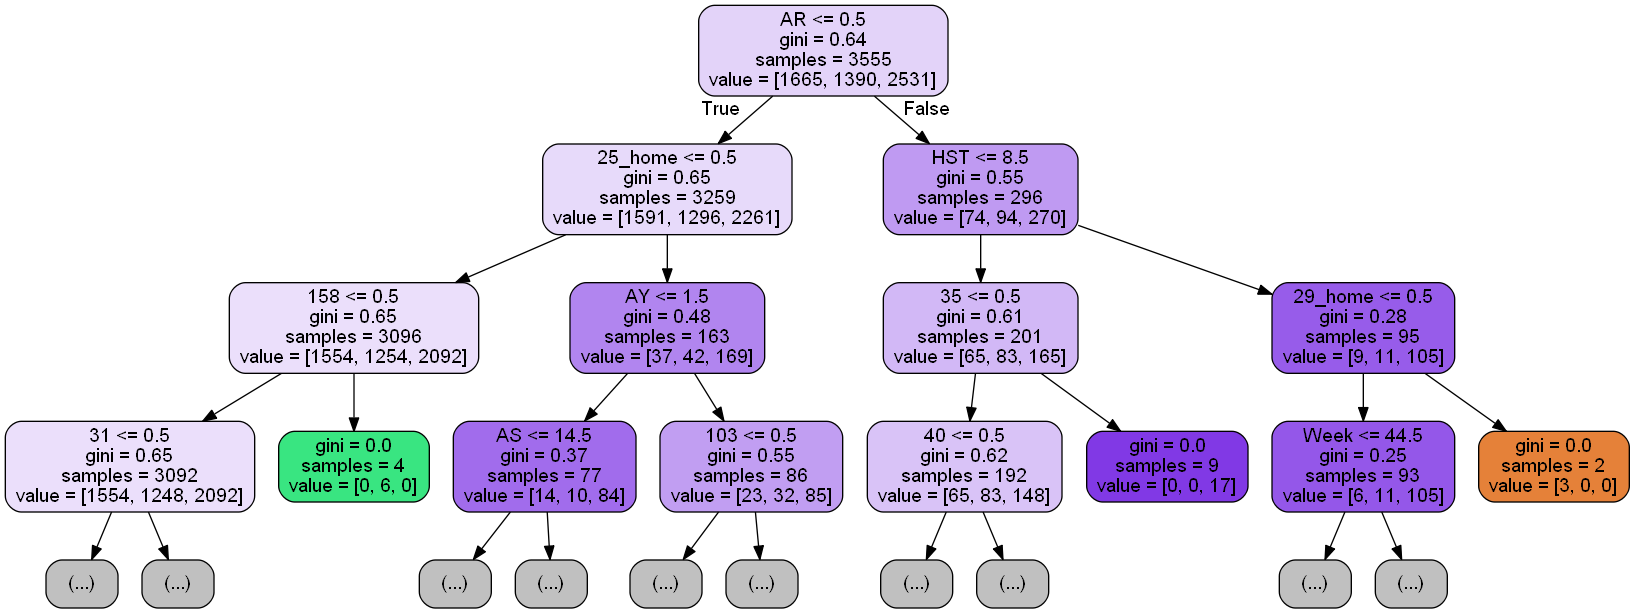

In [9]:
#Print rf tree N.B. may not work without importing graphviz, random forest images will be on GitHub
Image(filename = rf_tree_visualiser(rf, 'featureSetTree', data_filtered.columns))

### 3.1.6 Training model without Referee
<a name='section316'></a>

In [130]:
#Train model without Referee feature
data_filtered_no_ref = data_filtered.iloc[:, 0:15].join(data_filtered.iloc[:, 58:])
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_ref, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Referee: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")
#Ref is having negative impact so remove
data_filtered = data_filtered_no_ref

Accuracy without Referee: 56.97577276524645%
Difference from before: 0.3341687552213841%


### 3.1.7 Random Forest Tree without Referee
<a name='section317'></a>

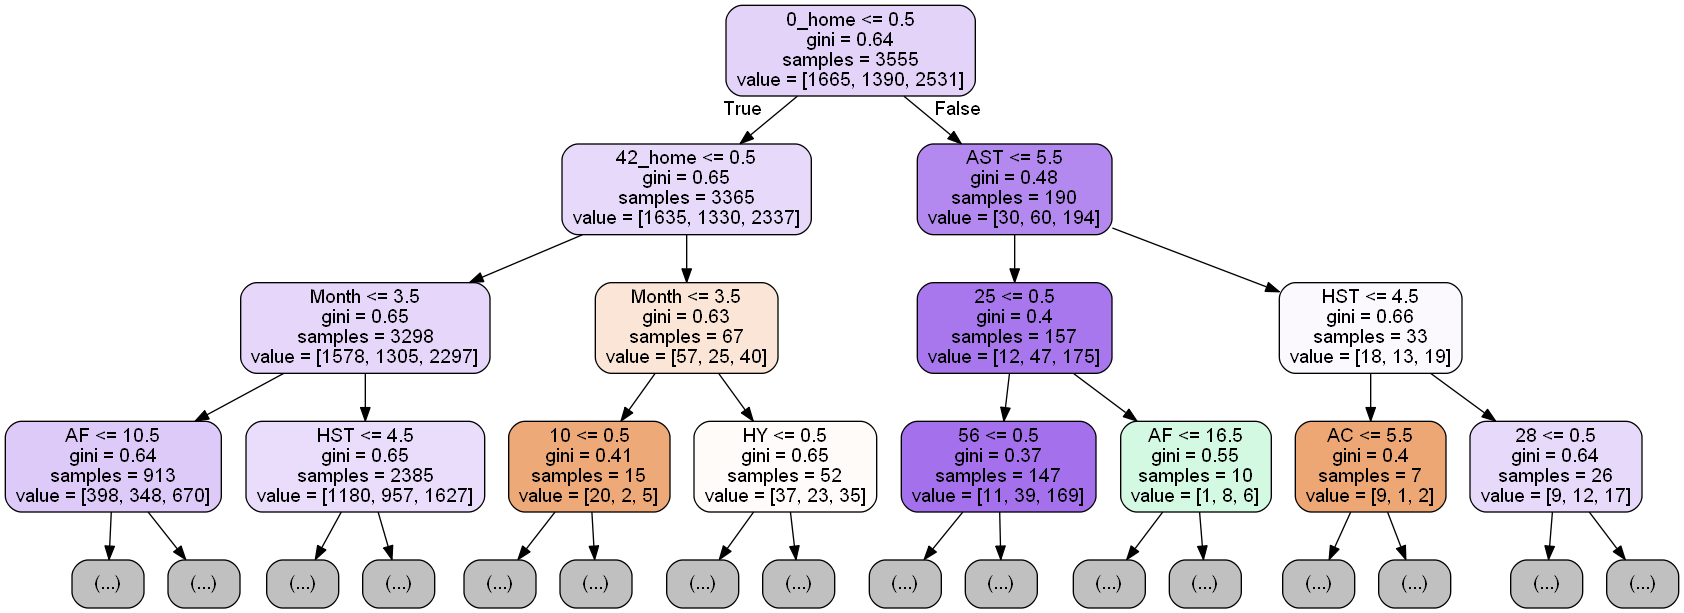

In [11]:
#Print rf tree (no ref)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoRef', data_filtered_no_ref.columns))

### 3.1.8 Training model without Date
<a name='section318'></a>

In [131]:
#Train model without Date feature
data_filtered_no_date = data_filtered.iloc[:, 3:]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_date, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Dates: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")

Accuracy without Dates: 56.68337510442774%
Difference from before: 0.04177109440267657%


### 3.1.9 Random Forest Tree without Date
<a name='section319'></a>

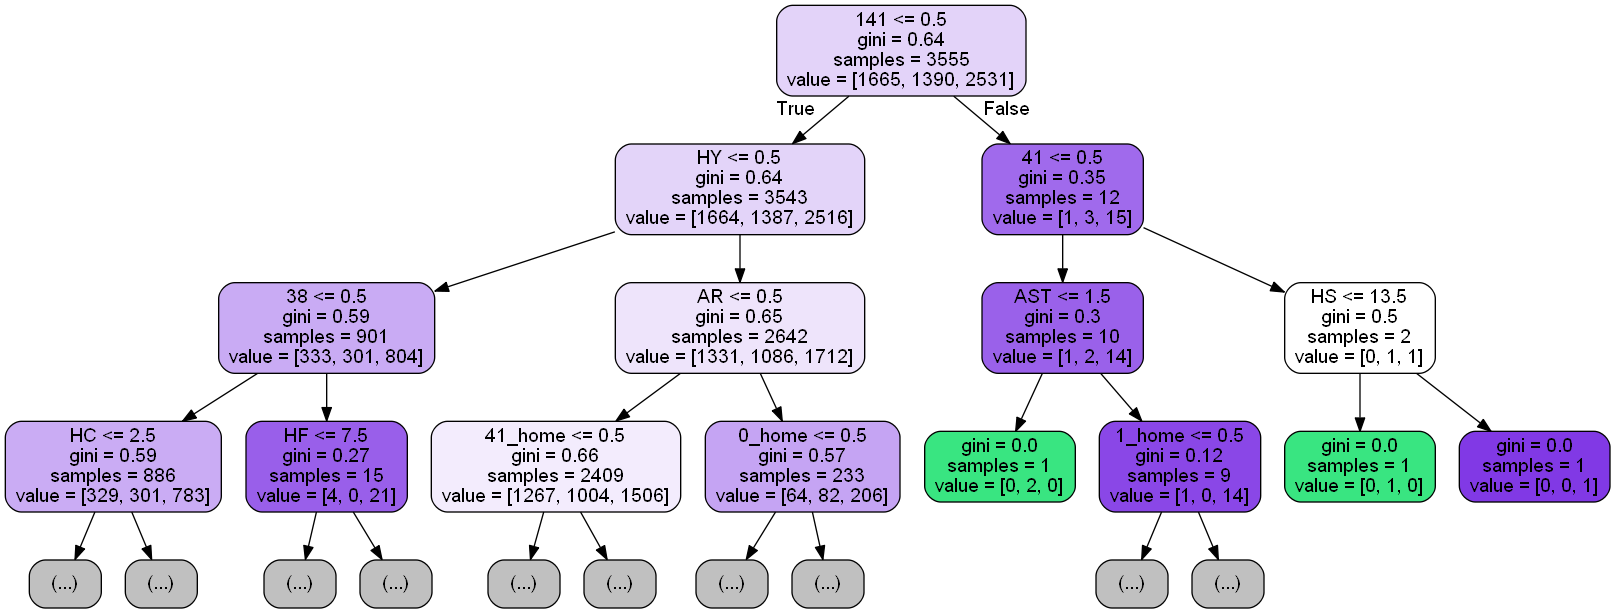

In [13]:
#Print rf tree (no dates)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoDate', data_filtered_no_date.columns))

### 3.1.10 Training model on only in-game stats
<a name='section3110'></a>

In [132]:
#Train model on only in-game stats to identify most important ones
data_filtered_only_game_stats = data_filtered.iloc[:, 3:15]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_only_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

Accuracy on all in-game stats: 55.51378446115288%


### 3.1.11 Visualising selected features
<a name='section3111'></a>

In [133]:
#Visualise and analyse initial results

#Display feature importances in descending order
feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))
#Important note: AF/HF rank higher than HC/AC

Feature Importances: 
Feature: HST                                 Importance: 0.12062860482667323
Feature: HS                                  Importance: 0.1095698299548388
Feature: AF                                  Importance: 0.10773279032401849
Feature: AS                                  Importance: 0.10644024578251926
Feature: HF                                  Importance: 0.10552340949204712
Feature: AST                                 Importance: 0.10340580600855823
Feature: HC                                  Importance: 0.09977784314864165
Feature: AC                                  Importance: 0.09278372110367616
Feature: AY                                  Importance: 0.06835535366590526
Feature: HY                                  Importance: 0.061179795298330265
Feature: AR                                  Importance: 0.01327811150903203
Feature: HR                                  Importance: 0.011324488885759381

Confusion Matrix: 
[[393  63 238]
 [175  73 355]
 [1

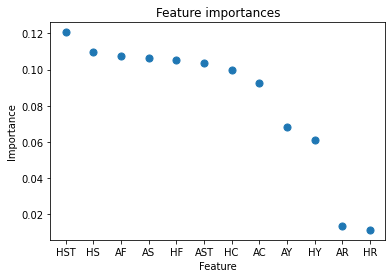

In [134]:
# Visualise feature importance
scatter(feature_importances, "Feature importances", "Feature", "Importance")

C:\Users\Fahim\anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  app.launch_new_instance()


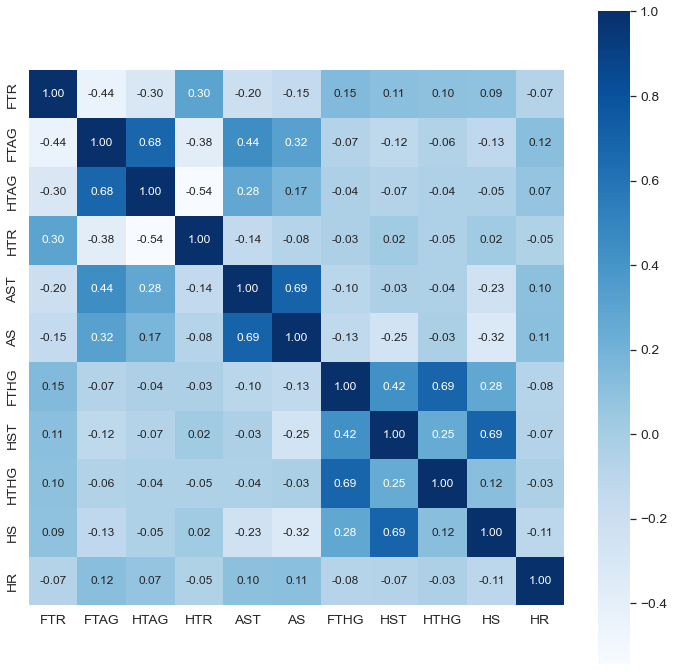

In [17]:
# plot Pearson Correlation Heatmap to see the top 10 features related to the match result FTR

def plotGraph(X_all, Y_all):

    train_data=pd.concat([X_all,Y_all],axis=1)

    #FTR correlation matrix
    plt.figure(figsize=(12,12))
    k = 11 # number of variables for heatmap
    cols = abs(train_data.astype(float).corr()).nlargest(k, 'FTR')['FTR'].index
    cm = np.corrcoef(train_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, cmap="Blues", yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

attributes = data.drop(['Date','HomeTeam', 'AwayTeam', 'Referee','FTR'],1)
attributes['HTR'] = attributes['HTR'].map({'H':1,'A':0,'D':2})
label = data['FTR']
label = label.map({'H':1,'A':0,'D':2})
plotGraph(attributes,label)


In [135]:
#Feature Selection
#change names and display selected features more nicely, ideally with their importance, gini impurity...
selected_feat = select_feat(X_train, y_train)
print(selected_feat)

Index(['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC'], dtype='object')


In [136]:
#Train model on selected in-game stats only
indexes = []
for feat in selected_feat:
    indexes.append(data_filtered_only_game_stats.columns.get_loc(feat))
    
data_filtered_filtered_game_stats = data_filtered_only_game_stats.iloc[:, indexes]

X_train, X_test, y_train, y_test = train_test_split(data_filtered_filtered_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, reduced_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on reduced in-game stats: " + str(reduced_stats_accuracy) + "%")
print("Difference compared to all in-game stats: " + str(reduced_stats_accuracy - all_stats_accuracy) + "%")

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))

Accuracy on reduced in-game stats: 54.92898913951546%
Difference compared to all in-game stats: -0.5847953216374222%

Confusion Matrix: 
[[379  72 243]
 [163  79 361]
 [149  91 857]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       694
           1       0.33      0.13      0.19       603
           2       0.59      0.78      0.67      1097

    accuracy                           0.55      2394
   macro avg       0.49      0.49      0.47      2394
weighted avg       0.51      0.55      0.51      2394



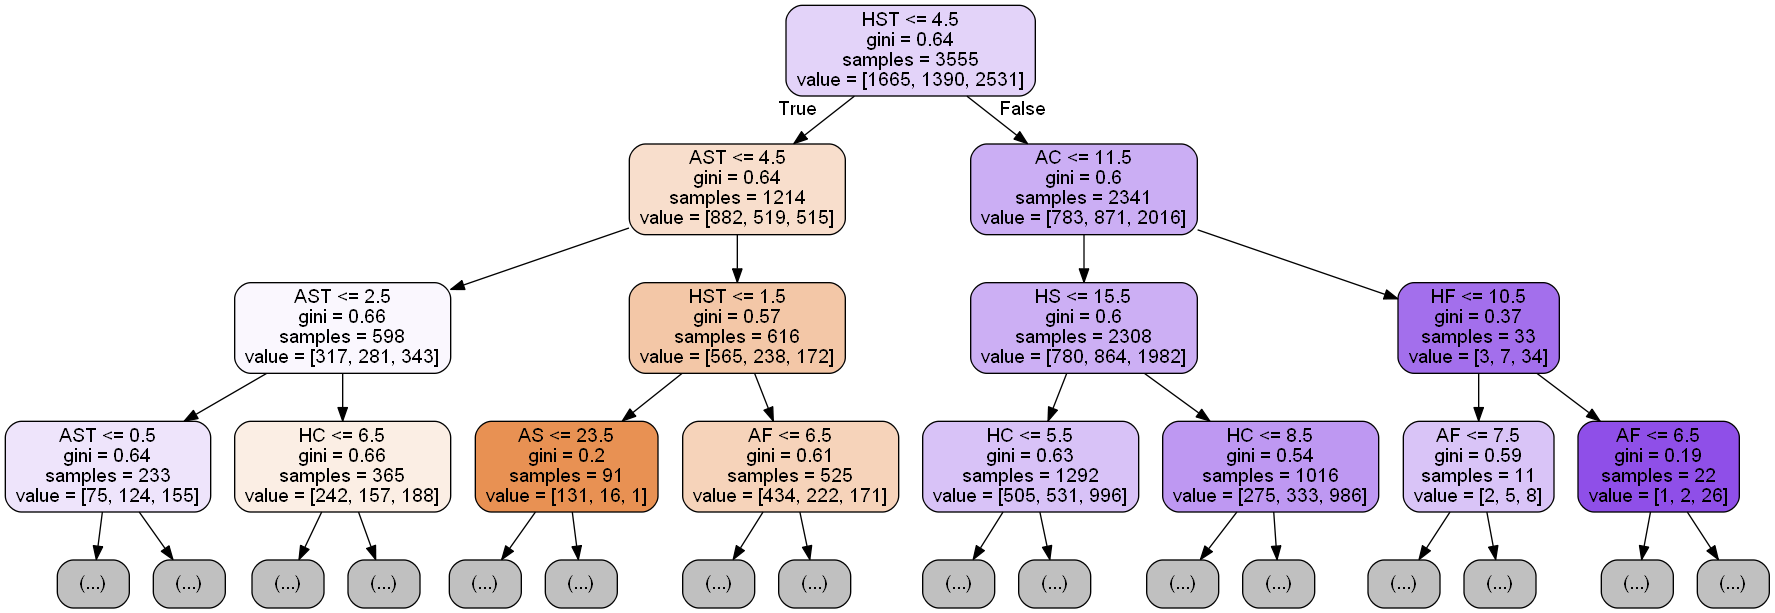

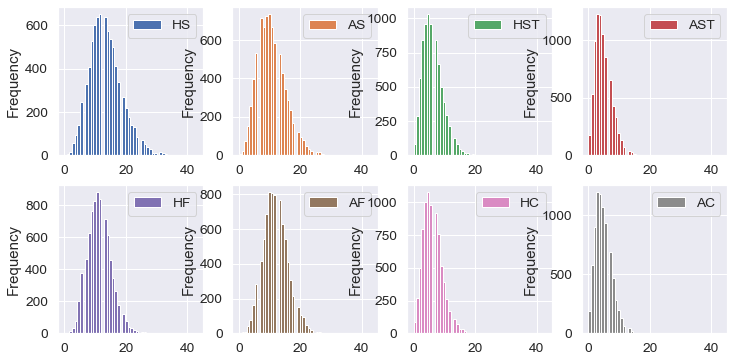

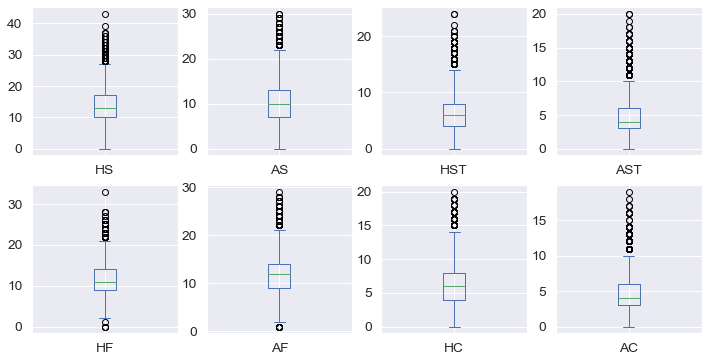

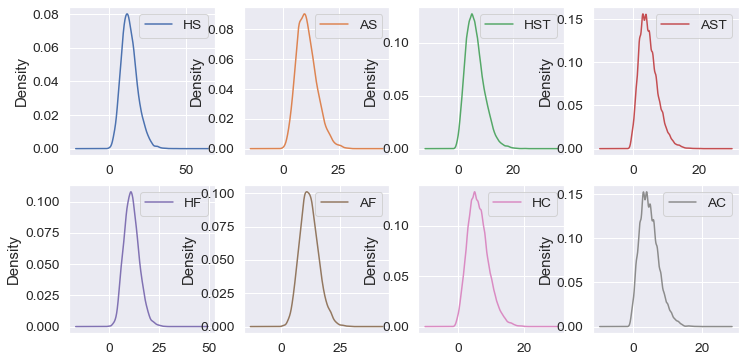

In [20]:
#Visualisation of new featureset/tree
data_filtered_filtered_game_stats.plot(kind='hist', subplots=True, sharex=False, sharey=False, bins=50, layout=(2,4), figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='density', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
Image(filename = rf_tree_visualiser(rf, 'selectedFeatureSetTree', data_filtered_filtered_game_stats.columns))

In [137]:
#Produce new dataset
#Fix column names
#Restack teams and dates

#Original teams are needed to be able to compute priors
data_new = data.iloc[:, [1, 2]].join(data_filtered_filtered_game_stats)
data_new = dates_split.join(data_new)

#Stack previously removed giveaway columns
data_new = data_new.join(data.iloc[:, [3, 4, 5, 6, 7, 8]])

#Feature engineer second half goals
#Second half home goals
SHHG = np.array(data.iloc[:, [3]]) - np.array(data.iloc[:, [6]])
#Second half away goals
SHAG = np.array(data.iloc[:, [4]]) - np.array(data.iloc[:, [7]])
data_new['SHHG'] = pd.DataFrame(SHHG)
data_new['SHAG'] = pd.DataFrame(SHAG)
data_new.columns = data_new.columns.astype(str)
data_new.head()

,Month,Week,Day,HomeTeam,AwayTeam,HS,AS,HST,AST,HF,AF,HC,AC,FTHG,FTAG,FTR,HTHG,HTAG,HTR,SHHG,SHAG
0,8,33,19,Charlton,Man City,17,8,14,4,13,12,6,6,4,0,H,2,0,H,2,0
1,8,33,19,Chelsea,West Ham,17,12,10,5,19,14,7,7,4,2,H,1,0,H,3,2
2,8,33,19,Coventry,Middlesbrough,6,16,3,9,15,21,8,4,1,3,A,1,1,D,0,2
3,8,33,19,Derby,Southampton,6,13,4,6,11,13,5,8,2,2,D,1,2,A,1,0
4,8,33,19,Leeds,Everton,17,12,8,6,21,20,6,4,2,0,H,2,0,H,0,0


In [138]:
#See if second half goals have significant correlation to total goals
highest_corr = corr_matrix(data_new, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data_new, "FTAG")
print("FTAG: \n" + str(highest_corr))
#Second half goals do have very strong correlation

FTHG: 
HS      0.280689
HST     0.424065
FTHG    1.000000
HTHG    0.685341
SHHG    0.768719
Name: FTHG, dtype: float64
FTAG: 
AS      0.315637
AST     0.440352
FTAG    1.000000
HTAG    0.679786
SHAG    0.775978
Name: FTAG, dtype: float64


## 3.2 Priors Feature Construction
<a name='section32'></a>

In [139]:
# From Pearson Correlation Heatmap to extract the top 10 features 
# there are two pairs of data highly correlated (see details in report), 
# so we just pick [FTHG, FTAG, HS, AS, HR, AR] from the top 10 features,
# additionally [Date, HomeTeam, AwayTeam, FTR], to derive our features.
selectedAttributes = ["Date","HomeTeam", "AwayTeam","FTR","FTHG","FTAG","HS","AS","HR","AR"]
training_data = data[selectedAttributes]

### 3.2.1 Data Cleaning
<a name='section321'></a>

In [140]:
#Derive features and remove unwanted data
def removeInvalidData(data):

    # remove data which contains None
    data.dropna(axis=0, how='any',inplace=True)

    # remove data which contains NaN, infinite or overflowed number 
    indices_to_keep = ~data.isin([np.nan, np.inf, -np.inf]).any(1)
    data = data[indices_to_keep]

    return data

#check if there are rows containing None, NaN, infinite or overflowed values
assert data.shape[0] == removeInvalidData(data).shape[0]
data = removeInvalidData(data)


In [141]:
# convert the different date formats and convert the type from str to timestamp  
def convertDate(data):
    if not isinstance(data.Date[0],str):
        return

    newDate = []
    for _, matchInfo in data.iterrows():
        if len(matchInfo.Date) == 8 :
            newDate.append(pd.to_datetime(matchInfo.Date, format="%d/%m/%y" ))
        elif len(matchInfo.Date) == 9 :
            newDate.append(pd.to_datetime(matchInfo.Date, format="%d %b %y" ))  # the date format in test data
        elif len(matchInfo.Date) == 10 :
            newDate.append(pd.to_datetime(matchInfo.Date, format="%d/%m/%Y" ))
    
    data['Date'] = pd.Series(newDate).values

    return data

# converted the date formats for later exploration and transformation
# convertDate(data_new)

### 3.2.2 Cumulative Full-time W/L Ratio
<a name='section322'></a>

In [142]:
# Computing Priors
# Calculate cumulative Full-Time win-loss ratio for Home/Away teams prior to every match
# TODO: Points-based results based on previous wins & losses 
# PHWL = Previous Home Team Win Loss Ratio
# PAWL = Previous Away Team Win Loss Ratio

def get_previousFTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    PHWL = []
    PAWL = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if y[i] == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif y[i] == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
       
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
        
        #Home/Away cumulative WL ratios prior to every match
        PHWL.append(h_wlRatio)
        PAWL.append(a_wlRatio)
        
    playing_stat.loc[:,'PHWL'] = pd.Series(PHWL)
    playing_stat.loc[:,'PAWL'] = pd.Series(PAWL)

    return playing_stat

#get_previousFTResults(data_new)

###  3.2.3 Cumulative Half-time W/L Ratio
<a name='section323'></a>

In [143]:
# Computing Priors
# Calculate cumulative Half-Time win-loss ratio for Home/Away teams prior to every match
# HHTR = Previous Home Half Time Results
# AHTR = Previous Away Half Time Results

def get_PreviousHTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    HHTR = []
    AHTR = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if playing_stat.iloc[i].HTR == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif playing_stat.iloc[i].HTR == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
            
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
       
        #Home/Away cumulative WL ratios prior to every match
        HHTR.append(h_wlRatio)
        AHTR.append(a_wlRatio)
        
    playing_stat.loc[:,'HHTR'] = pd.Series(HHTR)
    playing_stat.loc[:,'AHTR'] = pd.Series(AHTR)

    return playing_stat


#get_PreviousHTResults(data_new)

### 3.2.4 Cumulative Full-Time goals scored
<a name='section324'></a>

In [144]:
# Computing Priors
# Calculate Previous Full-Time Cumulative Goal 
# PHGS = Previous Home Goal Scored
# PAGS = Previous Away Goal Scored

def getPreviousCumulativeGoals(priorData):
    teams = {}
    PHGS = [] 
    PAGS = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']

        try:
            pcgs_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcgs_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcgs_h = 0
            pcgs_a = 0

        PHGS.append(pcgs_h)
        PAGS.append(pcgs_a)
#         print(PAGS)
#         print(PHGS)
        pcgs_h = pcgs_h + FTHG #Home team's previous goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pcgs_h)
        pcgs_a = pcgs_a + FTAG #Away team's previous goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pcgs_a)

    priorData.loc[:,'PHGS'] = pd.Series(PHGS)
    priorData.loc[:,'PAGS'] = pd.Series(PAGS)
    return priorData

#getPreviousCumulativeGoals(data_new)

### 3.2.5 Cumulative Half-time W/L Ratio
<a name='section325'></a>

In [145]:
# Computing Priors
# Calculate Previous Shots in the match
# PHS = Home teams previous match Shots, totaled over season
# PAS = Away teams previous match Shots, totaled over season

def getPreviousShots(priorData):
    teams = {}
    PHS = [] 
    PAS = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HS = priorData.iloc[i]['HS']
        AS = priorData.iloc[i]['AS']

        try:
            pcs_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcs_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcs_h = 0
            pcs_a = 0

        PHS.append(pcs_h)
        PAS.append(pcs_a)
        pcs_h = pcs_h + HS #Home team's previous goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pcs_h)
        pcs_a = pcs_a + AS #Away team's previous goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pcs_a)

    priorData.loc[:,'PHS'] = pd.Series(PHS)
    priorData.loc[:,'PAS'] = pd.Series(PAS)
    return priorData

#getPreviousShots(data_new)

### 3.2.6 Previous shots on target
<a name='section326'></a>

In [146]:
# Computing Priors
# Calculate Previous Shots on Target
# PHSOT = Home teams Previous Shots on Target, totaled over season
# PASOT = Away teams Previous Shots on Target, totaled over season

def getPreviousShotsOnTarget(priorData):
    teams = {}
    PHSOT = [] 
    PASOT = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HST = priorData.iloc[i]['HST']
        AST = priorData.iloc[i]['AST']

        try:
            pcsot_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcsot_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcsot_h = 0
            pcsot_a = 0

        PHSOT.append(pcsot_h)
        PASOT.append(pcsot_a)
        pcsot_h = pcsot_h + HST #Home team's previous goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pcsot_h)
        pcsot_a = pcsot_a + AST #Away team's previous goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pcsot_a)

    priorData.loc[:,'PHSOT'] = pd.Series(PHSOT)
    priorData.loc[:,'PASOT'] = pd.Series(PASOT)
    return priorData

#getPreviousShotsOnTarget(data_new)

### 3.2.7 Computing previous fouls
<a name='section327'></a>

In [147]:
# Computing Priors
# Calculate Previous Fouls
# PHTF = Home teams Previous Fouls, Totaled over season
# PATF = Away teams Previous Fouls, Totaled over season

def getPreviousTeamFouls(priorData):
    teams = {}
    PHTF = [] 
    PATF = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HF = priorData.iloc[i]['HF']
        AF = priorData.iloc[i]['AF']

        try:
            pcf_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcf_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcf_h = 0
            pcf_a = 0

        PHTF.append(pcf_h)
        PATF.append(pcf_a)
        pcf_h = pcf_h + HF #Home team's previous fouls before this match
        teams[priorData.iloc[i].HomeTeam].append(pcf_h)
        pcf_a = pcf_a + AF #Away team's previous fouls before this match
        teams[priorData.iloc[i].AwayTeam].append(pcf_a)

    priorData.loc[:,'PHTF'] = pd.Series(PHTF)
    priorData.loc[:,'PATF'] = pd.Series(PATF)
    return priorData

#getPreviousTeamFouls(data_new)

### 3.2.8 Computing previous corners
<a name='section328'></a>

In [148]:
# Computing Priors
# Calculate Previous Corners
# PHTC = Home teams Previous Corners, Totaled over season
# PATC = Away teams Previous Corners, Totaled over season

def getPreviousTeamCorners(priorData):
    teams = {}
    PHTC = [] 
    PATC = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HC = priorData.iloc[i]['HC']
        AC = priorData.iloc[i]['AC']

        try:
            pcc_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcc_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcc_h = 0
            pcc_a = 0

        PHTC.append(pcc_h)
        PATC.append(pcc_a)
        pcc_h = pcc_h + HC #Home team's previous corners before this match
        teams[priorData.iloc[i].HomeTeam].append(pcc_h)
        pcc_a = pcc_a + AC #Away team's previous corners before this match
        teams[priorData.iloc[i].AwayTeam].append(pcc_a)

    priorData.loc[:,'PHTC'] = pd.Series(PHTC)
    priorData.loc[:,'PATC'] = pd.Series(PATC)
    return priorData

#getPreviousTeamCorners(data_new)

### 3.2.9 Computing previous goals before half-time
<a name='section329'></a>

In [149]:
# Computing Priors
# Calculate Previous Goals before half time
# PHTHG = Home teams Previous Goals Before Half Time, Totaled over season
# PHTAG = Away teams Previous Goals Before Half Time, Totaled over season

def getPreviousHalfTimeGoalsScored(priorData):
    teams = {}
    PHTHG = [] 
    PHTAG = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            pchtg_h = teams[priorData.iloc[i].HomeTeam].pop()
            pchtg_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pchtg_h = 0
            pchtg_a = 0

        PHTHG.append(pchtg_h)
        PHTAG.append(pchtg_a)
        pchtg_h = pchtg_h + HTHG #Home team's previous first half goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pchtg_h)
        pchtg_a = pchtg_a + HTAG #Away team's previous first half goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pchtg_a)

    priorData.loc[:,'PHTHG'] = pd.Series(PHTHG)
    priorData.loc[:,'PHTAG'] = pd.Series(PHTAG)
    return priorData

#getPreviousHalfTimeGoalsScored(data_new)

### 3.2.10 Compute previous goals after half-time
<a name='section3210'></a>

In [150]:
# Computing Priors
# Calculate Previous Second Half Time Goals in the match
# PSHHG = Previous Second Half Time Goals scored by Home team, totaled over season
# PSHAG = Previous Second Half Time Goals scored by Away team, totaled over season

def getPreviousSecondHalfGoals(priorData):
    teams = {}
    PSHHG = [] 
    PSHAG = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
                
        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']
        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            shg_h = teams[priorData.iloc[i].HomeTeam].pop()
            shg_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            shg_h = 0
            shg_a = 0

        PSHHG.append(shg_h)
        PSHAG.append(shg_a)
        shg_h = shg_h + (FTHG - HTHG) #Home team's previous second half goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(shg_h)
        shg_a = shg_a + (FTAG - HTAG) #Away team's previous second half goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(shg_a)

    priorData.loc[:,'PSHHG'] = pd.Series(PSHHG)
    priorData.loc[:,'PSHAG'] = pd.Series(PSHAG)
    return priorData

#getPreviousSecondHalfGoals(data_new)

### 3.2.11 Computing previous goals conceded before half-time
<a name='section3211'></a>

In [151]:
# Computing Priors
# Calculate previous goals conceded before half-time
# PHTHGC = Home Team Previous Goals Conceded Before Half Time, totaled over season
# PHTAGC = Away Team Previous Goals Conceded Before Half Time, Totaled over season

def getPreviousHalfTimeGoalConceded(priorData):
    teams = {}
    PHTHGC = [] 
    PHTAGC = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
                      
        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            phtgc_h = teams[priorData.iloc[i].HomeTeam].pop()
            phtgc_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            phtgc_h = 0
            phtgc_a = 0

        PHTHGC.append(phtgc_h)
        PHTAGC.append(phtgc_a)
        phtgc_h = phtgc_h + HTAG #Home team's previous half time goals conceded before this match
        teams[priorData.iloc[i].HomeTeam].append(phtgc_h)
        phtgc_a = phtgc_a + HTHG #Away team's previous half time goals conceded before this match
        teams[priorData.iloc[i].AwayTeam].append(phtgc_a)

    priorData.loc[:,'PHTHGC'] = pd.Series(PHTHGC)
    priorData.loc[:,'PHTAGC'] = pd.Series(PHTAGC)
    return priorData

#getPreviousHalfTimeGoalConceded(data_new)

### 3.2.12 Computing previous goals conceded after half-time
<a name='section3212'></a>

In [152]:
# Computing Priors
# Calculate previous goals conceded after half-time
# PSHHGC = Previous second half home team goals conceded, totaled over season
# PSHAGC = Previous second half away team goals conceded, totaled over season

def getPreviousSecondHalfGoalConceded(priorData):
    teams = {}
    PSHHGC = [] 
    PSHAGC = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
  
        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']   
        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            pshhgc_h = teams[priorData.iloc[i].HomeTeam].pop()
            pshhgc_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pshhgc_h = 0
            pshhgc_a = 0

        PSHHGC.append(pshhgc_h)
        PSHAGC.append(pshhgc_a)
        pshhgc_h = pshhgc_h + (FTAG - HTAG) #Home team's previous half time goals conceded before this match
        teams[priorData.iloc[i].HomeTeam].append(pshhgc_h)
        pshhgc_a = pshhgc_a + (FTHG - HTHG) #Away team's previous half time goals conceded before this match
        teams[priorData.iloc[i].AwayTeam].append(pshhgc_a)

    priorData.loc[:,'PSHHGC'] = pd.Series(PSHHGC)
    priorData.loc[:,'PSHAGC'] = pd.Series(PSHAGC)
    return priorData

#getPreviousSecondHalfGoalConceded(data_new)

### 3.2.13 Matches Played
<a name='section3213'></a>

In [153]:
# Computing Priors 
# Calculate previous goals conceded after half-time
# PMPH = Previous total matches played for home team
# PMPA = Previous total matches played for away team
def getPreviousMatchesPlayed(priorData):
    teams = {}
    PMPH = [] 
    PMPA = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        try:
            pmp_h = teams[priorData.iloc[i].HomeTeam].pop()
            pmp_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pmp_h = 0
            pmp_a = 0

        PMPH.append(pmp_h)
        PMPA.append(pmp_a)
        pmp_h = pmp_h + 1 #Home team's previous number matches played
        teams[priorData.iloc[i].HomeTeam].append(pmp_h)
        pmp_a = pmp_a + 1 #Away team's previous number matches played
        teams[priorData.iloc[i].AwayTeam].append(pmp_a)

    priorData.loc[:,'PMPH'] = pd.Series(PMPH)
    priorData.loc[:,'PMPA'] = pd.Series(PMPA)
    return priorData

print(getPreviousMatchesPlayed(data_new))

      Month  Week  Day          HomeTeam        AwayTeam  HS  AS  HST  AST  \
0         8    33   19          Charlton        Man City  17   8   14    4   
1         8    33   19           Chelsea        West Ham  17  12   10    5   
2         8    33   19          Coventry   Middlesbrough   6  16    3    9   
3         8    33   19             Derby     Southampton   6  13    4    6   
4         8    33   19             Leeds         Everton  17  12    8    6   
...     ...   ...  ...               ...             ...  ..  ..  ...  ...   
7975      5    20   23         Liverpool  Crystal Palace  19   5    5    4   
7976      5    20   23          Man City         Everton  21   8   11    3   
7977      5    20   23  Sheffield United         Burnley  12  10    3    3   
7978      5    20   23          West Ham     Southampton  14  17    7    5   
7979      5    20   23            Wolves      Man United  14   9    4    4   

      HF  AF  HC  AC  FTHG  FTAG FTR  HTHG  HTAG HTR  SHHG  SHA

## 3.3 Additional Features
<a name='section33'></a>

### 3.3.1 Distance Travelled for Away Teams
<a name='section331'></a>

In [154]:
# DIS
# The positionalData contains the latitude and longitude of teams
def getDistance(priorData):
  array = []
  for x in priorData.iterrows():
   
    home_lat = (positionalData.loc[positionalData['Team'] == x[1].HomeTeam]).Latitude
    home_long = (positionalData.loc[positionalData['Team'] == x[1].HomeTeam]).Longitude
    home_location = (np.float32(home_lat), np.float32(home_long))
    
    away_lat = (positionalData.loc[positionalData['Team'] == x[1].AwayTeam]).Latitude
   
    away_long = (positionalData.loc[positionalData['Team'] == x[1].AwayTeam]).Longitude
    away_location = (np.float32(away_lat), np.float32(away_long))
    array.append(np.float32(geodesic(home_location, away_location).km))
  
  
  DIS = pd.Series(array)
  priorData.loc[:,'DIS'] = DIS

  return priorData

### 3.3.2 Average shots on goal in the past 3 matches
<a name='section332'></a>

In [155]:
# Average shots on goal for the past 3 matches
# HAS, AAS
def getPreviousShotOnGoal_3(priorData):
    teams = {}
    HAS = [] 
    AAS = []   
    
    for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = deque([None, None, None]) #[3rd, 2nd, latest priorData]
            
    # for each match
    for i in range(len(priorData)):

            
        try:
            as_h = np.mean(teams[priorData.iloc[i].HomeTeam])
            as_a = np.mean(teams[priorData.iloc[i].AwayTeam])
        except:
            as_h = None
            as_a = None

        HAS.append(as_h)
        AAS.append(as_a)

        teams[priorData.iloc[i].HomeTeam].popleft()
        teams[priorData.iloc[i].HomeTeam].append(priorData.iloc[i].HS)

        teams[priorData.iloc[i].AwayTeam].popleft()
        teams[priorData.iloc[i].AwayTeam].append(priorData.iloc[i].AS)

    priorData.loc[:,'HAS'] = pd.Series(HAS)
    priorData.loc[:,'AAS'] = pd.Series(AAS)

    return priorData

#getPreviousShotOnGoal_3(data_new)

### 3.3.3 WL Performance of past 3 matches
<a name='section333'></a>

In [156]:
# Performance of Home-Away teams in past 3 matches
# HM1, AM1, HM2, AM2, HM3, AM3
def getPerformanceOfLast3Matches(priorData):
    HM1 = []    # performance of the last match of home team
    AM1 = []    # performance of the last match of away team

    HM2 = []    # performance of the 2nd last match of home team
    AM2 = []

    HM3 = []    # performance of the 3rd last match of home team
    AM3 = []

    teams = {}
    
    for name in priorData.groupby('HomeTeam').mean().T.columns:
               teams[name] = deque([None, None, None])  #[3rd, 2nd, latest priorData]

    for i in range(len(priorData)):
        

        HM3.append(teams[priorData.iloc[i].HomeTeam].popleft())
        AM3.append(teams[priorData.iloc[i].AwayTeam].popleft())
        HM2.append(teams[priorData.iloc[i].HomeTeam][0])
        AM2.append(teams[priorData.iloc[i].AwayTeam][0])
        HM1.append(teams[priorData.iloc[i].HomeTeam][1])
        AM1.append(teams[priorData.iloc[i].AwayTeam][1])

        if priorData.iloc[i].FTR == 'H':
            teams[priorData.iloc[i].HomeTeam].append('W')
            teams[priorData.iloc[i].AwayTeam].append('L')
        elif priorData.iloc[i].FTR == 'A':
            teams[priorData.iloc[i].AwayTeam].append('W')
            teams[priorData.iloc[i].HomeTeam].append('L')
        else:
            teams[priorData.iloc[i].AwayTeam].append('D')
            teams[priorData.iloc[i].HomeTeam].append('D')

    priorData.loc[:,'HM1'] = HM1
    priorData.loc[:,'AM1'] = AM1
    priorData.loc[:,'HM2'] = HM2
    priorData.loc[:,'AM2'] = AM2
    priorData.loc[:,'HM3'] = HM3
    priorData.loc[:,'AM3'] = AM3

    return priorData

#print(getPerformanceOfLast3Matches(data_new)

### 3.3.4 Cumulative Full Time Goal Difference
<a name='section334'></a>

In [157]:
# Computing Priors
# Calculate cumulative Full-Time goal different for Home/Away teams prior to every match
# HCGD = Home Cumulative Goal Difference
# ACGD = Away Cumulative Goal Difference
def getCumulativeGoalsDiff(priorData):
    teams = {}
    HCGD = [] 
    ACGD = []   

    # for each match
    for i in range(len(priorData)):
        # as the result in 3.2.1 shows that the number of matchese per season is always the same, so here we simply use i%380==0 to check if it is a new season and to initialize the feature.
        if (i % 380 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']

        try:
            cgd_h = teams[priorData.iloc[i].HomeTeam].pop()
            cgd_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            cgd_h = 0
            cgd_a = 0

        HCGD.append(cgd_h)
        ACGD.append(cgd_a)
        cgd_h = cgd_h + FTHG - FTAG
        teams[priorData.iloc[i].HomeTeam].append(cgd_h)
        cgd_a = cgd_a + FTAG - FTHG
        teams[priorData.iloc[i].AwayTeam].append(cgd_a)

    priorData.loc[:,'HCGD'] = pd.Series(HCGD)
    priorData.loc[:,'ACGD'] = pd.Series(ACGD)

    return priorData

#getCumulativeGoalsDiff(data_new)

### 3.3.5 Goalkeeper Stats
<a name='section335'></a>

In [42]:
# # Goalkeeping stats for each team for season starting 2008/2009, ending at present (2021/2020)
# def getGK(data, GKData):
    
#     teams = {}
#     HSaveP = [] #Save percentage (Home team)
#     HCSP   = [] #Clean sheet percentage
#     ASaveP = [] 
#     ACSP   = [] 
    
#     ## Split data into seasons
#     data2008 = data.iloc[:379,:] # 2008-2009 season
#     data2009 = data.iloc[380:759,:]
#     data2010 = data.iloc[760:1139,:]
#     data2011 = data.iloc[1140:1519,:]
#     data2012 = data.iloc[1520:1899,:]
#     data2013 = data.iloc[1900:2279,:]
#     data2014 = data.iloc[2280:2659,:]
#     data2015 = data.iloc[2660:3039,:]
#     data2016 = data.iloc[3040:3419,:]
#     data2017 = data.iloc[3420:3799,:]
#     data2018 = data.iloc[3800:4179,:]
#     data2019 = data.iloc[4180:4559,:]
#     data2020 = data.iloc[4560:4939,:] #2020-2021 season
    
#     GKData2008 = GKData.iloc[:19,:] # 2008-2009 season
#     GKData2009 = GKData.iloc[20:39,:]
#     GKData2010 = GKData.iloc[40:59,:]
#     GKData2011 = GKData.iloc[60:79,:]
#     GKData2012 = GKData.iloc[80:99,:]
#     GKData2013 = GKData.iloc[100:119,:]
#     GKData2014 = GKData.iloc[120:139,:]
#     GKData2015 = GKData.iloc[140:159,:]
#     GKData2016 = GKData.iloc[160:179,:]
#     GKData2017 = GKData.iloc[180:199,:]
#     GKData2018 = GKData.iloc[200:219,:]
#     GKData2019 = GKData.iloc[220:239,:]
#     GKData2020 = GKData.iloc[240:259,:] #2020-2021 season

#     for i in data.groupby('HomeTeam').mean().T.columns: #for 2009 season
#             teams[i] = [] #Each team gets their own list

#     # the value corresponding to keys is a list containing the match result

#     for i in range(len(GKData2008)): # i think swap this for data instead and figure how to go through gkdata 1 at a time
#         if GKData2008.iloc[i].Squad == data2008.iloc[i].HomeTeam:
#             teams[data2008.iloc[i].HomeTeam].append(GKData2008[["SavePercentage","CSPercentage"]].iloc[i])
#     print(teams)
#     print(len(GKData2008))
        
# #         SAVEP = teams[data2009.iloc[i].HomeTeam] #use 2008 season gk data
# #         CSP = teams[data2009.iloc[i].HomeTeam]

# #         HSaveP.append(SAVEP)
# #         HCSP.append(CSP)
# #         ASaveP.append(SAVEP)
# #         ACSP.append(CSP)
        
# #         teams[data2009.iloc[i].HomeTeam].append(SAVEP)
# #         teams[data2009.iloc[i].HomeTeam].append(CSP)
# #         teams[data2009.iloc[i].AwayTeam].append(SAVEP)
# #         teams[data2009.iloc[i].AwayTeam].append(CSP)

# #         data2009.loc[:,'HSaveP'] = pd.Series(HSaveP)
# #         data2009.loc[:,'HCSP'] = pd.Series(HCSP)
# #         data2009.loc[:,'ASaveP'] = pd.Series(ASaveP)
# #         data2009.loc[:,'ACSP'] = pd.Series(ACSP)
#     return data2009

# getGK(data, GKData)

### Priors - extra features pulled

In [158]:
def add_pickled_to_df(df,filename,column):
    matrix = pd.read_pickle(filename)
    matrix[2008] = np.NaN
#     print(matrix)
    difference = []
    for i in range(0,len(data_new)):
    #     print(ratings_matrix["mean"].loc[data_new["HomeTeam"].iloc[i]])
        if pd.isnull(matrix[year[i]].loc[df["HomeTeam"].iloc[i]]) or pd.isnull(matrix[year[i]].loc[df["AwayTeam"].iloc[i]]):
            difference.append(np.nan)
            
        else:
            difference.append(matrix[year[i]].loc[df["HomeTeam"].iloc[i]]-matrix[year[i]].loc[df["AwayTeam"].iloc[i]])

#     for i in range(0,len(difference)):
#         if difference[i]<-0.1:
#             difference[i]='A'
#         elif difference[i]>0.1:
#             difference[i]='H'
#         else:
#             difference[i]='D'

    df[column]=difference
    return df

### We have decided not to include these scraped features due to the many missing values without a reliable way to impute them.

In [44]:
# import glob
# files = glob.glob("./Pickles/*")
# for file in files:
#     name = file.split("\\")[-1].split(".")[0].replace("DF","")
#     data_new = add_pickled_to_df(data_new,file,name)

# data_new

## 3.4 Derive Priors
<a name='section34'></a>

In [159]:
def DerivePriors(priorData):
    #get_previousFTResults(priorData) # dont want Full time results in the test data
    get_PreviousHTResults(priorData)
    getPreviousCumulativeGoals(priorData)
    getPreviousShots(priorData)
    getPreviousShotsOnTarget(priorData)
    getPreviousTeamFouls(priorData)
    getPreviousTeamCorners(priorData)
    getPreviousHalfTimeGoalsScored(priorData)
    getPreviousSecondHalfGoals(priorData)
    getPreviousHalfTimeGoalConceded(priorData)
    getPreviousSecondHalfGoalConceded(priorData)
    getPreviousMatchesPlayed(priorData)
    getDistance(priorData)
    getPreviousShotOnGoal_3(priorData)
    getPerformanceOfLast3Matches(priorData)
    getCumulativeGoalsDiff(priorData)
    #getGK(data, GKData)
    return priorData

In [160]:
## Remove First Initial Season
data_new = DerivePriors(data_new).iloc[380:] #chop off first season 
y=np.delete(y,slice(0,380),axis=0)
data_new.reset_index(drop=True, inplace=True)
data_new 

,Month,Week,Day,HomeTeam,AwayTeam,HS,AS,HST,AST,HF,AF,HC,AC,FTHG,FTAG,FTR,HTHG,HTAG,HTR,SHHG,SHAG,PMPH,PMPA,HHTR,AHTR,PHGS,PAGS,PHS,PAS,PHSOT,PASOT,PHTF,PATF,PHTC,PATC,PHTHG,PHTAG,PSHHG,PSHAG,PHTHGC,PHTAGC,PSHHGC,PSHAGC,DIS,HAS,AAS,HM1,AM1,HM2,AM2,HM3,AM3,HCGD,ACGD
0,8,33,18,Charlton,Everton,8,12,4,9,15,17,4,4,1,2,A,0,0,D,1,2,38,38,0.358974,0.179487,50,45,373,394,217,195,467,558,213,203,27,19,23,26,21,26,36,33,5929.836426,13.000000,15.000000,L,D,L,L,W,W,0,0
1,8,33,18,Derby,Blackburn,7,14,3,4,14,15,4,10,2,1,H,1,0,H,1,1,38,0,0.307692,0.000000,37,0,305,0,141,0,529,0,159,0,20,0,17,0,25,0,34,0,114.101906,NaN,NaN,D,None,W,None,L,None,0,0
2,8,33,18,Leeds,Southampton,16,11,6,6,16,24,10,3,2,0,H,0,0,D,2,0,38,38,0.307692,0.205128,64,40,475,414,228,174,589,509,270,211,28,16,36,24,26,18,17,30,319.810089,15.333333,12.333333,W,W,W,W,L,L,0,0
3,8,33,18,Leicester,Bolton,6,18,1,8,21,17,3,5,0,5,A,0,4,A,0,1,38,0,0.179487,0.000000,39,0,326,0,159,0,426,0,174,0,18,0,21,0,20,0,31,0,141.877075,NaN,NaN,L,None,W,None,L,None,0,0
4,8,33,18,Liverpool,West Ham,9,3,6,3,13,12,5,3,2,1,H,1,1,D,1,0,38,38,0.384615,0.205128,71,45,488,475,249,229,473,473,243,213,28,18,43,27,18,28,21,22,293.542877,14.666667,13.000000,W,L,D,W,W,L,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7595,5,20,23,Liverpool,Crystal Palace,19,5,5,4,10,8,14,1,2,0,H,1,0,H,1,0,797,341,0.408521,0.216374,1420,378,12013,3784,5550,1298,8540,4028,5153,1732,621,146,799,232,344,206,438,291,298.991241,21.000000,15.333333,W,L,W,W,W,L,24,-24
7596,5,20,23,Man City,Everton,21,8,11,3,8,10,7,5,5,0,H,2,0,H,3,0,759,797,0.418421,0.281955,1374,1059,10879,9446,4969,4393,8536,9646,4890,4411,634,470,740,589,353,427,467,561,51.120102,13.000000,15.000000,L,W,W,L,L,D,46,4
7597,5,20,23,Sheffield United,Burnley,12,10,3,3,11,1,8,9,1,0,H,1,0,H,0,0,113,265,0.192982,0.203008,90,266,1069,2725,413,976,1313,2770,555,1140,39,121,51,145,69,188,88,213,67.803841,9.333333,13.333333,L,L,W,L,L,W,-42,-21
7598,5,20,23,West Ham,Southampton,14,17,7,5,5,9,2,3,3,0,H,2,0,H,1,0,683,531,0.273392,0.259398,845,655,7904,6486,3419,2620,7829,6334,3541,2858,380,299,465,356,447,346,562,387,121.822838,15.666667,14.000000,W,L,D,W,L,W,12,-18


### 3.5 Final Data Preprocessing
<a name='section35'></a>

In [168]:
#Final data preprocessing

# TODO:
# Implement dates using trig - done
# Add one hot encoded teams - done
# Compute custom features using priors (goals/shots on target, shots on target / total shots, home team fouls / away team fouls)
# PHGS/PHSOT, PAGS/PASOT & PHSOT/PHS, PASOT/PAS & PHTF/PATF - done
# Implement scaling but don't apply just yet - done
# Apply PCA - done

dates = data_new.iloc[:, 0:3]
month_sin = transformation(dates["Month"])[0]
month_cos = transformation(dates["Month"])[1]
week_sin = transformation(dates["Week"])[0]
week_cos = transformation(dates["Week"])[1]
day_sin = transformation(dates["Day"])[0]
day_cos = transformation(dates["Day"])[1]

teams = pd.DataFrame(home_t.toarray()).add_prefix("home_").join(pd.DataFrame(away_t.toarray()).add_prefix("away_"))

# Select only columns that contain priors, can't use in-game stats to predict the future
priors = data_new.iloc[:, 21:44]

# PHGS_PHSOT is ratio of home goals to home shots on target
PHGS_PHSOT = np.where(priors["PHSOT"] != 0, priors["PHGS"]/priors["PHSOT"], 0)
# PHGS_PHSOT is ratio of away goals to away shots on target
PAGS_PASOT = np.where(priors["PASOT"] != 0, priors["PAGS"]/priors["PASOT"], 0)
# PHSOT_PHS is ratio of home shots on target to home shots
PHSOT_PHS = np.where(priors["PHS"] != 0, priors["PHSOT"]/ (priors["PHS"] + priors["PHSOT"]), 0)
# PASOT_PAS is ratio of away shots on target to away shots
PASOT_PAS = np.where(priors["PAS"] != 0, priors["PASOT"]/ (priors["PAS"] + priors["PASOT"]), 0)
# PHTF_PATF is ratio of home fouls to away fouls
PHTF_PATF = np.where(priors["PATF"] != 0, priors["PHTF"]/priors["PATF"], 0)

# Building final dataset
X = pd.DataFrame()
X["month_cos"] = month_cos
X["month_sin"] = month_sin
X["week_cos"] = week_cos
X["week_sin"] = week_sin
X["day_cos"] = day_cos
X["day_sin"] = day_sin
X = X.join(teams).join(priors)
X["PHGS_PHSOT"] = PHGS_PHSOT.tolist()
X["PAGS_PASOT"] = PAGS_PASOT.tolist()
X["PHSOT_PHS"] = PHSOT_PHS.tolist()
X["PASOT_PAS"] = PASOT_PAS.tolist()
X["PHTF_PATF"] = PHTF_PATF.tolist()
X

,month_cos,month_sin,week_cos,week_sin,day_cos,day_sin,home_0,home_1,home_2,home_3,home_4,home_5,home_6,home_7,home_8,home_9,home_10,home_11,home_12,home_13,home_14,home_15,home_16,home_17,home_18,home_19,home_20,home_21,home_22,home_23,home_24,home_25,home_26,home_27,home_28,home_29,home_30,home_31,home_32,home_33,home_34,home_35,home_36,home_37,home_38,home_39,home_40,home_41,home_42,away_0,away_1,away_2,away_3,away_4,away_5,away_6,away_7,away_8,away_9,away_10,away_11,away_12,away_13,away_14,away_15,away_16,away_17,away_18,away_19,away_20,away_21,away_22,away_23,away_24,away_25,away_26,away_27,away_28,away_29,away_30,away_31,away_32,away_33,away_34,away_35,away_36,away_37,away_38,away_39,away_40,away_41,away_42,PMPH,PMPA,HHTR,AHTR,PHGS,PAGS,PHS,PAS,PHSOT,PASOT,PHTF,PATF,PHTC,PATC,PHTHG,PHTAG,PSHHG,PSHAG,PHTHGC,PHTAGC,PSHHGC,PSHAGC,DIS,PHGS_PHSOT,PAGS_PASOT,PHSOT_PHS,PASOT_PAS,PHTF_PATF
0,-0.500000,-0.866025,-0.717507,-0.696551,-0.874347,-0.485302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,38,0.358974,0.179487,50,45,373,394,217,195,467,558,213,203,27,19,23,26,21,26,36,33,5929.836426,0.230415,0.230769,0.367797,0.331070,0.836918
1,-0.500000,-0.866025,-0.717507,-0.696551,-0.874347,-0.485302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,38,0,0.307692,0.000000,37,0,305,0,141,0,529,0,159,0,20,0,17,0,25,0,34,0,114.101906,0.262411,0.000000,0.316143,0.000000,0.000000
2,-0.500000,-0.866025,-0.717507,-0.696551,-0.874347,-0.485302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,38,0.307692,0.205128,64,40,475,414,228,174,589,509,270,211,28,16,36,24,26,18,17,30,319.810089,0.280702,0.229885,0.324324,0.295918,1.157171
3,-0.500000,-0.866025,-0.717507,-0.696551,-0.874347,-0.485302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,0,0.179487,0.000000,39,0,326,0,159,0,426,0,174,0,18,0,21,0,20,0,31,0,141.877075,0.245283,0.000000,0.327835,0.000000,0.000000
4,-0.500000,-0.866025,-0.717507,-0.696551,-0.874347,-0.485302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,38,0.384615,0.205128,71,45,488,475,249,229,473,473,243,213,28,18,43,27,18,28,21,22,293.542877,0.285141,0.196507,0.337856,0.325284,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### 3.5.1 Split Data
<a name='section351'></a>

In [172]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

y_train = np.array(y_train).reshape(len(y_train))
y_val = np.array(y_val).reshape(len(y_val))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)


from tensorflow import keras
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)

In [173]:
#try without our custom features
rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

Accuracy on all in-game stats: 47.89473684210526%
Feature Importances: 
Feature: AHTR                                Importance: 0.04079691674434672
Feature: HHTR                                Importance: 0.038440396878765506
Feature: PAGS_PASOT                          Importance: 0.03291120935792482
Feature: PHGS_PHSOT                          Importance: 0.03252775660738477
Feature: PHSOT_PHS                           Importance: 0.03123204207301899
Feature: DIS                                 Importance: 0.030028998872474556
Feature: PASOT_PAS                           Importance: 0.029682227845421304
Feature: PHTF_PATF                           Importance: 0.028699122755288978
Feature: PHTAG                               Importance: 0.028291044905542413
Feature: PSHHG                               Importance: 0.028106852478190128
Feature: PSHAG                               Importance: 0.027934441589256134
Feature: PHTHG                               Importance: 0.027367412646157

### 3.6 Scale data
<a name='section36'></a>

In [174]:
# Not sure if data needs to be scaled so just gonna leave this here
scaler = StandardScaler().fit(X_train.iloc[:, 92:])
X_train_scaled = scaler.transform(X_train.iloc[:, 92:])
X_test_scaled = scaler.transform(X_test.iloc[:, 92:])
X_val_scaled = scaler.transform(X_val.iloc[:, 92:])

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_val = pd.DataFrame(X_val)

X_train = np.array(X_train.iloc[:, 0:92])
X_test = np.array(X_test.iloc[:, 0:92])
X_val = np.array(X_val.iloc[:, 0:92])

X_train_scaled = np.hstack((X_train, X_train_scaled))
X_test_scaled = np.hstack((X_test, X_test_scaled))
X_val_scaled = np.hstack((X_val, X_val_scaled))

# PCA
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# pca = PCA(0.95)
# pca.fit(X_train_scaled)
# X_train = pca.transform(X_train_scaled)
# X_test = pca.transform(X_test_scaled)

# pca = PCA(n_components=50)
# X = pca.fit_transform(X_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(X)

# from sklearn.manifold import MDS
# embedding = MDS(n_components=2)
# X = embedding.fit_transform(X) -> took way too long

# from sklearn.manifold import Isomap
# embedding = Isomap(n_components=2)
# X = embedding.fit_transform(X) -> gave terrible results

# import umap.umap_ as umap
# reducer = umap.UMAP(random_state=42,n_components=15)
# X = reducer.fit_transform(X_scaled) -> requires outdated numpy

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=15, kernel='rbf')
kpca.fit(X_train_scaled)
X_train = kpca.transform(X_train_scaled)
X_test = kpca.transform(X_test_scaled)
X_val = kpca.transform(X_val_scaled)
#tune hyperparams for this -> gamma

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()
# clf.fit(X_train_scaled, y_train)
# X_train = clf.transform(X_train_scaled)
# X_test = clf.transform(X_test_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

#consider combos of these eg pca then lda

In [178]:
#Reshaping data for RNN, LSTM, GRU
X_train_test = np.reshape(X_train, (532, 10, X_train.shape[1]))

y_train_test = np.reshape(y_train_categorical, (532, 10, 3))

y_train_test_cnn = np.array(y_train_categorical).reshape(-1, 1, y_train_categorical.shape[1])

X_val_test = np.reshape(X_val, (114, 10, X_val.shape[1]))

y_val_categorical_test = np.reshape(y_val_categorical, (114, 10, 3))

y_val_test_cnn = np.array(y_val_categorical).reshape(-1, 1, y_val_categorical.shape[1])

X_test_test = X_test.reshape(114, 10, X_test.shape[1])

## 4. Methodology Overview
<a name='section4'></a>

## 5. Model Training & Validation
<a name='section5'></a>

In [51]:
#Functions to remove warning to see clearer result
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning


warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

#Import for optuna and cv
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

### 5.1 Base Models
<a name='section51'></a>

#### 5.1.1 Gaussian Naive Bayes
<a name='section511'></a>

In [52]:
## TODO: Implement into pipeline ##
# Some general comments:
# Gaussian NB is most suitable for non-categorical classification
# Based on diagram above (gaussian distributed density plots) the features we use are gaussian distributed however 
# the teams are not actually gaussian distributed 
# And the features we use are not conditionally independent as the statistics arent independent (e.g. shots affect
# shots on target etc.)
# Therefore we expect that the prediction will not be accurate and naives bayes is not suitable

#prove calculations and results later



from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
y_gnb = gnb.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_gnb)
 

#Smoothing parameter scaling

cv_method = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, cv=cv_method,verbose=1, scoring='accuracy',n_jobs=-1)
y_gnb = gnb.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_gnb)
 

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_gnb), ": is the accuracy score gnb")

Fitting 30 folds for each of 100 candidates, totalling 3000 fits
0.5184210526315789 : is the accuracy score gnb


#### 5.1.2 Generic SVM
<a name='section512'></a>

In [ ]:
#Using generic SVM to estimate
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC, SVR

# gammas = np.power(2, np.linspace(-15, 3, 10))
# accuracy_validation = np.empty((5, len(gammas)))

# for l, gamma in enumerate(gammas):
#     svm = SVC(kernel='rbf', gamma=gamma, C=100)
#     svm.fit(X_train, y_train)
        
#     predict_test = svm.predict(X_test)  # test
#     print(accuracy_score(y_test, predict_test))

# SVM = svm.SVC(kernel="linear")   #(kernel="poly", degree=3, coef0=1, C=5) (kernel="linear")
# SVM.fit(training_data,y_train)# predict the labels on validation dataset
# predictions_SVM = SVM.predict(testing_data)# Use accuracy_score function to get the accuracy
# print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

# scores = cross_val_score(SVM, X_whole, y_enc, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=100))
# scores.mean()

def fineTuneSVM(X_train, y_train):
    # define model and parameters
    svm = SVC()   
    # SVM solves an optimization problem of quadratic order 
    # link on SVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    # The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.
    # Therefore, we will stick with basic kernels like linear and rbf which do the job well without sacrificing processing time.
    kernel = ['linear', 'rbf'] 
    # kernel = ['poly', 'rbf', 'sigmoid'] #Advanced kernels 
    C = [50, 10, 1.0, 0.1, 0.01]
    gamma = ['scale']
    
    # define grid search
    grid = dict(kernel=kernel,C=C,gamma=gamma)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(X_train, y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

fineTuneSVM(X_train, y_train)

# #using optuna broken
# def objective_svm(trial, X, y):
#     param_grid = {
#         "kernel": trial.suggest_categorical("kernel", ['linear', 'rbf']),
#         "C": trial.suggest_categorical("C", [50, 10, 1.0, 0.1, 0.01]),
#         "gamma": trial.suggest_categorical("gamma", ['scale']),
#     }

#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
#     cv_scores = np.empty(5)
#     for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]
        
#         model = SVC(probability = True, **param_grid)
#         model.fit(
#             X_train,
#             y_train,
#         )
#         preds = model.predict_proba(X_test)
#         cv_scores[idx] = log_loss(y_test, preds)

#     return np.mean(cv_scores)

# study = optuna.create_study(direction="minimize", study_name="SVM")
# func = lambda trial: objective_svm(trial, X, y)
# study.optimize(func, n_trials=4)

# print(f"\tBest value (rmse): {study.best_value:.5f}")

# print(f"\tBest params:")
# for key, value in study.best_params.items():
#     print(f"\t\t{key}: {value}")

# model = SVC(**study.best_params)
# model.fit(X_train, y_train)

# print('Training accuracy ' + str(model.score(X_train, y_train)))
# print('Testing accuracy ' + str(model.score(X_test, y_test)))

#model is slow - directly define model
# 	Best value (rmse): 1.02205
# 	Best params:
# 		n_estimators: 400
# 		learning_rate: 0.0008
# Training accuracy 0.5020676691729323
# Testing accuracy 0.5184210526315789


[I 2021-12-19 15:50:47,413] A new study created in memory with name: SVM
[I 2021-12-19 15:52:45,340] Trial 0 finished with value: 1.0278863851640312 and parameters: {'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'}. Best is trial 0 with value: 1.0278863851640312.


#### 5.1.3 Logistic Regression
<a name='section513'></a>

In [ ]:
## Multinomial logistic regression

lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs','saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
multi_n = ['multinomial']
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values,multi_class=multi_n)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# cv = KFold(n_splits=10, shuffle=True, random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### print all the tested results
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### 5.2 Boosting Models
<a name='section52'></a>

In [ ]:
import sys
!{sys.executable} -m pip install xgboost


import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model_pipeline = [
    ('xgboost' , (Pipeline([('xgboost' ,xgb.XGBClassifier())]))), 
#     ('nn' , (Pipeline([('nn' , kears_estimator )]))), 
#     ('...' , (Pipeline([('...' , ... )]))),
#     ('...' , (Pipeline([('...' , ... )]))),
#     ('...' , (Pipeline([('...' , ... )])))
]

results = []

for pipe ,model in model_pipeline:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds) * 100
    results.append(accuracy)
    output = "%s: %f" % (pipe, accuracy)
    print(output)


param_pipeline = Pipeline([("classifier", xgb.XGBClassifier())])
model_param_grid = [
                {"classifier": [xgb.XGBClassifier()],
#                  "classifier__penalty": ['l2','l1'],
#                  "classifier__C": np.logspace(0, 4, 10)
                 },
#                 {"classifier": [kears_estimator],
#                  "tfidf__ngram_range": [(1,1), (1,2), (2,2), (1,3)],
#                 "tfidf__use_idf": [True, False],
#                 "kc__epochs": [10, 100, ],
#                 "kc__dense_nparams": [32, 256, 512],
#                 "kc__init": [ 'uniform', 'zeros', 'normal', ], 
#                 "kc__batch_size":[2, 16, 32],
#                 "kc__optimizer":['RMSprop', 'Adam', 'Adamax', 'sgd'],
#                 "kc__dropout": [0.5, 0.4, 0.3, 0.2, 0.1, 0]
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  },
#                 {"classifier": [...],
#                  "classifier__...": [...],
#                  }
                ]
# gridsearch = GridSearchCV(param_pipeline, model_param_grid, cv=5, verbose=1,n_jobs=-1, return_train_score=True)
# best_model = gridsearch.fit(X_train,y_train)
# print(best_model.best_estimator_)
# print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

#### 5.2.1 XGBoost
<a name='section521'></a>

In [ ]:
# XGBoost

import xgboost as xgb
import optuna


def objective(trial, X, y):
    param_grid = {
        "max_depth": trial.suggest_int("max_depth", 3, 7, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01),
        "gamma": trial.suggest_float("gamma", 0, 1, step=0.25),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 10, step=1),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 5, step=2),
        "subsample": 0.8,
        "colsample_bytree": 0.5,
    }

    model = xgb.XGBClassifier(objective="multiclass", **param_grid, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)]
        )
    return model.score(X_val, y_val)


study = optuna.create_study(direction="maximize", study_name="XGBoost Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = xgb.XGBClassifier(objective="multiclass", **study.best_params, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train, eval_set=[(X_test,y_test), (X_train, y_train)])

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

#### 5.2.2 AdaBoost
<a name='section522'></a>

In [ ]:
# Optimising hyperparameters for AdaBoost
# First classified boosting algorithm

# Sources used:
# https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50
# https://analyticsindiamag.com/introduction-to-boosting-implementing-adaboost-in-python/
# https://machinelearningmastery.com/adaboost-ensemble-in-python/

# Hyperparameter types (Modified Y/N):
# Num. of trees (Y)
# Weak learner (N)
# Learning rate (Y)
# Alternate algorithm (Decision Tree/Logistic Regression)

#First classified boosting algorithm

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# define the model
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)

# grid = {
#     "n_estimators": [10, 50, 100, 500],
#     "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
# }
# abc_grid_cv = GridSearchCV(estimator=abc, param_grid = grid, n_jobs=-1, cv=3, scoring="accuracy")

# abc_grid_cv.fit(X_train, y_train)

# adc_pred = abc_grid_cv.predict(X_test)

# print("Train: %f , Params: %s, Test: %f" % (abc_grid_cv.best_score_, abc_grid_cv.best_params_, accuracy_score(y_test, adc_pred)))

#Best score and parameters for decision tree round 1
# Train: 0.525740 , Params: {'learning_rate': 0.001, 'n_estimators': 500}, Test: 0.521592

# #Round 2
# grid2 = {
#     "n_estimators": [400, 500, 600, 800, 1000],
#     "learning_rate": [0.0008, 0.001, 0.0012, 0.0014],
# }
# abc_grid_cv2 = GridSearchCV(estimator=abc, param_grid = grid2, n_jobs=-1, cv=3, scoring="accuracy")
# abc_grid_cv2.fit(X_train, y_train)
# abc_pred2 = abc_grid_cv2.predict(X_test)
# print("Train: %f , Params: %s, Test: %f" % (abc_grid_cv2.best_score_, abc_grid_cv2.best_params_, accuracy_score(y_test, abc_pred2)))

# #Best score and parameters for decision tree round 2
# #Train: 0.525740 , Params: {'learning_rate': 0.0008, 'n_estimators': 400}, Test: 0.521592
# #No improvement use as final values

# # Try with logistic regression algorithm
# # abc_lr = AdaBoostClassifier(base_estimator=LogisticRegression(solver = 'liblinear',penalty = 'l1', C = 0.01))
# # abc_lr.fit(X_train, y_train)

# # grid = {
# #     "n_estimators": [10, 50, 100, 500],
# #     "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
# # }
# # abc_lr_grid_cv = GridSearchCV(estimator=abc_lr, param_grid = grid, n_jobs=-1, cv=3, scoring="accuracy")

# # abc_lr_grid_cv.fit(X_train, y_train)

# # adc_lr_pred = abc_lr_grid_cv.predict(X_test)

# # print("Train: %f , Params: %s, Test: %f" % (abc_lr_grid_cv.best_score_, abc_lr_grid_cv.best_params_, accuracy_score(y_test, adc_lr_pred)))

# #Output
# # Train: 0.489301 , Params: {'learning_rate': 0.1, 'n_estimators': 500}, Test: 0.486505

# #Use round 2 decision tree output as predictor
# abc_final = AdaBoostClassifier(n_estimators=400, learning_rate=0.0008)

#with optuna
def objective_abc(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 1000, step=200),
        "learning_rate": trial.suggest_float("learning_rate", 0.0008, 0.0014, step=0.0002),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = AdaBoostClassifier(**param_grid)
        model.fit(
            X_train,
            y_train,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="AdaBoost")
func = lambda trial: objective_abc(trial, X, y)
study.optimize(func, n_trials=8)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = AdaBoostClassifier(**study.best_params)
model.fit(X_train, y_train)

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

#model is slow - directly define model
# 	Best value (rmse): 1.02205
# 	Best params:
# 		n_estimators: 400
# 		learning_rate: 0.0008
# Training accuracy 0.5020676691729323
# Testing accuracy 0.5184210526315789

abc_final = AdaBoostClassifier(n_estimators=400, learning_rate=0.0008)

#### 5.2.3 GradientBoost
<a name='section523'></a>

In [ ]:
# Optimising hyperparameters for GradientBoost

# Sources used:
# https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

#define the model
gbc = GradientBoostingClassifier(subsample = 0.8)
gbc.fit(X_train, y_train)
gbc_pre_pred = gbc.predict(X_test)
print("Pretuning Test: %f" % accuracy_score(y_test, gbc_pre_pred))

# grid = {
#     "n_estimators":[5,50,250,500],
#     "max_depth":[5,6],
#     "learning_rate":[0.1],
#     "min_samples_split":[40]
# }

# gbc_grid_cv = GridSearchCV(estimator=gbc, param_grid = grid, n_jobs=-1, cv=3, scoring="accuracy")
# gbc_grid_cv.fit(X_train, y_train)
# gbc_pred = gbc_grid_cv.predict(X_test)
# print("Train: %f , Params: %s, Test: %f" % (gbc_grid_cv.best_score_, gbc_grid_cv.best_params_, accuracy_score(y_test, gbc_pred)))

# Outputs
# Train: 0.515040 , Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 40, 'n_estimators': 5}, Test: 0.522267

#Round 2
# grid2 = {
#     "n_estimators":[3,5,7,9],
#     "max_depth":[5],
#     "learning_rate":[0.05,0.1,0.2],
#     "min_samples_split":[30,40,50]
# }

# gbc_grid_cv2 = GridSearchCV(estimator=gbc, param_grid = grid2, n_jobs=-1, cv=3, scoring="accuracy")
# gbc_grid_cv2.fit(X_train, y_train)
# gbc_pred2 = gbc_grid_cv2.predict(X_test)
# print("Train: %f , Params: %s, Test: %f" % (gbc_grid_cv2.best_score_, gbc_grid_cv2.best_params_, accuracy_score(y_test, gbc_pred2)))

# # Outputs
# # Train: 0.525448 , Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 50, 'n_estimators': 7}, Test: 0.528340

# gbc_final = GradientBoostingClassifier(
#     subsample = 0.8, 
#     learning_rate = 0.1, 
#     max_depth = 5, 
#     min_samples_split = 50, 
#     n_estimators = 7
# )

#with optuna
def objective_gbc(trial, X, y):
    param_grid = {
        "subsample": trial.suggest_categorical("subsample", [0.8]),
        "n_estimators": trial.suggest_int("n_estimators", 3, 9, step=3),
        "max_depth": trial.suggest_int("max_depth", 5, 6),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.1]),
        "min_samples_split": trial.suggest_int("min_samples_split", 30, 50, step=5),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = GradientBoostingClassifier(**param_grid)
        model.fit(
            X_train,
            y_train,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="GradientBoost")
func = lambda trial: objective_gbc(trial, X, y)
study.optimize(func, n_trials=8)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = GradientBoostingClassifier(**study.best_params)
model.fit(X_train, y_train)

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

gbc_final = model

#### 5.2.4 LightGBM
<a name='section524'></a>

In [ ]:
# LightGBM
# https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

import lightgbm
import optuna


def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }

    model = lightgbm.LGBMClassifier(objective="multiclass", **param_grid)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        early_stopping_rounds=100,
        )
    return model.score(X_val, y_val)


study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = lightgbm.LGBMClassifier(objective="multiclass", **study.best_params)
model.fit(X_train, y_train, eval_set=[(X_test,y_test), (X_train, y_train)], eval_metric='multi_logloss')

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

#Rename for results graph
lightgbm_final = model

### 5.3 Neural Network Models
<a name='section53'></a>

#### 5.3.1 Standard Neural Network
<a name='section531'></a>

In [181]:
#Creating Standard, baseline NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('linear'))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val_categorical))

preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_230 (Dense)           (None, 128)               2048      
                                                                 
 activation_230 (Activation)  (None, 128)              0         
                                                                 
 dropout_119 (Dropout)       (None, 128)               0         
                                                                 
 dense_231 (Dense)           (None, 3)                 387       
                                                                 
 activation_231 (Activation)  (None, 3)                0         
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
107/107 [==============================]

#### 5.3.2 Vanilla Neural Network
<a name='section532'></a>

In [ ]:
#Hyperparam tuning for vanilla nn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(layers.Dense(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['relu', 'linear', 'tanh'])))
    model.add(Dropout(0.1), )
    model.add(layers.Dense(3))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_categorical, batch_size=50, epochs=5, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_categorical)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 03:22:20,771] A new study created in memory with name: no-name-b7390e5b-6993-4a8b-9719-038e7568ca02


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0551 - accuracy: 0.4693 - val_loss: 1.0165 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 816us/step - loss: 1.0258 - accuracy: 0.4958 - val_loss: 1.0033 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 821us/step - loss: 1.0093 - accuracy: 0.5134 - val_loss: 1.0021 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 833us/step - loss: 1.0003 - accuracy: 0.5161 - val_loss: 1.0046 - val_accuracy: 0.5113
Epoch 5/5
36/36 [==============================] - 0s 578us/step - loss: 1.0138 - accuracy: 0.5105


[I 2021-12-20 03:22:21,567] Trial 0 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0953 - accuracy: 0.3830 - val_loss: 1.0917 - val_accuracy: 0.4305
Epoch 2/5
96/96 [==============================] - 0s 891us/step - loss: 1.0889 - accuracy: 0.4371 - val_loss: 1.0861 - val_accuracy: 0.4549
Epoch 3/5
96/96 [==============================] - 0s 926us/step - loss: 1.0845 - accuracy: 0.4551 - val_loss: 1.0816 - val_accuracy: 0.4624
Epoch 4/5
96/96 [==============================] - 0s 979us/step - loss: 1.0808 - accuracy: 0.4589 - val_loss: 1.0777 - val_accuracy: 0.4549
Epoch 5/5
36/36 [==============================] - 0s 569us/step - loss: 1.0772 - accuracy: 0.4526


[I 2021-12-20 03:22:22,333] Trial 1 finished with value: 0.4526315927505493 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.1036 - accuracy: 0.3438 - val_loss: 1.0857 - val_accuracy: 0.3741
Epoch 2/5
96/96 [==============================] - 0s 759us/step - loss: 1.0945 - accuracy: 0.3607 - val_loss: 1.0802 - val_accuracy: 0.3929
Epoch 3/5
96/96 [==============================] - 0s 727us/step - loss: 1.0879 - accuracy: 0.3822 - val_loss: 1.0761 - val_accuracy: 0.4041
Epoch 4/5
96/96 [==============================] - 0s 764us/step - loss: 1.0826 - accuracy: 0.3997 - val_loss: 1.0727 - val_accuracy: 0.4229
Epoch 5/5
36/36 [==============================] - 0s 548us/step - loss: 1.0813 - accuracy: 0.4289


[I 2021-12-20 03:22:23,052] Trial 2 finished with value: 0.4289473593235016 and parameters: {'n_nodes': 32, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0924 - accuracy: 0.3887 - val_loss: 1.0945 - val_accuracy: 0.3628
Epoch 2/5
96/96 [==============================] - 0s 815us/step - loss: 1.0727 - accuracy: 0.4616 - val_loss: 1.0736 - val_accuracy: 0.4624
Epoch 3/5
96/96 [==============================] - 0s 782us/step - loss: 1.0649 - accuracy: 0.4653 - val_loss: 1.0619 - val_accuracy: 0.4662
Epoch 4/5
96/96 [==============================] - 0s 823us/step - loss: 1.0595 - accuracy: 0.4651 - val_loss: 1.0533 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 562us/step - loss: 1.0591 - accuracy: 0.4535


[I 2021-12-20 03:22:23,745] Trial 3 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 64, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0911 - accuracy: 0.4112 - val_loss: 1.0930 - val_accuracy: 0.3872
Epoch 2/5
96/96 [==============================] - 0s 881us/step - loss: 1.0823 - accuracy: 0.4530 - val_loss: 1.0845 - val_accuracy: 0.4380
Epoch 3/5
96/96 [==============================] - 0s 894us/step - loss: 1.0751 - accuracy: 0.4662 - val_loss: 1.0779 - val_accuracy: 0.4605
Epoch 4/5
96/96 [==============================] - 0s 909us/step - loss: 1.0707 - accuracy: 0.4647 - val_loss: 1.0725 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 580us/step - loss: 1.0703 - accuracy: 0.4535


[I 2021-12-20 03:22:24,512] Trial 4 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0434 - accuracy: 0.4716 - val_loss: 1.0163 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 904us/step - loss: 1.0042 - accuracy: 0.5123 - val_loss: 1.0113 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 849us/step - loss: 0.9932 - accuracy: 0.5194 - val_loss: 1.0114 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 864us/step - loss: 0.9906 - accuracy: 0.5201 - val_loss: 1.0109 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 553us/step - loss: 1.0251 - accuracy: 0.5228


[I 2021-12-20 03:22:25,261] Trial 5 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 5 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0255 - accuracy: 0.4927 - val_loss: 1.0072 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 884us/step - loss: 0.9959 - accuracy: 0.5140 - val_loss: 1.0065 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 911us/step - loss: 0.9908 - accuracy: 0.5194 - val_loss: 1.0076 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 886us/step - loss: 0.9893 - accuracy: 0.5217 - val_loss: 1.0091 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 546us/step - loss: 1.0216 - accuracy: 0.5140


[I 2021-12-20 03:22:26,058] Trial 6 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 5 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0292 - accuracy: 0.5000 - val_loss: 1.0119 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 848us/step - loss: 0.9987 - accuracy: 0.5163 - val_loss: 1.0082 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 784us/step - loss: 0.9911 - accuracy: 0.5228 - val_loss: 1.0097 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 806us/step - loss: 0.9892 - accuracy: 0.5221 - val_loss: 1.0111 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 493us/step - loss: 1.0231 - accuracy: 0.5132


[I 2021-12-20 03:22:26,811] Trial 7 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 64, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 5 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0928 - accuracy: 0.3832 - val_loss: 1.0836 - val_accuracy: 0.4248
Epoch 2/5
96/96 [==============================] - 0s 875us/step - loss: 1.0864 - accuracy: 0.4204 - val_loss: 1.0787 - val_accuracy: 0.4323
Epoch 3/5
96/96 [==============================] - 0s 919us/step - loss: 1.0820 - accuracy: 0.4463 - val_loss: 1.0747 - val_accuracy: 0.4549
Epoch 4/5
96/96 [==============================] - 0s 862us/step - loss: 1.0781 - accuracy: 0.4576 - val_loss: 1.0713 - val_accuracy: 0.4680
Epoch 5/5
36/36 [==============================] - 0s 578us/step - loss: 1.0752 - accuracy: 0.4404


[I 2021-12-20 03:22:27,750] Trial 8 finished with value: 0.44035089015960693 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 5 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.1119 - accuracy: 0.3244 - val_loss: 1.1023 - val_accuracy: 0.3966
Epoch 2/5
96/96 [==============================] - 0s 703us/step - loss: 1.1004 - accuracy: 0.3670 - val_loss: 1.0949 - val_accuracy: 0.4117
Epoch 3/5
96/96 [==============================] - 0s 679us/step - loss: 1.0941 - accuracy: 0.3960 - val_loss: 1.0895 - val_accuracy: 0.4211
Epoch 4/5
96/96 [==============================] - 0s 720us/step - loss: 1.0888 - accuracy: 0.4148 - val_loss: 1.0851 - val_accuracy: 0.4417
Epoch 5/5
36/36 [==============================] - 0s 677us/step - loss: 1.1018 - accuracy: 0.4325


[I 2021-12-20 03:22:28,412] Trial 9 finished with value: 0.4324561357498169 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 5 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0177 - accuracy: 0.5027 - val_loss: 1.0113 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9938 - accuracy: 0.5175 - val_loss: 1.0092 - val_accuracy: 0.5338
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9899 - accuracy: 0.5211 - val_loss: 1.0098 - val_accuracy: 0.5432
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9895 - accuracy: 0.5234 - val_loss: 1.0114 - val_accuracy: 0.5432
Epoch 5/5
36/36 [==============================] - 0s 586us/step - loss: 1.0335 - accuracy: 0.5237


[I 2021-12-20 03:22:29,277] Trial 10 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0161 - accuracy: 0.5073 - val_loss: 1.0138 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9930 - accuracy: 0.5173 - val_loss: 1.0120 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9889 - accuracy: 0.5217 - val_loss: 1.0119 - val_accuracy: 0.5432
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9891 - accuracy: 0.5230 - val_loss: 1.0130 - val_accuracy: 0.5470
Epoch 5/5
36/36 [==============================] - 0s 585us/step - loss: 1.0355 - accuracy: 0.5202


[I 2021-12-20 03:22:30,158] Trial 11 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0142 - accuracy: 0.5077 - val_loss: 1.0080 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9935 - accuracy: 0.5148 - val_loss: 1.0074 - val_accuracy: 0.5338
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9899 - accuracy: 0.5217 - val_loss: 1.0088 - val_accuracy: 0.5395
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9894 - accuracy: 0.5251 - val_loss: 1.0111 - val_accuracy: 0.5432
Epoch 5/5
36/36 [==============================] - 0s 576us/step - loss: 1.0334 - accuracy: 0.5219


[I 2021-12-20 03:22:31,029] Trial 12 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0213 - accuracy: 0.5006 - val_loss: 1.0100 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9944 - accuracy: 0.5159 - val_loss: 1.0070 - val_accuracy: 0.5338
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9901 - accuracy: 0.5228 - val_loss: 1.0086 - val_accuracy: 0.5395
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9897 - accuracy: 0.5251 - val_loss: 1.0109 - val_accuracy: 0.5395
Epoch 5/5
36/36 [==============================] - 0s 699us/step - loss: 1.0331 - accuracy: 0.5228


[I 2021-12-20 03:22:31,936] Trial 13 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0458 - accuracy: 0.4833 - val_loss: 1.0250 - val_accuracy: 0.5075
Epoch 2/5
96/96 [==============================] - 0s 907us/step - loss: 1.0049 - accuracy: 0.5129 - val_loss: 1.0118 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 922us/step - loss: 0.9938 - accuracy: 0.5161 - val_loss: 1.0104 - val_accuracy: 0.5113
Epoch 4/5
96/96 [==============================] - 0s 835us/step - loss: 0.9904 - accuracy: 0.5201 - val_loss: 1.0102 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 632us/step - loss: 1.0251 - accuracy: 0.5193


[I 2021-12-20 03:22:32,722] Trial 14 finished with value: 0.519298255443573 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0328 - accuracy: 0.4852 - val_loss: 1.0115 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 813us/step - loss: 1.0010 - accuracy: 0.5109 - val_loss: 1.0042 - val_accuracy: 0.5132
Epoch 3/5
96/96 [==============================] - 0s 847us/step - loss: 0.9908 - accuracy: 0.5186 - val_loss: 1.0042 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 865us/step - loss: 0.9882 - accuracy: 0.5215 - val_loss: 1.0057 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 558us/step - loss: 1.0232 - accuracy: 0.5167


[I 2021-12-20 03:22:33,510] Trial 15 finished with value: 0.5166666507720947 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0769 - accuracy: 0.4497 - val_loss: 1.0594 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0567 - accuracy: 0.4653 - val_loss: 1.0477 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0502 - accuracy: 0.4653 - val_loss: 1.0412 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0449 - accuracy: 0.4653 - val_loss: 1.0361 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 529us/step - loss: 1.0408 - accuracy: 0.4544


[I 2021-12-20 03:22:34,431] Trial 16 finished with value: 0.4543859660625458 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'sgd'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0198 - accuracy: 0.5023 - val_loss: 1.0090 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9942 - accuracy: 0.5148 - val_loss: 1.0071 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9896 - accuracy: 0.5232 - val_loss: 1.0088 - val_accuracy: 0.5395
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9892 - accuracy: 0.5230 - val_loss: 1.0109 - val_accuracy: 0.5414
Epoch 5/5
36/36 [==============================] - 0s 592us/step - loss: 1.0329 - accuracy: 0.5237


[I 2021-12-20 03:22:35,340] Trial 17 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0166 - accuracy: 0.5063 - val_loss: 1.0091 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9931 - accuracy: 0.5144 - val_loss: 1.0074 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9893 - accuracy: 0.5215 - val_loss: 1.0092 - val_accuracy: 0.5395
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9891 - accuracy: 0.5253 - val_loss: 1.0117 - val_accuracy: 0.5414
Epoch 5/5
36/36 [==============================] - 0s 581us/step - loss: 1.0339 - accuracy: 0.5211


[I 2021-12-20 03:22:36,251] Trial 18 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0191 - accuracy: 0.4994 - val_loss: 1.0087 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9938 - accuracy: 0.5155 - val_loss: 1.0077 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9897 - accuracy: 0.5230 - val_loss: 1.0089 - val_accuracy: 0.5376
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9892 - accuracy: 0.5232 - val_loss: 1.0111 - val_accuracy: 0.5414
Epoch 5/5
36/36 [==============================] - 0s 531us/step - loss: 1.0343 - accuracy: 0.5219


[I 2021-12-20 03:22:37,159] Trial 19 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0766 - accuracy: 0.4666 - val_loss: 1.0643 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0605 - accuracy: 0.4653 - val_loss: 1.0532 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0533 - accuracy: 0.4653 - val_loss: 1.0472 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0484 - accuracy: 0.4653 - val_loss: 1.0431 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 553us/step - loss: 1.0502 - accuracy: 0.4535


[I 2021-12-20 03:22:38,184] Trial 20 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 10 with value: 0.5236842036247253.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0467 - accuracy: 0.4628 - val_loss: 1.0187 - val_accuracy: 0.4962
Epoch 2/5
96/96 [==============================] - 0s 825us/step - loss: 1.0037 - accuracy: 0.5086 - val_loss: 1.0060 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 888us/step - loss: 0.9930 - accuracy: 0.5221 - val_loss: 1.0080 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 855us/step - loss: 0.9893 - accuracy: 0.5221 - val_loss: 1.0093 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 537us/step - loss: 1.0262 - accuracy: 0.5254


[I 2021-12-20 03:22:38,955] Trial 21 finished with value: 0.5254386067390442 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0236 - accuracy: 0.4954 - val_loss: 1.0086 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9943 - accuracy: 0.5132 - val_loss: 1.0076 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9896 - accuracy: 0.5192 - val_loss: 1.0090 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9890 - accuracy: 0.5244 - val_loss: 1.0114 - val_accuracy: 0.5414
Epoch 5/5
36/36 [==============================] - 0s 557us/step - loss: 1.0330 - accuracy: 0.5237


[I 2021-12-20 03:22:39,875] Trial 22 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0408 - accuracy: 0.4793 - val_loss: 1.0187 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 812us/step - loss: 1.0057 - accuracy: 0.5069 - val_loss: 1.0092 - val_accuracy: 0.5094
Epoch 3/5
96/96 [==============================] - 0s 815us/step - loss: 0.9935 - accuracy: 0.5198 - val_loss: 1.0095 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 884us/step - loss: 0.9903 - accuracy: 0.5219 - val_loss: 1.0098 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 658us/step - loss: 1.0259 - accuracy: 0.5202


[I 2021-12-20 03:22:40,620] Trial 23 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0175 - accuracy: 0.5046 - val_loss: 1.0071 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9932 - accuracy: 0.5178 - val_loss: 1.0070 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9899 - accuracy: 0.5230 - val_loss: 1.0084 - val_accuracy: 0.5357
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9892 - accuracy: 0.5226 - val_loss: 1.0107 - val_accuracy: 0.5395
Epoch 5/5
36/36 [==============================] - 0s 555us/step - loss: 1.0330 - accuracy: 0.5237


[I 2021-12-20 03:22:41,536] Trial 24 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0149 - accuracy: 0.5061 - val_loss: 1.0077 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9935 - accuracy: 0.5167 - val_loss: 1.0074 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9893 - accuracy: 0.5205 - val_loss: 1.0089 - val_accuracy: 0.5376
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9895 - accuracy: 0.5221 - val_loss: 1.0113 - val_accuracy: 0.5395
Epoch 5/5
36/36 [==============================] - 0s 556us/step - loss: 1.0339 - accuracy: 0.5211


[I 2021-12-20 03:22:42,440] Trial 25 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0498 - accuracy: 0.4574 - val_loss: 1.0262 - val_accuracy: 0.5038
Epoch 2/5
96/96 [==============================] - 0s 869us/step - loss: 1.0075 - accuracy: 0.5061 - val_loss: 1.0135 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 875us/step - loss: 0.9944 - accuracy: 0.5159 - val_loss: 1.0122 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 843us/step - loss: 0.9894 - accuracy: 0.5196 - val_loss: 1.0114 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 578us/step - loss: 1.0257 - accuracy: 0.5202


[I 2021-12-20 03:22:43,209] Trial 26 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0572 - accuracy: 0.4693 - val_loss: 1.0377 - val_accuracy: 0.5038
Epoch 2/5
96/96 [==============================] - 0s 822us/step - loss: 1.0169 - accuracy: 0.4985 - val_loss: 1.0156 - val_accuracy: 0.5132
Epoch 3/5
96/96 [==============================] - 0s 820us/step - loss: 1.0034 - accuracy: 0.5155 - val_loss: 1.0105 - val_accuracy: 0.5150
Epoch 4/5
96/96 [==============================] - 0s 819us/step - loss: 0.9933 - accuracy: 0.5186 - val_loss: 1.0101 - val_accuracy: 0.5075
Epoch 5/5
36/36 [==============================] - 0s 644us/step - loss: 1.0142 - accuracy: 0.5123


[I 2021-12-20 03:22:43,961] Trial 27 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0274 - accuracy: 0.4860 - val_loss: 1.0079 - val_accuracy: 0.5094
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9946 - accuracy: 0.5198 - val_loss: 1.0056 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9878 - accuracy: 0.5215 - val_loss: 1.0070 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9868 - accuracy: 0.5238 - val_loss: 1.0076 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 510us/step - loss: 1.0204 - accuracy: 0.5149


[I 2021-12-20 03:22:44,924] Trial 28 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0699 - accuracy: 0.4269 - val_loss: 1.0323 - val_accuracy: 0.5019
Epoch 2/5
96/96 [==============================] - 0s 779us/step - loss: 1.0509 - accuracy: 0.4685 - val_loss: 1.0270 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 761us/step - loss: 1.0445 - accuracy: 0.4743 - val_loss: 1.0235 - val_accuracy: 0.5056
Epoch 4/5
96/96 [==============================] - 0s 771us/step - loss: 1.0401 - accuracy: 0.4762 - val_loss: 1.0204 - val_accuracy: 0.5038
Epoch 5/5
36/36 [==============================] - 0s 632us/step - loss: 1.0410 - accuracy: 0.4930


[I 2021-12-20 03:22:45,610] Trial 29 finished with value: 0.4929824471473694 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'sgd'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0566 - accuracy: 0.4831 - val_loss: 1.0239 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 826us/step - loss: 1.0173 - accuracy: 0.5008 - val_loss: 1.0092 - val_accuracy: 0.5113
Epoch 3/5
96/96 [==============================] - 0s 840us/step - loss: 1.0000 - accuracy: 0.5134 - val_loss: 1.0073 - val_accuracy: 0.5132
Epoch 4/5
96/96 [==============================] - 0s 896us/step - loss: 0.9938 - accuracy: 0.5184 - val_loss: 1.0077 - val_accuracy: 0.5169
Epoch 5/5
36/36 [==============================] - 0s 533us/step - loss: 1.0203 - accuracy: 0.5123


[I 2021-12-20 03:22:46,398] Trial 30 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 64, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0211 - accuracy: 0.4977 - val_loss: 1.0108 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9943 - accuracy: 0.5159 - val_loss: 1.0078 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9901 - accuracy: 0.5226 - val_loss: 1.0091 - val_accuracy: 0.5414
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9890 - accuracy: 0.5232 - val_loss: 1.0112 - val_accuracy: 0.5414
Epoch 5/5
36/36 [==============================] - 0s 517us/step - loss: 1.0331 - accuracy: 0.5219


[I 2021-12-20 03:22:47,311] Trial 31 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0172 - accuracy: 0.5015 - val_loss: 1.0084 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9936 - accuracy: 0.5184 - val_loss: 1.0089 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9896 - accuracy: 0.5219 - val_loss: 1.0097 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9896 - accuracy: 0.5242 - val_loss: 1.0115 - val_accuracy: 0.5395
Epoch 5/5
36/36 [==============================] - 0s 518us/step - loss: 1.0338 - accuracy: 0.5219


[I 2021-12-20 03:22:48,212] Trial 32 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0198 - accuracy: 0.5029 - val_loss: 1.0102 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9938 - accuracy: 0.5142 - val_loss: 1.0087 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9900 - accuracy: 0.5215 - val_loss: 1.0099 - val_accuracy: 0.5395
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9892 - accuracy: 0.5242 - val_loss: 1.0120 - val_accuracy: 0.5432
Epoch 5/5
36/36 [==============================] - 0s 564us/step - loss: 1.0345 - accuracy: 0.5228


[I 2021-12-20 03:22:49,281] Trial 33 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0168 - accuracy: 0.4983 - val_loss: 1.0086 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9934 - accuracy: 0.5178 - val_loss: 1.0088 - val_accuracy: 0.5338
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9902 - accuracy: 0.5207 - val_loss: 1.0100 - val_accuracy: 0.5395
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9892 - accuracy: 0.5238 - val_loss: 1.0120 - val_accuracy: 0.5432
Epoch 5/5
36/36 [==============================] - 0s 560us/step - loss: 1.0341 - accuracy: 0.5228


[I 2021-12-20 03:22:50,276] Trial 34 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 21 with value: 0.5254386067390442.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0221 - accuracy: 0.5046 - val_loss: 1.0071 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 946us/step - loss: 0.9960 - accuracy: 0.5132 - val_loss: 1.0068 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 961us/step - loss: 0.9902 - accuracy: 0.5205 - val_loss: 1.0076 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9893 - accuracy: 0.5238 - val_loss: 1.0092 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 595us/step - loss: 1.0276 - accuracy: 0.5263


[I 2021-12-20 03:22:51,180] Trial 35 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0992 - accuracy: 0.3697 - val_loss: 1.1044 - val_accuracy: 0.3365
Epoch 2/5
96/96 [==============================] - 0s 985us/step - loss: 1.0873 - accuracy: 0.4470 - val_loss: 1.0935 - val_accuracy: 0.4417
Epoch 3/5
96/96 [==============================] - 0s 912us/step - loss: 1.0792 - accuracy: 0.4553 - val_loss: 1.0855 - val_accuracy: 0.4530
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0746 - accuracy: 0.4586 - val_loss: 1.0791 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 502us/step - loss: 1.0803 - accuracy: 0.4544


[I 2021-12-20 03:22:52,100] Trial 36 finished with value: 0.4543859660625458 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 35 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0252 - accuracy: 0.4910 - val_loss: 1.0122 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 920us/step - loss: 0.9962 - accuracy: 0.5157 - val_loss: 1.0091 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 923us/step - loss: 0.9896 - accuracy: 0.5207 - val_loss: 1.0095 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 907us/step - loss: 0.9888 - accuracy: 0.5215 - val_loss: 1.0109 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 531us/step - loss: 1.0301 - accuracy: 0.5237


[I 2021-12-20 03:22:52,874] Trial 37 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0720 - accuracy: 0.4572 - val_loss: 1.0524 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 856us/step - loss: 1.0522 - accuracy: 0.4653 - val_loss: 1.0427 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 873us/step - loss: 1.0456 - accuracy: 0.4653 - val_loss: 1.0375 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 841us/step - loss: 1.0418 - accuracy: 0.4653 - val_loss: 1.0333 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 534us/step - loss: 1.0438 - accuracy: 0.4535


[I 2021-12-20 03:22:53,597] Trial 38 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 35 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0178 - accuracy: 0.4975 - val_loss: 1.0056 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 968us/step - loss: 0.9941 - accuracy: 0.5186 - val_loss: 1.0059 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 923us/step - loss: 0.9896 - accuracy: 0.5223 - val_loss: 1.0070 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 911us/step - loss: 0.9898 - accuracy: 0.5219 - val_loss: 1.0086 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 500us/step - loss: 1.0222 - accuracy: 0.5158


[I 2021-12-20 03:22:54,414] Trial 39 finished with value: 0.5157894492149353 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 35 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0908 - accuracy: 0.3912 - val_loss: 1.0823 - val_accuracy: 0.4436
Epoch 2/5
96/96 [==============================] - 0s 848us/step - loss: 1.0791 - accuracy: 0.4524 - val_loss: 1.0743 - val_accuracy: 0.4624
Epoch 3/5
96/96 [==============================] - 0s 865us/step - loss: 1.0723 - accuracy: 0.4668 - val_loss: 1.0684 - val_accuracy: 0.4624
Epoch 4/5
96/96 [==============================] - 0s 844us/step - loss: 1.0656 - accuracy: 0.4647 - val_loss: 1.0637 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 477us/step - loss: 1.0690 - accuracy: 0.4535


[I 2021-12-20 03:22:55,145] Trial 40 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 35 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0285 - accuracy: 0.4960 - val_loss: 1.0071 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9971 - accuracy: 0.5140 - val_loss: 1.0047 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 985us/step - loss: 0.9901 - accuracy: 0.5201 - val_loss: 1.0062 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 979us/step - loss: 0.9882 - accuracy: 0.5221 - val_loss: 1.0082 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 524us/step - loss: 1.0270 - accuracy: 0.5219


[I 2021-12-20 03:22:55,970] Trial 41 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0616 - accuracy: 0.4582 - val_loss: 1.0379 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 772us/step - loss: 1.0230 - accuracy: 0.4860 - val_loss: 1.0203 - val_accuracy: 0.4981
Epoch 3/5
96/96 [==============================] - 0s 774us/step - loss: 1.0068 - accuracy: 0.5144 - val_loss: 1.0132 - val_accuracy: 0.5094
Epoch 4/5
96/96 [==============================] - 0s 743us/step - loss: 0.9967 - accuracy: 0.5209 - val_loss: 1.0116 - val_accuracy: 0.5094
Epoch 5/5
36/36 [==============================] - 0s 589us/step - loss: 1.0204 - accuracy: 0.5114


[I 2021-12-20 03:22:56,716] Trial 42 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 35 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0402 - accuracy: 0.4864 - val_loss: 1.0147 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 827us/step - loss: 1.0056 - accuracy: 0.5104 - val_loss: 1.0083 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 852us/step - loss: 0.9917 - accuracy: 0.5184 - val_loss: 1.0096 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 813us/step - loss: 0.9892 - accuracy: 0.5205 - val_loss: 1.0106 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 509us/step - loss: 1.0283 - accuracy: 0.5202


[I 2021-12-20 03:22:57,475] Trial 43 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 35 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0302 - accuracy: 0.4889 - val_loss: 1.0066 - val_accuracy: 0.5132
Epoch 2/5
 1/96 [..............................] - ETA: 0s - loss: 1.1661 - accuracy: 0.3400

In [195]:
#Creating Standard, baseline NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(ridge_params['n_nodes'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation']))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=ridge_params['optimizer'], metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val_categorical))

preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Model: "sequential_234"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_460 (Dense)           (None, 128)               2048      
                                                                 
 activation_460 (Activation)  (None, 128)              0         
                                                                 
 dropout_226 (Dropout)       (None, 128)               0         
                                                                 
 dense_461 (Dense)           (None, 3)                 387       
                                                                 
 activation_461 (Activation)  (None, 3)                0         
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
107/107 [==============================]

#### 5.3.3 Deep Neural Network
<a name='section533'></a>

In [187]:
#Creating Deep NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(128, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('relu'))
# model.add(Dropout(0.1), )
model.add(layers.Dense(64, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('relu'))
# model.add(Dropout(0.1), )
model.add(layers.Dense(32, input_shape=(X_train.shape[1],)))
model.add(layers.Activation('relu'))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Model: "sequential_226"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_448 (Dense)           (None, 128)               2048      
                                                                 
 activation_448 (Activation)  (None, 128)              0         
                                                                 
 dense_449 (Dense)           (None, 64)                8256      
                                                                 
 activation_449 (Activation)  (None, 64)               0         
                                                                 
 dense_450 (Dense)           (None, 32)                2080      
                                                                 
 activation_450 (Activation)  (None, 32)               0         
                                                                 
 dense_451 (Dense)           (None, 3)              

In [196]:
#Hyperparam tuning for deep nn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(layers.Dense(trial.suggest_categorical('n_nodes1', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation1', ['relu', 'linear', 'tanh'])))
    model.add(layers.Dense(trial.suggest_categorical('n_nodes2', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation2', ['relu', 'linear', 'tanh'])))
    model.add(layers.Dense(trial.suggest_categorical('n_nodes3', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation3', ['relu', 'linear', 'tanh'])))
    model.add(layers.Dense(3))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_categorical, batch_size=50, epochs=5, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_categorical)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 03:34:45,318] A new study created in memory with name: no-name-fa935dfa-b293-40b3-80d1-b13d28bc5b42


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0092 - accuracy: 0.5065 - val_loss: 1.0072 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9927 - accuracy: 0.5213 - val_loss: 1.0094 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9896 - accuracy: 0.5236 - val_loss: 1.0101 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 943us/step - loss: 0.9875 - accuracy: 0.5223 - val_loss: 1.0118 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 760us/step - loss: 1.0372 - accuracy: 0.4930


[I 2021-12-20 03:34:46,202] Trial 0 finished with value: 0.4929824471473694 and parameters: {'n_nodes1': 32, 'activation1': 'tanh', 'n_nodes2': 128, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 0 with value: 0.4929824471473694.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0126 - accuracy: 0.5019 - val_loss: 1.0007 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9929 - accuracy: 0.5159 - val_loss: 1.0066 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9882 - accuracy: 0.5232 - val_loss: 1.0082 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9859 - accuracy: 0.5257 - val_loss: 1.0103 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 605us/step - loss: 1.0243 - accuracy: 0.5105


[I 2021-12-20 03:34:47,114] Trial 1 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 32, 'activation1': 'tanh', 'n_nodes2': 128, 'activation2': 'relu', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 1 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0802 - accuracy: 0.4248 - val_loss: 1.0609 - val_accuracy: 0.4662
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0614 - accuracy: 0.4655 - val_loss: 1.0496 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 978us/step - loss: 1.0527 - accuracy: 0.4653 - val_loss: 1.0431 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0473 - accuracy: 0.4653 - val_loss: 1.0386 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 846us/step - loss: 1.0425 - accuracy: 0.4535


[I 2021-12-20 03:34:47,982] Trial 2 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 256, 'activation1': 'tanh', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 1 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0882 - accuracy: 0.4582 - val_loss: 1.0814 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 894us/step - loss: 1.0761 - accuracy: 0.4653 - val_loss: 1.0724 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 846us/step - loss: 1.0693 - accuracy: 0.4653 - val_loss: 1.0667 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 868us/step - loss: 1.0649 - accuracy: 0.4653 - val_loss: 1.0630 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 612us/step - loss: 1.0644 - accuracy: 0.4535


[I 2021-12-20 03:34:48,770] Trial 3 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 128, 'activation1': 'relu', 'n_nodes2': 32, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 1 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0035 - accuracy: 0.5096 - val_loss: 1.0290 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9942 - accuracy: 0.5165 - val_loss: 1.0311 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9929 - accuracy: 0.5188 - val_loss: 1.0316 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9922 - accuracy: 0.5198 - val_loss: 1.0312 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 618us/step - loss: 1.0399 - accuracy: 0.5061


[I 2021-12-20 03:34:49,728] Trial 4 finished with value: 0.5061403512954712 and parameters: {'n_nodes1': 256, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0029 - accuracy: 0.5084 - val_loss: 1.0167 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 829us/step - loss: 0.9922 - accuracy: 0.5192 - val_loss: 1.0207 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 895us/step - loss: 0.9912 - accuracy: 0.5211 - val_loss: 1.0219 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 921us/step - loss: 0.9908 - accuracy: 0.5217 - val_loss: 1.0221 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 598us/step - loss: 1.0334 - accuracy: 0.5035


[I 2021-12-20 03:34:50,834] Trial 5 finished with value: 0.5035087466239929 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0858 - accuracy: 0.4361 - val_loss: 1.0698 - val_accuracy: 0.4624
Epoch 2/5
96/96 [==============================] - 0s 837us/step - loss: 1.0570 - accuracy: 0.4653 - val_loss: 1.0496 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 823us/step - loss: 1.0457 - accuracy: 0.4653 - val_loss: 1.0395 - val_accuracy: 0.4624
Epoch 4/5
96/96 [==============================] - 0s 831us/step - loss: 1.0387 - accuracy: 0.4668 - val_loss: 1.0328 - val_accuracy: 0.4906
Epoch 5/5
36/36 [==============================] - 0s 666us/step - loss: 1.0427 - accuracy: 0.4965


[I 2021-12-20 03:34:51,579] Trial 6 finished with value: 0.4964912235736847 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 128, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 1 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0813 - accuracy: 0.4390 - val_loss: 1.0555 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 740us/step - loss: 1.0543 - accuracy: 0.4653 - val_loss: 1.0371 - val_accuracy: 0.4718
Epoch 3/5
96/96 [==============================] - 0s 801us/step - loss: 1.0406 - accuracy: 0.4703 - val_loss: 1.0249 - val_accuracy: 0.5038
Epoch 4/5
96/96 [==============================] - 0s 774us/step - loss: 1.0300 - accuracy: 0.4831 - val_loss: 1.0167 - val_accuracy: 0.5113
Epoch 5/5
36/36 [==============================] - 0s 604us/step - loss: 1.0267 - accuracy: 0.5123


[I 2021-12-20 03:34:52,323] Trial 7 finished with value: 0.5122807025909424 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0063 - accuracy: 0.5065 - val_loss: 1.0347 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9942 - accuracy: 0.5117 - val_loss: 1.0363 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9906 - accuracy: 0.5129 - val_loss: 1.0370 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9879 - accuracy: 0.5159 - val_loss: 1.0375 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 690us/step - loss: 1.0436 - accuracy: 0.5070


[I 2021-12-20 03:34:53,555] Trial 8 finished with value: 0.5070175528526306 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0951 - accuracy: 0.3805 - val_loss: 1.0949 - val_accuracy: 0.3628
Epoch 2/5
96/96 [==============================] - 0s 831us/step - loss: 1.0775 - accuracy: 0.4624 - val_loss: 1.0792 - val_accuracy: 0.4079
Epoch 3/5
96/96 [==============================] - 0s 954us/step - loss: 1.0682 - accuracy: 0.4664 - val_loss: 1.0689 - val_accuracy: 0.4586
Epoch 4/5
96/96 [==============================] - 0s 911us/step - loss: 1.0619 - accuracy: 0.4662 - val_loss: 1.0613 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 618us/step - loss: 1.0610 - accuracy: 0.4535


[I 2021-12-20 03:34:54,340] Trial 9 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0599 - accuracy: 0.4624 - val_loss: 1.0444 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 962us/step - loss: 1.0381 - accuracy: 0.4653 - val_loss: 1.0289 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 955us/step - loss: 1.0273 - accuracy: 0.4703 - val_loss: 1.0191 - val_accuracy: 0.4850
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0189 - accuracy: 0.4845 - val_loss: 1.0133 - val_accuracy: 0.5169
Epoch 5/5
36/36 [==============================] - 0s 564us/step - loss: 1.0231 - accuracy: 0.5018


[I 2021-12-20 03:34:55,167] Trial 10 finished with value: 0.5017544031143188 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 256, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0135 - accuracy: 0.5048 - val_loss: 1.0036 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 916us/step - loss: 0.9967 - accuracy: 0.5157 - val_loss: 1.0089 - val_accuracy: 0.5094
Epoch 3/5
96/96 [==============================] - 0s 874us/step - loss: 0.9936 - accuracy: 0.5205 - val_loss: 1.0108 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 919us/step - loss: 0.9931 - accuracy: 0.5228 - val_loss: 1.0111 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 628us/step - loss: 1.0313 - accuracy: 0.5035


[I 2021-12-20 03:34:56,018] Trial 11 finished with value: 0.5035087466239929 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0188 - accuracy: 0.4931 - val_loss: 1.0048 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 853us/step - loss: 0.9919 - accuracy: 0.5167 - val_loss: 1.0066 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 873us/step - loss: 0.9877 - accuracy: 0.5207 - val_loss: 1.0082 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 952us/step - loss: 0.9857 - accuracy: 0.5223 - val_loss: 1.0100 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 603us/step - loss: 1.0341 - accuracy: 0.4991


[I 2021-12-20 03:34:56,815] Trial 12 finished with value: 0.4991227984428406 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0641 - accuracy: 0.4513 - val_loss: 1.0439 - val_accuracy: 0.4774
Epoch 2/5
96/96 [==============================] - 0s 864us/step - loss: 1.0418 - accuracy: 0.4745 - val_loss: 1.0301 - val_accuracy: 0.5056
Epoch 3/5
96/96 [==============================] - 0s 872us/step - loss: 1.0314 - accuracy: 0.4804 - val_loss: 1.0224 - val_accuracy: 0.4981
Epoch 4/5
96/96 [==============================] - 0s 900us/step - loss: 1.0234 - accuracy: 0.4883 - val_loss: 1.0181 - val_accuracy: 0.5038
Epoch 5/5
36/36 [==============================] - 0s 584us/step - loss: 1.0224 - accuracy: 0.5123


[I 2021-12-20 03:34:57,564] Trial 13 finished with value: 0.5122807025909424 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0896 - accuracy: 0.4129 - val_loss: 1.0707 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 754us/step - loss: 1.0661 - accuracy: 0.4653 - val_loss: 1.0560 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 800us/step - loss: 1.0567 - accuracy: 0.4653 - val_loss: 1.0490 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 811us/step - loss: 1.0509 - accuracy: 0.4653 - val_loss: 1.0438 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 687us/step - loss: 1.0546 - accuracy: 0.4535


[I 2021-12-20 03:34:58,285] Trial 14 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0487 - accuracy: 0.4714 - val_loss: 1.0300 - val_accuracy: 0.4737
Epoch 2/5
96/96 [==============================] - 0s 763us/step - loss: 1.0280 - accuracy: 0.4910 - val_loss: 1.0204 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 757us/step - loss: 1.0195 - accuracy: 0.5027 - val_loss: 1.0164 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 738us/step - loss: 1.0133 - accuracy: 0.5092 - val_loss: 1.0150 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 698us/step - loss: 1.0237 - accuracy: 0.5123


[I 2021-12-20 03:34:59,166] Trial 15 finished with value: 0.5122807025909424 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0456 - accuracy: 0.4664 - val_loss: 1.0310 - val_accuracy: 0.4662
Epoch 2/5
96/96 [==============================] - 0s 891us/step - loss: 1.0280 - accuracy: 0.4812 - val_loss: 1.0241 - val_accuracy: 0.5000
Epoch 3/5
96/96 [==============================] - 0s 889us/step - loss: 1.0204 - accuracy: 0.4925 - val_loss: 1.0210 - val_accuracy: 0.5038
Epoch 4/5
96/96 [==============================] - 0s 934us/step - loss: 1.0146 - accuracy: 0.4962 - val_loss: 1.0200 - val_accuracy: 0.5038
Epoch 5/5
36/36 [==============================] - 0s 556us/step - loss: 1.0290 - accuracy: 0.4965


[I 2021-12-20 03:34:59,952] Trial 16 finished with value: 0.4964912235736847 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 256, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0650 - accuracy: 0.4622 - val_loss: 1.0545 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 769us/step - loss: 1.0480 - accuracy: 0.4653 - val_loss: 1.0419 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 733us/step - loss: 1.0386 - accuracy: 0.4657 - val_loss: 1.0331 - val_accuracy: 0.4680
Epoch 4/5
96/96 [==============================] - 0s 756us/step - loss: 1.0301 - accuracy: 0.4764 - val_loss: 1.0266 - val_accuracy: 0.5056
Epoch 5/5
36/36 [==============================] - 0s 525us/step - loss: 1.0352 - accuracy: 0.5070


[I 2021-12-20 03:35:00,651] Trial 17 finished with value: 0.5070175528526306 and parameters: {'n_nodes1': 128, 'activation1': 'linear', 'n_nodes2': 32, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0791 - accuracy: 0.4470 - val_loss: 1.0663 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0584 - accuracy: 0.4653 - val_loss: 1.0487 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 969us/step - loss: 1.0473 - accuracy: 0.4653 - val_loss: 1.0382 - val_accuracy: 0.4737
Epoch 4/5
96/96 [==============================] - 0s 913us/step - loss: 1.0397 - accuracy: 0.4672 - val_loss: 1.0308 - val_accuracy: 0.4944
Epoch 5/5
36/36 [==============================] - 0s 544us/step - loss: 1.0333 - accuracy: 0.5114


[I 2021-12-20 03:35:01,455] Trial 18 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 256, 'activation1': 'relu', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0658 - accuracy: 0.4632 - val_loss: 1.0409 - val_accuracy: 0.4793
Epoch 2/5
96/96 [==============================] - 0s 827us/step - loss: 1.0461 - accuracy: 0.4712 - val_loss: 1.0276 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 750us/step - loss: 1.0343 - accuracy: 0.4827 - val_loss: 1.0207 - val_accuracy: 0.5150
Epoch 4/5
96/96 [==============================] - 0s 726us/step - loss: 1.0256 - accuracy: 0.4879 - val_loss: 1.0171 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 622us/step - loss: 1.0319 - accuracy: 0.5105


[I 2021-12-20 03:35:02,185] Trial 19 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0562 - accuracy: 0.4591 - val_loss: 1.0514 - val_accuracy: 0.4906
Epoch 2/5
96/96 [==============================] - 0s 796us/step - loss: 1.0375 - accuracy: 0.4737 - val_loss: 1.0368 - val_accuracy: 0.5056
Epoch 3/5
96/96 [==============================] - 0s 750us/step - loss: 1.0286 - accuracy: 0.4831 - val_loss: 1.0281 - val_accuracy: 0.5132
Epoch 4/5
96/96 [==============================] - 0s 775us/step - loss: 1.0214 - accuracy: 0.4925 - val_loss: 1.0224 - val_accuracy: 0.5132
Epoch 5/5
36/36 [==============================] - 0s 637us/step - loss: 1.0395 - accuracy: 0.4895


[I 2021-12-20 03:35:02,896] Trial 20 finished with value: 0.4894736707210541 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0751 - accuracy: 0.4411 - val_loss: 1.0485 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 761us/step - loss: 1.0522 - accuracy: 0.4653 - val_loss: 1.0348 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 742us/step - loss: 1.0410 - accuracy: 0.4672 - val_loss: 1.0249 - val_accuracy: 0.4906
Epoch 4/5
96/96 [==============================] - 0s 740us/step - loss: 1.0318 - accuracy: 0.4779 - val_loss: 1.0180 - val_accuracy: 0.5056
Epoch 5/5
36/36 [==============================] - 0s 603us/step - loss: 1.0264 - accuracy: 0.5070


[I 2021-12-20 03:35:03,599] Trial 21 finished with value: 0.5070175528526306 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0645 - accuracy: 0.4313 - val_loss: 1.0361 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 726us/step - loss: 1.0436 - accuracy: 0.4653 - val_loss: 1.0310 - val_accuracy: 0.4662
Epoch 3/5
96/96 [==============================] - 0s 752us/step - loss: 1.0362 - accuracy: 0.4716 - val_loss: 1.0270 - val_accuracy: 0.4906
Epoch 4/5
96/96 [==============================] - 0s 786us/step - loss: 1.0303 - accuracy: 0.4785 - val_loss: 1.0240 - val_accuracy: 0.5000
Epoch 5/5
36/36 [==============================] - 0s 570us/step - loss: 1.0386 - accuracy: 0.5035


[I 2021-12-20 03:35:04,307] Trial 22 finished with value: 0.5035087466239929 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0506 - accuracy: 0.4764 - val_loss: 1.0475 - val_accuracy: 0.4624
Epoch 2/5
96/96 [==============================] - 0s 773us/step - loss: 1.0342 - accuracy: 0.4758 - val_loss: 1.0347 - val_accuracy: 0.5056
Epoch 3/5
96/96 [==============================] - 0s 746us/step - loss: 1.0257 - accuracy: 0.4885 - val_loss: 1.0274 - val_accuracy: 0.5132
Epoch 4/5
96/96 [==============================] - 0s 804us/step - loss: 1.0189 - accuracy: 0.4996 - val_loss: 1.0236 - val_accuracy: 0.5132
Epoch 5/5
36/36 [==============================] - 0s 609us/step - loss: 1.0291 - accuracy: 0.5009


[I 2021-12-20 03:35:05,018] Trial 23 finished with value: 0.5008772015571594 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0661 - accuracy: 0.4342 - val_loss: 1.0389 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 767us/step - loss: 1.0408 - accuracy: 0.4655 - val_loss: 1.0297 - val_accuracy: 0.4680
Epoch 3/5
96/96 [==============================] - 0s 757us/step - loss: 1.0297 - accuracy: 0.4779 - val_loss: 1.0240 - val_accuracy: 0.4962
Epoch 4/5
96/96 [==============================] - 0s 815us/step - loss: 1.0216 - accuracy: 0.4866 - val_loss: 1.0207 - val_accuracy: 0.4962
Epoch 5/5
36/36 [==============================] - 0s 569us/step - loss: 1.0297 - accuracy: 0.4781


[I 2021-12-20 03:35:05,744] Trial 24 finished with value: 0.4780701696872711 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0724 - accuracy: 0.4643 - val_loss: 1.0547 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 798us/step - loss: 1.0493 - accuracy: 0.4653 - val_loss: 1.0388 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 802us/step - loss: 1.0381 - accuracy: 0.4655 - val_loss: 1.0297 - val_accuracy: 0.4680
Epoch 4/5
96/96 [==============================] - 0s 824us/step - loss: 1.0303 - accuracy: 0.4670 - val_loss: 1.0236 - val_accuracy: 0.5038
Epoch 5/5
36/36 [==============================] - 0s 601us/step - loss: 1.0368 - accuracy: 0.4833


[I 2021-12-20 03:35:06,461] Trial 25 finished with value: 0.4833333194255829 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0700 - accuracy: 0.4651 - val_loss: 1.0661 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 792us/step - loss: 1.0586 - accuracy: 0.4653 - val_loss: 1.0558 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 807us/step - loss: 1.0535 - accuracy: 0.4653 - val_loss: 1.0487 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 871us/step - loss: 1.0485 - accuracy: 0.4653 - val_loss: 1.0426 - val_accuracy: 0.4624
Epoch 5/5
36/36 [==============================] - 0s 602us/step - loss: 1.0454 - accuracy: 0.4719


[I 2021-12-20 03:35:07,212] Trial 26 finished with value: 0.4719298183917999 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 32, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 1s 2ms/step - loss: 1.0061 - accuracy: 0.5031 - val_loss: 1.0339 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9962 - accuracy: 0.5136 - val_loss: 1.0331 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9943 - accuracy: 0.5150 - val_loss: 1.0319 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9932 - accuracy: 0.5167 - val_loss: 1.0311 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 772us/step - loss: 1.0396 - accuracy: 0.5053


[I 2021-12-20 03:35:08,549] Trial 27 finished with value: 0.5052631497383118 and parameters: {'n_nodes1': 128, 'activation1': 'linear', 'n_nodes2': 256, 'activation2': 'linear', 'n_nodes3': 128, 'activation3': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0771 - accuracy: 0.4651 - val_loss: 1.0728 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0630 - accuracy: 0.4653 - val_loss: 1.0617 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 971us/step - loss: 1.0545 - accuracy: 0.4653 - val_loss: 1.0537 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 987us/step - loss: 1.0483 - accuracy: 0.4653 - val_loss: 1.0474 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 572us/step - loss: 1.0473 - accuracy: 0.4535


[I 2021-12-20 03:35:09,423] Trial 28 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 256, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'relu', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'adagrad'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0062 - accuracy: 0.5029 - val_loss: 1.0239 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9970 - accuracy: 0.5175 - val_loss: 1.0144 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9957 - accuracy: 0.5175 - val_loss: 1.0103 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9948 - accuracy: 0.5198 - val_loss: 1.0087 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 693us/step - loss: 1.0285 - accuracy: 0.5114


[I 2021-12-20 03:35:10,390] Trial 29 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0805 - accuracy: 0.4578 - val_loss: 1.0708 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 854us/step - loss: 1.0654 - accuracy: 0.4653 - val_loss: 1.0617 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 828us/step - loss: 1.0596 - accuracy: 0.4653 - val_loss: 1.0579 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 831us/step - loss: 1.0566 - accuracy: 0.4653 - val_loss: 1.0556 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 703us/step - loss: 1.0634 - accuracy: 0.4535


[I 2021-12-20 03:35:11,172] Trial 30 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 32, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0119 - accuracy: 0.5013 - val_loss: 1.0194 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9960 - accuracy: 0.5178 - val_loss: 1.0143 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9953 - accuracy: 0.5207 - val_loss: 1.0148 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9945 - accuracy: 0.5203 - val_loss: 1.0151 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 622us/step - loss: 1.0307 - accuracy: 0.5000


[I 2021-12-20 03:35:12,141] Trial 31 finished with value: 0.5 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0102 - accuracy: 0.4998 - val_loss: 1.0090 - val_accuracy: 0.5357
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9967 - accuracy: 0.5142 - val_loss: 1.0103 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9950 - accuracy: 0.5161 - val_loss: 1.0113 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9945 - accuracy: 0.5182 - val_loss: 1.0111 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 773us/step - loss: 1.0311 - accuracy: 0.5053


[I 2021-12-20 03:35:13,175] Trial 32 finished with value: 0.5052631497383118 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0081 - accuracy: 0.5036 - val_loss: 1.0153 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9963 - accuracy: 0.5148 - val_loss: 1.0149 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9952 - accuracy: 0.5194 - val_loss: 1.0128 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5203 - val_loss: 1.0111 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 674us/step - loss: 1.0259 - accuracy: 0.5088


[I 2021-12-20 03:35:14,175] Trial 33 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0789 - accuracy: 0.4561 - val_loss: 1.0636 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0586 - accuracy: 0.4653 - val_loss: 1.0503 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0500 - accuracy: 0.4653 - val_loss: 1.0416 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0434 - accuracy: 0.4653 - val_loss: 1.0345 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 580us/step - loss: 1.0422 - accuracy: 0.4544


[I 2021-12-20 03:35:15,092] Trial 34 finished with value: 0.4543859660625458 and parameters: {'n_nodes1': 256, 'activation1': 'relu', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0846 - accuracy: 0.4390 - val_loss: 1.0687 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 966us/step - loss: 1.0667 - accuracy: 0.4653 - val_loss: 1.0576 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 984us/step - loss: 1.0594 - accuracy: 0.4653 - val_loss: 1.0517 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0555 - accuracy: 0.4653 - val_loss: 1.0471 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 695us/step - loss: 1.0523 - accuracy: 0.4535


[I 2021-12-20 03:35:15,987] Trial 35 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 256, 'activation1': 'relu', 'n_nodes2': 128, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0749 - accuracy: 0.4616 - val_loss: 1.0623 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0566 - accuracy: 0.4653 - val_loss: 1.0521 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0500 - accuracy: 0.4653 - val_loss: 1.0458 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0450 - accuracy: 0.4653 - val_loss: 1.0405 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 655us/step - loss: 1.0471 - accuracy: 0.4535


[I 2021-12-20 03:35:16,901] Trial 36 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 256, 'activation1': 'relu', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0878 - accuracy: 0.4710 - val_loss: 1.0794 - val_accuracy: 0.5075
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0792 - accuracy: 0.4651 - val_loss: 1.0718 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 856us/step - loss: 1.0731 - accuracy: 0.4653 - val_loss: 1.0660 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 852us/step - loss: 1.0684 - accuracy: 0.4653 - val_loss: 1.0614 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 625us/step - loss: 1.0618 - accuracy: 0.4535


[I 2021-12-20 03:35:17,707] Trial 37 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 256, 'activation1': 'relu', 'n_nodes2': 32, 'activation2': 'linear', 'n_nodes3': 128, 'activation3': 'relu', 'optimizer': 'adagrad'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0033 - accuracy: 0.5077 - val_loss: 1.0270 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5146 - val_loss: 1.0282 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9932 - accuracy: 0.5180 - val_loss: 1.0273 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9923 - accuracy: 0.5184 - val_loss: 1.0264 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 612us/step - loss: 1.0360 - accuracy: 0.5070


[I 2021-12-20 03:35:18,856] Trial 38 finished with value: 0.5070175528526306 and parameters: {'n_nodes1': 256, 'activation1': 'tanh', 'n_nodes2': 128, 'activation2': 'tanh', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0048 - accuracy: 0.5042 - val_loss: 1.0162 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9952 - accuracy: 0.5167 - val_loss: 1.0145 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9950 - accuracy: 0.5173 - val_loss: 1.0113 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9949 - accuracy: 0.5201 - val_loss: 1.0091 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 630us/step - loss: 1.0212 - accuracy: 0.5167


[I 2021-12-20 03:35:19,749] Trial 39 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 128, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 39 with value: 0.5166666507720947.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0067 - accuracy: 0.5071 - val_loss: 1.0127 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5198 - val_loss: 1.0106 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9946 - accuracy: 0.5196 - val_loss: 1.0084 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9945 - accuracy: 0.5223 - val_loss: 1.0072 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 647us/step - loss: 1.0205 - accuracy: 0.5193


[I 2021-12-20 03:35:20,637] Trial 40 finished with value: 0.519298255443573 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0063 - accuracy: 0.5040 - val_loss: 1.0119 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9953 - accuracy: 0.5198 - val_loss: 1.0139 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9951 - accuracy: 0.5184 - val_loss: 1.0114 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9952 - accuracy: 0.5207 - val_loss: 1.0093 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 651us/step - loss: 1.0206 - accuracy: 0.5158


[I 2021-12-20 03:35:21,535] Trial 41 finished with value: 0.5157894492149353 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0063 - accuracy: 0.5081 - val_loss: 1.0109 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9956 - accuracy: 0.5175 - val_loss: 1.0104 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9950 - accuracy: 0.5167 - val_loss: 1.0102 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9950 - accuracy: 0.5207 - val_loss: 1.0094 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 539us/step - loss: 1.0216 - accuracy: 0.5105


[I 2021-12-20 03:35:22,442] Trial 42 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0053 - accuracy: 0.5071 - val_loss: 1.0142 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9949 - accuracy: 0.5201 - val_loss: 1.0133 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9945 - accuracy: 0.5190 - val_loss: 1.0119 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9946 - accuracy: 0.5194 - val_loss: 1.0108 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 640us/step - loss: 1.0245 - accuracy: 0.5088


[I 2021-12-20 03:35:23,454] Trial 43 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0073 - accuracy: 0.5042 - val_loss: 1.0119 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9957 - accuracy: 0.5180 - val_loss: 1.0130 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9949 - accuracy: 0.5196 - val_loss: 1.0100 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9949 - accuracy: 0.5221 - val_loss: 1.0089 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 616us/step - loss: 1.0221 - accuracy: 0.5105


[I 2021-12-20 03:35:24,435] Trial 44 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0070 - accuracy: 0.5063 - val_loss: 1.0140 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 961us/step - loss: 0.9950 - accuracy: 0.5196 - val_loss: 1.0153 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9944 - accuracy: 0.5194 - val_loss: 1.0119 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 971us/step - loss: 0.9945 - accuracy: 0.5201 - val_loss: 1.0100 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 608us/step - loss: 1.0225 - accuracy: 0.5149


[I 2021-12-20 03:35:25,301] Trial 45 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0031 - accuracy: 0.5096 - val_loss: 1.0141 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 988us/step - loss: 0.9948 - accuracy: 0.5180 - val_loss: 1.0125 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5190 - val_loss: 1.0104 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9946 - accuracy: 0.5221 - val_loss: 1.0079 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 621us/step - loss: 1.0221 - accuracy: 0.5114


[I 2021-12-20 03:35:26,169] Trial 46 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0065 - accuracy: 0.5044 - val_loss: 1.0134 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 979us/step - loss: 0.9953 - accuracy: 0.5184 - val_loss: 1.0129 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5194 - val_loss: 1.0106 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9950 - accuracy: 0.5211 - val_loss: 1.0084 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 608us/step - loss: 1.0212 - accuracy: 0.5140


[I 2021-12-20 03:35:27,087] Trial 47 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0028 - accuracy: 0.5063 - val_loss: 1.0109 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5194 - val_loss: 1.0125 - val_accuracy: 0.5132
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9945 - accuracy: 0.5194 - val_loss: 1.0099 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9945 - accuracy: 0.5192 - val_loss: 1.0083 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 590us/step - loss: 1.0201 - accuracy: 0.5149


[I 2021-12-20 03:35:28,074] Trial 48 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0055 - accuracy: 0.5061 - val_loss: 1.0105 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 964us/step - loss: 0.9954 - accuracy: 0.5188 - val_loss: 1.0096 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9946 - accuracy: 0.5190 - val_loss: 1.0097 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9948 - accuracy: 0.5209 - val_loss: 1.0084 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 682us/step - loss: 1.0193 - accuracy: 0.5149


[I 2021-12-20 03:35:29,254] Trial 49 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0087 - accuracy: 0.5050 - val_loss: 1.0097 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9956 - accuracy: 0.5190 - val_loss: 1.0106 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9952 - accuracy: 0.5194 - val_loss: 1.0094 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 983us/step - loss: 0.9951 - accuracy: 0.5217 - val_loss: 1.0080 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 633us/step - loss: 1.0209 - accuracy: 0.5193


[I 2021-12-20 03:35:30,189] Trial 50 finished with value: 0.519298255443573 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0070 - accuracy: 0.5061 - val_loss: 1.0088 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 979us/step - loss: 0.9952 - accuracy: 0.5188 - val_loss: 1.0114 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9948 - accuracy: 0.5203 - val_loss: 1.0090 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5228 - val_loss: 1.0076 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 621us/step - loss: 1.0211 - accuracy: 0.5167


[I 2021-12-20 03:35:31,061] Trial 51 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0046 - accuracy: 0.5077 - val_loss: 1.0093 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9954 - accuracy: 0.5180 - val_loss: 1.0099 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 992us/step - loss: 0.9949 - accuracy: 0.5186 - val_loss: 1.0084 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9948 - accuracy: 0.5205 - val_loss: 1.0077 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 841us/step - loss: 1.0206 - accuracy: 0.5175


[I 2021-12-20 03:35:31,996] Trial 52 finished with value: 0.5175438523292542 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0044 - accuracy: 0.5102 - val_loss: 1.0126 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9953 - accuracy: 0.5190 - val_loss: 1.0138 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 972us/step - loss: 0.9946 - accuracy: 0.5196 - val_loss: 1.0118 - val_accuracy: 0.5188
Epoch 4/5
96/96 [==============================] - 0s 908us/step - loss: 0.9946 - accuracy: 0.5215 - val_loss: 1.0101 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 541us/step - loss: 1.0233 - accuracy: 0.5088


[I 2021-12-20 03:35:32,838] Trial 53 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0059 - accuracy: 0.5077 - val_loss: 1.0119 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 889us/step - loss: 0.9951 - accuracy: 0.5215 - val_loss: 1.0099 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 896us/step - loss: 0.9947 - accuracy: 0.5198 - val_loss: 1.0093 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 913us/step - loss: 0.9947 - accuracy: 0.5215 - val_loss: 1.0085 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 578us/step - loss: 1.0225 - accuracy: 0.5167


[I 2021-12-20 03:35:33,715] Trial 54 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0070 - accuracy: 0.5048 - val_loss: 1.0136 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 934us/step - loss: 0.9953 - accuracy: 0.5161 - val_loss: 1.0112 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 935us/step - loss: 0.9945 - accuracy: 0.5207 - val_loss: 1.0089 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 914us/step - loss: 0.9949 - accuracy: 0.5223 - val_loss: 1.0076 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 570us/step - loss: 1.0210 - accuracy: 0.5132


[I 2021-12-20 03:35:34,561] Trial 55 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0048 - accuracy: 0.5115 - val_loss: 1.0131 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 884us/step - loss: 0.9954 - accuracy: 0.5182 - val_loss: 1.0114 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 986us/step - loss: 0.9951 - accuracy: 0.5201 - val_loss: 1.0097 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 909us/step - loss: 0.9948 - accuracy: 0.5196 - val_loss: 1.0081 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 554us/step - loss: 1.0210 - accuracy: 0.5123


[I 2021-12-20 03:35:35,364] Trial 56 finished with value: 0.5122807025909424 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0076 - accuracy: 0.5052 - val_loss: 1.0136 - val_accuracy: 0.5338
Epoch 2/5
96/96 [==============================] - 0s 972us/step - loss: 0.9952 - accuracy: 0.5157 - val_loss: 1.0101 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 884us/step - loss: 0.9949 - accuracy: 0.5175 - val_loss: 1.0082 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 916us/step - loss: 0.9949 - accuracy: 0.5215 - val_loss: 1.0078 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 512us/step - loss: 1.0213 - accuracy: 0.5132


[I 2021-12-20 03:35:36,285] Trial 57 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0053 - accuracy: 0.5071 - val_loss: 1.0107 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9948 - accuracy: 0.5192 - val_loss: 1.0122 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9943 - accuracy: 0.5194 - val_loss: 1.0103 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 985us/step - loss: 0.9945 - accuracy: 0.5211 - val_loss: 1.0084 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 538us/step - loss: 1.0246 - accuracy: 0.5114


[I 2021-12-20 03:35:37,207] Trial 58 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0067 - accuracy: 0.5094 - val_loss: 1.0185 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9973 - accuracy: 0.5173 - val_loss: 1.0171 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9956 - accuracy: 0.5180 - val_loss: 1.0120 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9955 - accuracy: 0.5196 - val_loss: 1.0085 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 606us/step - loss: 1.0209 - accuracy: 0.5132


[I 2021-12-20 03:35:38,268] Trial 59 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0809 - accuracy: 0.4758 - val_loss: 1.0747 - val_accuracy: 0.4586
Epoch 2/5
96/96 [==============================] - 0s 923us/step - loss: 1.0647 - accuracy: 0.4662 - val_loss: 1.0608 - val_accuracy: 0.4568
Epoch 3/5
96/96 [==============================] - 0s 999us/step - loss: 1.0557 - accuracy: 0.4662 - val_loss: 1.0518 - val_accuracy: 0.4662
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0499 - accuracy: 0.4668 - val_loss: 1.0453 - val_accuracy: 0.4699
Epoch 5/5
36/36 [==============================] - 0s 680us/step - loss: 1.0518 - accuracy: 0.4570


[I 2021-12-20 03:35:39,348] Trial 60 finished with value: 0.45701754093170166 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0054 - accuracy: 0.5040 - val_loss: 1.0121 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 995us/step - loss: 0.9949 - accuracy: 0.5178 - val_loss: 1.0121 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9946 - accuracy: 0.5194 - val_loss: 1.0108 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9946 - accuracy: 0.5217 - val_loss: 1.0094 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 578us/step - loss: 1.0223 - accuracy: 0.5114


[I 2021-12-20 03:35:40,261] Trial 61 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0052 - accuracy: 0.5067 - val_loss: 1.0099 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 937us/step - loss: 0.9955 - accuracy: 0.5190 - val_loss: 1.0131 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9950 - accuracy: 0.5201 - val_loss: 1.0110 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9949 - accuracy: 0.5205 - val_loss: 1.0093 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 562us/step - loss: 1.0217 - accuracy: 0.5132


[I 2021-12-20 03:35:41,129] Trial 62 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0060 - accuracy: 0.5038 - val_loss: 1.0108 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 985us/step - loss: 0.9952 - accuracy: 0.5186 - val_loss: 1.0123 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9945 - accuracy: 0.5180 - val_loss: 1.0093 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5213 - val_loss: 1.0080 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 671us/step - loss: 1.0212 - accuracy: 0.5132


[I 2021-12-20 03:35:42,003] Trial 63 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0010 - accuracy: 0.5071 - val_loss: 1.0256 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9934 - accuracy: 0.5163 - val_loss: 1.0291 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 974us/step - loss: 0.9923 - accuracy: 0.5186 - val_loss: 1.0298 - val_accuracy: 0.5150
Epoch 4/5
96/96 [==============================] - 0s 970us/step - loss: 0.9917 - accuracy: 0.5190 - val_loss: 1.0296 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 680us/step - loss: 1.0381 - accuracy: 0.5053


[I 2021-12-20 03:35:42,938] Trial 64 finished with value: 0.5052631497383118 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0076 - accuracy: 0.5065 - val_loss: 1.0142 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 995us/step - loss: 0.9959 - accuracy: 0.5178 - val_loss: 1.0114 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9955 - accuracy: 0.5182 - val_loss: 1.0097 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 994us/step - loss: 0.9950 - accuracy: 0.5209 - val_loss: 1.0087 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 678us/step - loss: 1.0207 - accuracy: 0.5167


[I 2021-12-20 03:35:43,789] Trial 65 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0071 - accuracy: 0.5071 - val_loss: 1.0094 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 912us/step - loss: 0.9947 - accuracy: 0.5165 - val_loss: 1.0090 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 916us/step - loss: 0.9942 - accuracy: 0.5221 - val_loss: 1.0084 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 929us/step - loss: 0.9942 - accuracy: 0.5228 - val_loss: 1.0086 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 634us/step - loss: 1.0225 - accuracy: 0.5167


[I 2021-12-20 03:35:44,619] Trial 66 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0088 - accuracy: 0.5056 - val_loss: 1.0094 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 843us/step - loss: 0.9946 - accuracy: 0.5184 - val_loss: 1.0085 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 921us/step - loss: 0.9942 - accuracy: 0.5215 - val_loss: 1.0079 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 943us/step - loss: 0.9941 - accuracy: 0.5219 - val_loss: 1.0081 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 601us/step - loss: 1.0217 - accuracy: 0.5175


[I 2021-12-20 03:35:45,436] Trial 67 finished with value: 0.5175438523292542 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0073 - accuracy: 0.5102 - val_loss: 1.0131 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 886us/step - loss: 0.9949 - accuracy: 0.5207 - val_loss: 1.0111 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 889us/step - loss: 0.9940 - accuracy: 0.5215 - val_loss: 1.0098 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 921us/step - loss: 0.9936 - accuracy: 0.5219 - val_loss: 1.0093 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 572us/step - loss: 1.0224 - accuracy: 0.5184


[I 2021-12-20 03:35:46,271] Trial 68 finished with value: 0.5184210538864136 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0134 - accuracy: 0.4990 - val_loss: 1.0014 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 916us/step - loss: 0.9914 - accuracy: 0.5213 - val_loss: 1.0063 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 940us/step - loss: 0.9903 - accuracy: 0.5226 - val_loss: 1.0050 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 898us/step - loss: 0.9880 - accuracy: 0.5219 - val_loss: 1.0064 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 531us/step - loss: 1.0277 - accuracy: 0.5140


[I 2021-12-20 03:35:47,136] Trial 69 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0075 - accuracy: 0.5058 - val_loss: 1.0096 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9933 - accuracy: 0.5190 - val_loss: 1.0092 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 927us/step - loss: 0.9922 - accuracy: 0.5203 - val_loss: 1.0091 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 878us/step - loss: 0.9920 - accuracy: 0.5230 - val_loss: 1.0091 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 570us/step - loss: 1.0266 - accuracy: 0.5149


[I 2021-12-20 03:35:47,948] Trial 70 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.0090 - accuracy: 0.5052 - val_loss: 1.0038 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 839us/step - loss: 0.9937 - accuracy: 0.5180 - val_loss: 1.0063 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 879us/step - loss: 0.9929 - accuracy: 0.5192 - val_loss: 1.0070 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 920us/step - loss: 0.9927 - accuracy: 0.5211 - val_loss: 1.0075 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 591us/step - loss: 1.0230 - accuracy: 0.5149


[I 2021-12-20 03:35:48,949] Trial 71 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0130 - accuracy: 0.5002 - val_loss: 1.0097 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9963 - accuracy: 0.5109 - val_loss: 1.0089 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 953us/step - loss: 0.9939 - accuracy: 0.5180 - val_loss: 1.0088 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 926us/step - loss: 0.9935 - accuracy: 0.5226 - val_loss: 1.0090 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 657us/step - loss: 1.0255 - accuracy: 0.5140


[I 2021-12-20 03:35:49,855] Trial 72 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0110 - accuracy: 0.5046 - val_loss: 1.0095 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5180 - val_loss: 1.0100 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9930 - accuracy: 0.5205 - val_loss: 1.0105 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9931 - accuracy: 0.5217 - val_loss: 1.0107 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 603us/step - loss: 1.0268 - accuracy: 0.5123


[I 2021-12-20 03:35:50,766] Trial 73 finished with value: 0.5122807025909424 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0859 - accuracy: 0.4486 - val_loss: 1.0804 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 834us/step - loss: 1.0715 - accuracy: 0.4668 - val_loss: 1.0677 - val_accuracy: 0.4812
Epoch 3/5
96/96 [==============================] - 0s 822us/step - loss: 1.0633 - accuracy: 0.4657 - val_loss: 1.0592 - val_accuracy: 0.4718
Epoch 4/5
96/96 [==============================] - 0s 832us/step - loss: 1.0579 - accuracy: 0.4655 - val_loss: 1.0531 - val_accuracy: 0.4737
Epoch 5/5
36/36 [==============================] - 0s 607us/step - loss: 1.0575 - accuracy: 0.4553


[I 2021-12-20 03:35:51,539] Trial 74 finished with value: 0.4552631676197052 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0029 - accuracy: 0.5084 - val_loss: 1.0198 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 887us/step - loss: 0.9930 - accuracy: 0.5180 - val_loss: 1.0230 - val_accuracy: 0.5132
Epoch 3/5
96/96 [==============================] - 0s 861us/step - loss: 0.9918 - accuracy: 0.5198 - val_loss: 1.0240 - val_accuracy: 0.5150
Epoch 4/5
96/96 [==============================] - 0s 866us/step - loss: 0.9912 - accuracy: 0.5194 - val_loss: 1.0242 - val_accuracy: 0.5169
Epoch 5/5
36/36 [==============================] - 0s 545us/step - loss: 1.0355 - accuracy: 0.5088


[I 2021-12-20 03:35:52,415] Trial 75 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0091 - accuracy: 0.5042 - val_loss: 1.0085 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 939us/step - loss: 0.9946 - accuracy: 0.5194 - val_loss: 1.0112 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 885us/step - loss: 0.9941 - accuracy: 0.5186 - val_loss: 1.0096 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 956us/step - loss: 0.9942 - accuracy: 0.5209 - val_loss: 1.0085 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 559us/step - loss: 1.0215 - accuracy: 0.5140


[I 2021-12-20 03:35:53,247] Trial 76 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0127 - accuracy: 0.5027 - val_loss: 1.0155 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 990us/step - loss: 0.9933 - accuracy: 0.5182 - val_loss: 1.0133 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 994us/step - loss: 0.9934 - accuracy: 0.5186 - val_loss: 1.0109 - val_accuracy: 0.5169
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9932 - accuracy: 0.5196 - val_loss: 1.0103 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 523us/step - loss: 1.0252 - accuracy: 0.5105


[I 2021-12-20 03:35:54,152] Trial 77 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0034 - accuracy: 0.5104 - val_loss: 1.0137 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9921 - accuracy: 0.5209 - val_loss: 1.0090 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9908 - accuracy: 0.5232 - val_loss: 1.0149 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9879 - accuracy: 0.5217 - val_loss: 1.0171 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 779us/step - loss: 1.0377 - accuracy: 0.4772


[I 2021-12-20 03:35:55,244] Trial 78 finished with value: 0.4771929681301117 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0042 - accuracy: 0.5056 - val_loss: 1.0095 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9952 - accuracy: 0.5182 - val_loss: 1.0115 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 996us/step - loss: 0.9945 - accuracy: 0.5194 - val_loss: 1.0103 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 969us/step - loss: 0.9946 - accuracy: 0.5223 - val_loss: 1.0090 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 565us/step - loss: 1.0209 - accuracy: 0.5140


[I 2021-12-20 03:35:56,125] Trial 79 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0111 - accuracy: 0.5044 - val_loss: 1.0049 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 974us/step - loss: 0.9935 - accuracy: 0.5194 - val_loss: 1.0078 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9927 - accuracy: 0.5211 - val_loss: 1.0074 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 939us/step - loss: 0.9928 - accuracy: 0.5205 - val_loss: 1.0074 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 564us/step - loss: 1.0236 - accuracy: 0.5140


[I 2021-12-20 03:35:56,969] Trial 80 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0074 - accuracy: 0.5052 - val_loss: 1.0026 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 894us/step - loss: 0.9948 - accuracy: 0.5182 - val_loss: 1.0055 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9940 - accuracy: 0.5213 - val_loss: 1.0063 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9941 - accuracy: 0.5234 - val_loss: 1.0069 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 633us/step - loss: 1.0218 - accuracy: 0.5132


[I 2021-12-20 03:35:57,890] Trial 81 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 1s 2ms/step - loss: 1.0072 - accuracy: 0.5063 - val_loss: 1.0055 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9942 - accuracy: 0.5167 - val_loss: 1.0086 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9938 - accuracy: 0.5194 - val_loss: 1.0092 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9938 - accuracy: 0.5242 - val_loss: 1.0086 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 575us/step - loss: 1.0222 - accuracy: 0.5132


[I 2021-12-20 03:35:59,038] Trial 82 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0061 - accuracy: 0.5050 - val_loss: 1.0114 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9950 - accuracy: 0.5184 - val_loss: 1.0135 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9949 - accuracy: 0.5211 - val_loss: 1.0107 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9948 - accuracy: 0.5223 - val_loss: 1.0084 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 618us/step - loss: 1.0223 - accuracy: 0.5158


[I 2021-12-20 03:35:59,969] Trial 83 finished with value: 0.5157894492149353 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0053 - accuracy: 0.5046 - val_loss: 1.0110 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5190 - val_loss: 1.0115 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5213 - val_loss: 1.0085 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9948 - accuracy: 0.5230 - val_loss: 1.0072 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 635us/step - loss: 1.0208 - accuracy: 0.5105


[I 2021-12-20 03:36:00,863] Trial 84 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0055 - accuracy: 0.5050 - val_loss: 1.0282 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9965 - accuracy: 0.5182 - val_loss: 1.0236 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9960 - accuracy: 0.5184 - val_loss: 1.0164 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9958 - accuracy: 0.5190 - val_loss: 1.0105 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 751us/step - loss: 1.0210 - accuracy: 0.5167


[I 2021-12-20 03:36:02,037] Trial 85 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0046 - accuracy: 0.5038 - val_loss: 1.0127 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9916 - accuracy: 0.5223 - val_loss: 1.0131 - val_accuracy: 0.5338
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9894 - accuracy: 0.5234 - val_loss: 1.0134 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5198 - val_loss: 1.0141 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 656us/step - loss: 1.0307 - accuracy: 0.4974


[I 2021-12-20 03:36:03,237] Trial 86 finished with value: 0.4973684251308441 and parameters: {'n_nodes1': 128, 'activation1': 'relu', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0876 - accuracy: 0.4156 - val_loss: 1.0752 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0651 - accuracy: 0.4651 - val_loss: 1.0612 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0537 - accuracy: 0.4653 - val_loss: 1.0522 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 1.0462 - accuracy: 0.4653 - val_loss: 1.0453 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 714us/step - loss: 1.0544 - accuracy: 0.4535


[I 2021-12-20 03:36:04,316] Trial 87 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0098 - accuracy: 0.5065 - val_loss: 1.0090 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9924 - accuracy: 0.5223 - val_loss: 1.0120 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9905 - accuracy: 0.5246 - val_loss: 1.0113 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9882 - accuracy: 0.5217 - val_loss: 1.0115 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 767us/step - loss: 1.0291 - accuracy: 0.4982


[I 2021-12-20 03:36:05,222] Trial 88 finished with value: 0.49824562668800354 and parameters: {'n_nodes1': 128, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'relu', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0070 - accuracy: 0.5044 - val_loss: 1.0313 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9962 - accuracy: 0.5119 - val_loss: 1.0309 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9943 - accuracy: 0.5159 - val_loss: 1.0295 - val_accuracy: 0.5169
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9932 - accuracy: 0.5184 - val_loss: 1.0288 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 673us/step - loss: 1.0386 - accuracy: 0.5053


[I 2021-12-20 03:36:06,311] Trial 89 finished with value: 0.5052631497383118 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0088 - accuracy: 0.5067 - val_loss: 1.0053 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9915 - accuracy: 0.5194 - val_loss: 1.0110 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9902 - accuracy: 0.5226 - val_loss: 1.0122 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9881 - accuracy: 0.5228 - val_loss: 1.0137 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 644us/step - loss: 1.0305 - accuracy: 0.5018


[I 2021-12-20 03:36:07,277] Trial 90 finished with value: 0.5017544031143188 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0049 - accuracy: 0.5050 - val_loss: 1.0290 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9959 - accuracy: 0.5178 - val_loss: 1.0207 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9959 - accuracy: 0.5165 - val_loss: 1.0160 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9959 - accuracy: 0.5184 - val_loss: 1.0103 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 833us/step - loss: 1.0194 - accuracy: 0.5140


[I 2021-12-20 03:36:08,502] Trial 91 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0064 - accuracy: 0.5063 - val_loss: 1.0092 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5203 - val_loss: 1.0126 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9941 - accuracy: 0.5192 - val_loss: 1.0116 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9942 - accuracy: 0.5196 - val_loss: 1.0100 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 699us/step - loss: 1.0236 - accuracy: 0.5088


[I 2021-12-20 03:36:09,516] Trial 92 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 40 with value: 0.519298255443573.


Epoch 1/5
96/96 [==============================] - 1s 2ms/step - loss: 1.0036 - accuracy: 0.5073 - val_loss: 1.0111 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9946 - accuracy: 0.5167 - val_loss: 1.0098 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9944 - accuracy: 0.5192 - val_loss: 1.0083 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9944 - accuracy: 0.5215 - val_loss: 1.0069 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 688us/step - loss: 1.0202 - accuracy: 0.5211


[I 2021-12-20 03:36:10,698] Trial 93 finished with value: 0.5210526585578918 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 93 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0072 - accuracy: 0.5044 - val_loss: 1.0136 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9948 - accuracy: 0.5182 - val_loss: 1.0107 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9949 - accuracy: 0.5211 - val_loss: 1.0089 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9947 - accuracy: 0.5217 - val_loss: 1.0075 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 681us/step - loss: 1.0210 - accuracy: 0.5193


[I 2021-12-20 03:36:11,650] Trial 94 finished with value: 0.519298255443573 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 93 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0067 - accuracy: 0.5086 - val_loss: 1.0127 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9953 - accuracy: 0.5188 - val_loss: 1.0123 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9951 - accuracy: 0.5190 - val_loss: 1.0106 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9949 - accuracy: 0.5196 - val_loss: 1.0087 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 708us/step - loss: 1.0224 - accuracy: 0.5114


[I 2021-12-20 03:36:12,675] Trial 95 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 93 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0082 - accuracy: 0.5065 - val_loss: 1.0080 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 907us/step - loss: 0.9943 - accuracy: 0.5184 - val_loss: 1.0103 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 935us/step - loss: 0.9940 - accuracy: 0.5205 - val_loss: 1.0090 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 970us/step - loss: 0.9940 - accuracy: 0.5211 - val_loss: 1.0085 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 590us/step - loss: 1.0233 - accuracy: 0.5167


[I 2021-12-20 03:36:13,541] Trial 96 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 128, 'activation1': 'linear', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 93 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0074 - accuracy: 0.5058 - val_loss: 1.0138 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9954 - accuracy: 0.5203 - val_loss: 1.0121 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9951 - accuracy: 0.5186 - val_loss: 1.0103 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9950 - accuracy: 0.5221 - val_loss: 1.0090 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 613us/step - loss: 1.0227 - accuracy: 0.5140


[I 2021-12-20 03:36:14,488] Trial 97 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 93 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0044 - accuracy: 0.5079 - val_loss: 1.0160 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9952 - accuracy: 0.5215 - val_loss: 1.0145 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9946 - accuracy: 0.5203 - val_loss: 1.0122 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9949 - accuracy: 0.5196 - val_loss: 1.0083 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 646us/step - loss: 1.0193 - accuracy: 0.5158


[I 2021-12-20 03:36:15,504] Trial 98 finished with value: 0.5157894492149353 and parameters: {'n_nodes1': 256, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 93 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0072 - accuracy: 0.5067 - val_loss: 1.0169 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9962 - accuracy: 0.5180 - val_loss: 1.0110 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9956 - accuracy: 0.5215 - val_loss: 1.0086 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 1ms/step - loss: 0.9951 - accuracy: 0.5221 - val_loss: 1.0081 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 622us/step - loss: 1.0242 - accuracy: 0.5123


[I 2021-12-20 03:36:16,450] Trial 99 finished with value: 0.5122807025909424 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 93 with value: 0.5210526585578918.


Best score: 0.5210526585578918

Optimized parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'adam'}



In [197]:
#Creating Deep NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(ridge_params['n_nodes1'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation1']))
# model.add(Dropout(0.1), )
model.add(layers.Dense(ridge_params['n_nodes2'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation2']))
# model.add(Dropout(0.1), )
model.add(layers.Dense(ridge_params['n_nodes3'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation3']))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=ridge_params['optimizer'], metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Model: "sequential_335"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_862 (Dense)           (None, 128)               2048      
                                                                 
 activation_862 (Activation)  (None, 128)              0         
                                                                 
 dense_863 (Dense)           (None, 64)                8256      
                                                                 
 activation_863 (Activation)  (None, 64)               0         
                                                                 
 dense_864 (Dense)           (None, 256)               16640     
                                                                 
 activation_864 (Activation)  (None, 256)              0         
                                                                 
 dense_865 (Dense)           (None, 3)              

In [ ]:
# Plotting ROC curves


from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

n_classes = 3

y_score = model.predict_proba(X_test)
y_test_categorical = keras.utils.to_categorical(y_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_categorical.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for all classes')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15, 5)
plt.show()

In [ ]:
# Plotting Precision Recall curve


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_categorical[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_categorical[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_categorical.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_categorical, y_score, average="micro")

_, ax = plt.subplots(figsize=(17, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")
    
for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)
    
# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Precision-Recall Curves for all classes")

plt.show()

#### 5.3.4 Recurrent Neural Network
<a name='section534'></a>

In [189]:
#Creating RNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(SimpleRNN(128, input_shape = (10, 15), return_sequences = True))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)

preds = model.predict(X_test_test)
print(preds.shape)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Epoch 1/20
17/17 [==============================] - 0s 3ms/step - loss: 1.0734 - accuracy: 0.4308
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 1.0291 - accuracy: 0.4823
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 1.0116 - accuracy: 0.5004
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 1.0011 - accuracy: 0.5098
Epoch 5/20
17/17 [==============================] - 0s 2ms/step - loss: 0.9925 - accuracy: 0.5207
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 0.9869 - accuracy: 0.5237
Epoch 7/20
17/17 [==============================] - 0s 2ms/step - loss: 0.9798 - accuracy: 0.5286
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 0.9761 - accuracy: 0.5320
Epoch 9/20
17/17 [==============================] - 0s 3ms/step - loss: 0.9759 - accuracy: 0.5288
Epoch 10/20
17/17 [==============================] - 0s 3ms/step - loss: 0.9745 - accuracy: 0.5284
Epoch 11/20
17/17 [

In [198]:
#Hyperparam tuning for rnn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(SimpleRNN(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape = (10, 15), return_sequences = True))
    model.add(Dropout(trial.suggest_categorical('dropout', [0.2, 0.4, 0.6, 0.8])), )
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer', ['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train_test, y_train_test, epochs = 20, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val_test, y_val_categorical_test)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 03:37:52,552] A new study created in memory with name: no-name-1499efce-bac3-4ed9-9a76-5824d27e24b6


Epoch 1/20
15/15 [==============================] - 1s 16ms/step - loss: 1.1058 - accuracy: 0.3460 - val_loss: 1.0993 - val_accuracy: 0.3630
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0888 - accuracy: 0.4000 - val_loss: 1.0877 - val_accuracy: 0.4259
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0810 - accuracy: 0.4312 - val_loss: 1.0808 - val_accuracy: 0.4519
Epoch 4/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0833 - accuracy: 0.4385 - val_loss: 1.0766 - val_accuracy: 0.4500
Epoch 5/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0755 - accuracy: 0.4517 - val_loss: 1.0733 - val_accuracy: 0.4537
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0732 - accuracy: 0.4590 - val_loss: 1.0709 - val_accuracy: 0.4611
Epoch 7/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0701 - accuracy: 0.4561 - val_loss: 1.0691 - val_accuracy: 0.4593
Epoch 8/20
15/15 [=

[I 2021-12-20 03:37:54,719] Trial 0 finished with value: 0.4543859660625458 and parameters: {'n_nodes': 256, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.4543859660625458.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1035 - accuracy: 0.3728 - val_loss: 1.1479 - val_accuracy: 0.3093
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0634 - accuracy: 0.4517 - val_loss: 1.0819 - val_accuracy: 0.4185
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0482 - accuracy: 0.4655 - val_loss: 1.0602 - val_accuracy: 0.4648
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0325 - accuracy: 0.4812 - val_loss: 1.0526 - val_accuracy: 0.4778
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0237 - accuracy: 0.4891 - val_loss: 1.0467 - val_accuracy: 0.4833
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0154 - accuracy: 0.4946 - val_loss: 1.0443 - val_accuracy: 0.4907
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0056 - accuracy: 0.5079 - val_loss: 1.0412 - val_accuracy: 0.4944
Epoch 8/20
15/15 [=

[I 2021-12-20 03:37:56,409] Trial 1 finished with value: 0.4868420958518982 and parameters: {'n_nodes': 64, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 1 with value: 0.4868420958518982.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1095 - accuracy: 0.3789 - val_loss: 1.0884 - val_accuracy: 0.3907
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0630 - accuracy: 0.4567 - val_loss: 1.0474 - val_accuracy: 0.4944
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0493 - accuracy: 0.4697 - val_loss: 1.0413 - val_accuracy: 0.5056
Epoch 4/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0319 - accuracy: 0.4856 - val_loss: 1.0435 - val_accuracy: 0.4963
Epoch 5/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0216 - accuracy: 0.4864 - val_loss: 1.0449 - val_accuracy: 0.4889
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0137 - accuracy: 0.5015 - val_loss: 1.0410 - val_accuracy: 0.4963
Epoch 7/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0124 - accuracy: 0.5027 - val_loss: 1.0408 - val_accuracy: 0.5000
Epoch 8/20
15/15 [=

[I 2021-12-20 03:37:58,681] Trial 2 finished with value: 0.48245614767074585 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 1 with value: 0.4868420958518982.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1251 - accuracy: 0.3341 - val_loss: 1.1274 - val_accuracy: 0.3611
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1068 - accuracy: 0.3883 - val_loss: 1.1182 - val_accuracy: 0.4019
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1022 - accuracy: 0.4010 - val_loss: 1.1126 - val_accuracy: 0.4204
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0949 - accuracy: 0.4211 - val_loss: 1.1083 - val_accuracy: 0.4259
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0930 - accuracy: 0.4236 - val_loss: 1.1047 - val_accuracy: 0.4315
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0876 - accuracy: 0.4366 - val_loss: 1.1015 - val_accuracy: 0.4407
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0901 - accuracy: 0.4377 - val_loss: 1.0987 - val_accuracy: 0.4389
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:00,305] Trial 3 finished with value: 0.4350877106189728 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 1 with value: 0.4868420958518982.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1237 - accuracy: 0.3305 - val_loss: 1.1183 - val_accuracy: 0.3204
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 1.1139 - accuracy: 0.3584 - val_loss: 1.1134 - val_accuracy: 0.3333
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 1.1028 - accuracy: 0.3726 - val_loss: 1.1095 - val_accuracy: 0.3500
Epoch 4/20
15/15 [==============================] - 0s 5ms/step - loss: 1.1062 - accuracy: 0.3653 - val_loss: 1.1064 - val_accuracy: 0.3574
Epoch 5/20
15/15 [==============================] - 0s 5ms/step - loss: 1.1006 - accuracy: 0.3860 - val_loss: 1.1038 - val_accuracy: 0.3833
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0963 - accuracy: 0.3958 - val_loss: 1.1015 - val_accuracy: 0.3907
Epoch 7/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0916 - accuracy: 0.4050 - val_loss: 1.0995 - val_accuracy: 0.4000
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:02,440] Trial 4 finished with value: 0.4359649121761322 and parameters: {'n_nodes': 256, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 1 with value: 0.4868420958518982.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1466 - accuracy: 0.3291 - val_loss: 1.1226 - val_accuracy: 0.3407
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1115 - accuracy: 0.3772 - val_loss: 1.0884 - val_accuracy: 0.4037
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0840 - accuracy: 0.4105 - val_loss: 1.0657 - val_accuracy: 0.4352
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0826 - accuracy: 0.4243 - val_loss: 1.0542 - val_accuracy: 0.4741
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0668 - accuracy: 0.4437 - val_loss: 1.0476 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0624 - accuracy: 0.4582 - val_loss: 1.0422 - val_accuracy: 0.4722
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0544 - accuracy: 0.4619 - val_loss: 1.0385 - val_accuracy: 0.4815
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:03,964] Trial 5 finished with value: 0.4894736707210541 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 5 with value: 0.4894736707210541.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1249 - accuracy: 0.3458 - val_loss: 1.1214 - val_accuracy: 0.3463
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0649 - accuracy: 0.4600 - val_loss: 1.0738 - val_accuracy: 0.4407
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0437 - accuracy: 0.4646 - val_loss: 1.0556 - val_accuracy: 0.4611
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0278 - accuracy: 0.4904 - val_loss: 1.0470 - val_accuracy: 0.4704
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0168 - accuracy: 0.5029 - val_loss: 1.0419 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0053 - accuracy: 0.5054 - val_loss: 1.0403 - val_accuracy: 0.4963
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 0.9954 - accuracy: 0.5165 - val_loss: 1.0369 - val_accuracy: 0.4981
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:05,618] Trial 6 finished with value: 0.47543859481811523 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 5 with value: 0.4894736707210541.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1296 - accuracy: 0.3341 - val_loss: 1.1394 - val_accuracy: 0.2963
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1268 - accuracy: 0.3561 - val_loss: 1.1269 - val_accuracy: 0.3111
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1153 - accuracy: 0.3845 - val_loss: 1.1194 - val_accuracy: 0.3407
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1143 - accuracy: 0.3967 - val_loss: 1.1143 - val_accuracy: 0.3667
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1046 - accuracy: 0.4086 - val_loss: 1.1100 - val_accuracy: 0.3741
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1009 - accuracy: 0.4103 - val_loss: 1.1066 - val_accuracy: 0.3907
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1013 - accuracy: 0.4218 - val_loss: 1.1034 - val_accuracy: 0.3926
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:07,175] Trial 7 finished with value: 0.45087718963623047 and parameters: {'n_nodes': 128, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 5 with value: 0.4894736707210541.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.0774 - accuracy: 0.4404 - val_loss: 1.0899 - val_accuracy: 0.4148
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0329 - accuracy: 0.4885 - val_loss: 1.0607 - val_accuracy: 0.4741
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0145 - accuracy: 0.5061 - val_loss: 1.0555 - val_accuracy: 0.4778
Epoch 4/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0019 - accuracy: 0.5113 - val_loss: 1.0434 - val_accuracy: 0.4870
Epoch 5/20
15/15 [==============================] - 0s 5ms/step - loss: 0.9939 - accuracy: 0.5174 - val_loss: 1.0440 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 0.9888 - accuracy: 0.5211 - val_loss: 1.0455 - val_accuracy: 0.4704
Epoch 7/20
15/15 [==============================] - 0s 5ms/step - loss: 0.9847 - accuracy: 0.5241 - val_loss: 1.0474 - val_accuracy: 0.4722
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:09,546] Trial 8 finished with value: 0.48859649896621704 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 5 with value: 0.4894736707210541.


Epoch 1/20
15/15 [==============================] - 1s 10ms/step - loss: 1.1051 - accuracy: 0.3870 - val_loss: 1.1175 - val_accuracy: 0.3185
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0748 - accuracy: 0.4431 - val_loss: 1.0858 - val_accuracy: 0.3778
Epoch 3/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0609 - accuracy: 0.4523 - val_loss: 1.0658 - val_accuracy: 0.4278
Epoch 4/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0478 - accuracy: 0.4663 - val_loss: 1.0571 - val_accuracy: 0.4556
Epoch 5/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0396 - accuracy: 0.4745 - val_loss: 1.0481 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0317 - accuracy: 0.4816 - val_loss: 1.0450 - val_accuracy: 0.4778
Epoch 7/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0262 - accuracy: 0.4941 - val_loss: 1.0421 - val_accuracy: 0.4870
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:10,894] Trial 9 finished with value: 0.48859649896621704 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 5 with value: 0.4894736707210541.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.2288 - accuracy: 0.3247 - val_loss: 1.1362 - val_accuracy: 0.3519
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 1.2291 - accuracy: 0.3274 - val_loss: 1.1299 - val_accuracy: 0.3537
Epoch 3/20
15/15 [==============================] - 0s 2ms/step - loss: 1.2070 - accuracy: 0.3444 - val_loss: 1.1251 - val_accuracy: 0.3611
Epoch 4/20
15/15 [==============================] - 0s 2ms/step - loss: 1.2157 - accuracy: 0.3333 - val_loss: 1.1208 - val_accuracy: 0.3648
Epoch 5/20
15/15 [==============================] - 0s 2ms/step - loss: 1.1992 - accuracy: 0.3448 - val_loss: 1.1173 - val_accuracy: 0.3685
Epoch 6/20
15/15 [==============================] - 0s 2ms/step - loss: 1.1994 - accuracy: 0.3487 - val_loss: 1.1142 - val_accuracy: 0.3704
Epoch 7/20
15/15 [==============================] - 0s 2ms/step - loss: 1.1928 - accuracy: 0.3404 - val_loss: 1.1113 - val_accuracy: 0.3759
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:12,321] Trial 10 finished with value: 0.3552631437778473 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 5 with value: 0.4894736707210541.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.0691 - accuracy: 0.4362 - val_loss: 1.0512 - val_accuracy: 0.4870
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0428 - accuracy: 0.4751 - val_loss: 1.0400 - val_accuracy: 0.5000
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0267 - accuracy: 0.4944 - val_loss: 1.0344 - val_accuracy: 0.5185
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0147 - accuracy: 0.5008 - val_loss: 1.0315 - val_accuracy: 0.5241
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0102 - accuracy: 0.5059 - val_loss: 1.0305 - val_accuracy: 0.5278
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0079 - accuracy: 0.5056 - val_loss: 1.0297 - val_accuracy: 0.5204
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0067 - accuracy: 0.5061 - val_loss: 1.0289 - val_accuracy: 0.5167
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:13,867] Trial 11 finished with value: 0.4929824471473694 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 11 with value: 0.4929824471473694.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1067 - accuracy: 0.3663 - val_loss: 1.1020 - val_accuracy: 0.3593
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0802 - accuracy: 0.4372 - val_loss: 1.0817 - val_accuracy: 0.4241
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0685 - accuracy: 0.4487 - val_loss: 1.0726 - val_accuracy: 0.4500
Epoch 4/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0594 - accuracy: 0.4515 - val_loss: 1.0642 - val_accuracy: 0.4648
Epoch 5/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0523 - accuracy: 0.4653 - val_loss: 1.0570 - val_accuracy: 0.4778
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0445 - accuracy: 0.4730 - val_loss: 1.0532 - val_accuracy: 0.4704
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0384 - accuracy: 0.4732 - val_loss: 1.0475 - val_accuracy: 0.4722
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:15,402] Trial 12 finished with value: 0.49473685026168823 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 12 with value: 0.49473685026168823.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.0967 - accuracy: 0.3816 - val_loss: 1.0987 - val_accuracy: 0.3944
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0696 - accuracy: 0.4427 - val_loss: 1.0757 - val_accuracy: 0.4574
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0541 - accuracy: 0.4667 - val_loss: 1.0610 - val_accuracy: 0.4759
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0436 - accuracy: 0.4745 - val_loss: 1.0497 - val_accuracy: 0.4926
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0353 - accuracy: 0.4854 - val_loss: 1.0416 - val_accuracy: 0.4926
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0282 - accuracy: 0.4908 - val_loss: 1.0361 - val_accuracy: 0.5019
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0204 - accuracy: 0.4977 - val_loss: 1.0300 - val_accuracy: 0.5093
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:17,013] Trial 13 finished with value: 0.5026316046714783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1036 - accuracy: 0.3734 - val_loss: 1.1203 - val_accuracy: 0.3556
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0756 - accuracy: 0.4282 - val_loss: 1.0939 - val_accuracy: 0.3907
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0636 - accuracy: 0.4588 - val_loss: 1.0776 - val_accuracy: 0.4093
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0532 - accuracy: 0.4605 - val_loss: 1.0652 - val_accuracy: 0.4389
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0463 - accuracy: 0.4736 - val_loss: 1.0551 - val_accuracy: 0.4630
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0383 - accuracy: 0.4797 - val_loss: 1.0481 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0320 - accuracy: 0.4883 - val_loss: 1.0427 - val_accuracy: 0.4981
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:18,548] Trial 14 finished with value: 0.49824562668800354 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.0985 - accuracy: 0.3755 - val_loss: 1.1466 - val_accuracy: 0.3296
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0743 - accuracy: 0.4358 - val_loss: 1.1151 - val_accuracy: 0.3704
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0632 - accuracy: 0.4525 - val_loss: 1.0927 - val_accuracy: 0.4093
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0556 - accuracy: 0.4644 - val_loss: 1.0792 - val_accuracy: 0.4241
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0451 - accuracy: 0.4766 - val_loss: 1.0681 - val_accuracy: 0.4500
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0381 - accuracy: 0.4755 - val_loss: 1.0601 - val_accuracy: 0.4556
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0281 - accuracy: 0.4847 - val_loss: 1.0559 - val_accuracy: 0.4685
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:20,093] Trial 15 finished with value: 0.47982457280158997 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.0780 - accuracy: 0.4295 - val_loss: 1.0753 - val_accuracy: 0.4463
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0563 - accuracy: 0.4628 - val_loss: 1.0508 - val_accuracy: 0.4833
Epoch 3/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0432 - accuracy: 0.4776 - val_loss: 1.0412 - val_accuracy: 0.5056
Epoch 4/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0353 - accuracy: 0.4795 - val_loss: 1.0358 - val_accuracy: 0.5093
Epoch 5/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0284 - accuracy: 0.4851 - val_loss: 1.0311 - val_accuracy: 0.5111
Epoch 6/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0203 - accuracy: 0.4912 - val_loss: 1.0294 - val_accuracy: 0.5130
Epoch 7/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0158 - accuracy: 0.4918 - val_loss: 1.0284 - val_accuracy: 0.5148
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:21,577] Trial 16 finished with value: 0.49824562668800354 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1078 - accuracy: 0.3709 - val_loss: 1.0990 - val_accuracy: 0.3611
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0803 - accuracy: 0.4262 - val_loss: 1.0773 - val_accuracy: 0.4278
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0654 - accuracy: 0.4492 - val_loss: 1.0652 - val_accuracy: 0.4537
Epoch 4/20
15/15 [==============================] - 0s 2ms/step - loss: 1.0525 - accuracy: 0.4630 - val_loss: 1.0542 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0463 - accuracy: 0.4715 - val_loss: 1.0480 - val_accuracy: 0.4926
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0355 - accuracy: 0.4824 - val_loss: 1.0428 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0277 - accuracy: 0.4879 - val_loss: 1.0388 - val_accuracy: 0.5056
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:23,183] Trial 17 finished with value: 0.48859649896621704 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.0957 - accuracy: 0.3939 - val_loss: 1.0616 - val_accuracy: 0.4315
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0690 - accuracy: 0.4477 - val_loss: 1.0503 - val_accuracy: 0.4611
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0598 - accuracy: 0.4621 - val_loss: 1.0423 - val_accuracy: 0.4815
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0484 - accuracy: 0.4692 - val_loss: 1.0362 - val_accuracy: 0.4981
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0415 - accuracy: 0.4732 - val_loss: 1.0320 - val_accuracy: 0.5037
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0336 - accuracy: 0.4801 - val_loss: 1.0294 - val_accuracy: 0.5000
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0258 - accuracy: 0.4824 - val_loss: 1.0258 - val_accuracy: 0.5093
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:24,757] Trial 18 finished with value: 0.480701744556427 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1673 - accuracy: 0.3381 - val_loss: 1.1350 - val_accuracy: 0.3019
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1780 - accuracy: 0.3364 - val_loss: 1.1304 - val_accuracy: 0.3074
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1674 - accuracy: 0.3454 - val_loss: 1.1263 - val_accuracy: 0.3130
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1677 - accuracy: 0.3527 - val_loss: 1.1232 - val_accuracy: 0.3111
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1590 - accuracy: 0.3575 - val_loss: 1.1202 - val_accuracy: 0.3111
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1560 - accuracy: 0.3563 - val_loss: 1.1174 - val_accuracy: 0.3148
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1577 - accuracy: 0.3487 - val_loss: 1.1150 - val_accuracy: 0.3222
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:26,461] Trial 19 finished with value: 0.33421051502227783 and parameters: {'n_nodes': 64, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1139 - accuracy: 0.3663 - val_loss: 1.0642 - val_accuracy: 0.4407
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0789 - accuracy: 0.4276 - val_loss: 1.0492 - val_accuracy: 0.4389
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0707 - accuracy: 0.4531 - val_loss: 1.0397 - val_accuracy: 0.4537
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0522 - accuracy: 0.4651 - val_loss: 1.0317 - val_accuracy: 0.4778
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0517 - accuracy: 0.4663 - val_loss: 1.0282 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0446 - accuracy: 0.4730 - val_loss: 1.0247 - val_accuracy: 0.4833
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0354 - accuracy: 0.4745 - val_loss: 1.0222 - val_accuracy: 0.4981
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:28,122] Trial 20 finished with value: 0.5017544031143188 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1044 - accuracy: 0.3872 - val_loss: 1.1220 - val_accuracy: 0.3370
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0769 - accuracy: 0.4291 - val_loss: 1.0924 - val_accuracy: 0.3815
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0644 - accuracy: 0.4456 - val_loss: 1.0733 - val_accuracy: 0.4222
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0508 - accuracy: 0.4644 - val_loss: 1.0620 - val_accuracy: 0.4556
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0499 - accuracy: 0.4613 - val_loss: 1.0538 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0392 - accuracy: 0.4803 - val_loss: 1.0478 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0347 - accuracy: 0.4810 - val_loss: 1.0442 - val_accuracy: 0.5000
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:29,845] Trial 21 finished with value: 0.49210527539253235 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1045 - accuracy: 0.3845 - val_loss: 1.1016 - val_accuracy: 0.3722
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0768 - accuracy: 0.4343 - val_loss: 1.0817 - val_accuracy: 0.4389
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0626 - accuracy: 0.4544 - val_loss: 1.0670 - val_accuracy: 0.4741
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0515 - accuracy: 0.4598 - val_loss: 1.0556 - val_accuracy: 0.4796
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0374 - accuracy: 0.4799 - val_loss: 1.0464 - val_accuracy: 0.4926
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0358 - accuracy: 0.4818 - val_loss: 1.0389 - val_accuracy: 0.4907
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0247 - accuracy: 0.4918 - val_loss: 1.0341 - val_accuracy: 0.4870
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:31,510] Trial 22 finished with value: 0.48859649896621704 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1168 - accuracy: 0.3598 - val_loss: 1.0881 - val_accuracy: 0.4204
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0854 - accuracy: 0.4107 - val_loss: 1.0684 - val_accuracy: 0.4611
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0748 - accuracy: 0.4349 - val_loss: 1.0570 - val_accuracy: 0.4963
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0673 - accuracy: 0.4458 - val_loss: 1.0487 - val_accuracy: 0.5056
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0527 - accuracy: 0.4596 - val_loss: 1.0412 - val_accuracy: 0.5130
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0503 - accuracy: 0.4646 - val_loss: 1.0365 - val_accuracy: 0.5130
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0436 - accuracy: 0.4787 - val_loss: 1.0324 - val_accuracy: 0.5056
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:33,148] Trial 23 finished with value: 0.4973684251308441 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.0978 - accuracy: 0.3941 - val_loss: 1.0909 - val_accuracy: 0.3796
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0680 - accuracy: 0.4487 - val_loss: 1.0708 - val_accuracy: 0.4019
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0580 - accuracy: 0.4577 - val_loss: 1.0574 - val_accuracy: 0.4352
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0526 - accuracy: 0.4617 - val_loss: 1.0490 - val_accuracy: 0.4519
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0436 - accuracy: 0.4780 - val_loss: 1.0440 - val_accuracy: 0.4500
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0364 - accuracy: 0.4870 - val_loss: 1.0387 - val_accuracy: 0.4704
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0363 - accuracy: 0.4822 - val_loss: 1.0351 - val_accuracy: 0.4722
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:34,760] Trial 24 finished with value: 0.4964912235736847 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 24ms/step - loss: 1.1040 - accuracy: 0.3791 - val_loss: 1.1488 - val_accuracy: 0.3000
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0776 - accuracy: 0.4257 - val_loss: 1.1115 - val_accuracy: 0.3574
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0631 - accuracy: 0.4575 - val_loss: 1.0864 - val_accuracy: 0.4370
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0533 - accuracy: 0.4674 - val_loss: 1.0720 - val_accuracy: 0.4704
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0452 - accuracy: 0.4747 - val_loss: 1.0633 - val_accuracy: 0.4815
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0366 - accuracy: 0.4801 - val_loss: 1.0553 - val_accuracy: 0.4981
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0331 - accuracy: 0.4837 - val_loss: 1.0485 - val_accuracy: 0.5000
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:36,485] Trial 25 finished with value: 0.4938596487045288 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1146 - accuracy: 0.3805 - val_loss: 1.0933 - val_accuracy: 0.4130
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0760 - accuracy: 0.4347 - val_loss: 1.0744 - val_accuracy: 0.4315
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0571 - accuracy: 0.4577 - val_loss: 1.0612 - val_accuracy: 0.4556
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0506 - accuracy: 0.4695 - val_loss: 1.0521 - val_accuracy: 0.4722
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0414 - accuracy: 0.4814 - val_loss: 1.0435 - val_accuracy: 0.4759
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0306 - accuracy: 0.4858 - val_loss: 1.0374 - val_accuracy: 0.5019
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0241 - accuracy: 0.4910 - val_loss: 1.0321 - val_accuracy: 0.5000
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:38,005] Trial 26 finished with value: 0.5026316046714783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1200 - accuracy: 0.3320 - val_loss: 1.1497 - val_accuracy: 0.2796
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1131 - accuracy: 0.3452 - val_loss: 1.1431 - val_accuracy: 0.2870
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1089 - accuracy: 0.3506 - val_loss: 1.1381 - val_accuracy: 0.2963
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1033 - accuracy: 0.3713 - val_loss: 1.1337 - val_accuracy: 0.3056
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1028 - accuracy: 0.3718 - val_loss: 1.1300 - val_accuracy: 0.3056
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1012 - accuracy: 0.3705 - val_loss: 1.1265 - val_accuracy: 0.3130
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0981 - accuracy: 0.3822 - val_loss: 1.1235 - val_accuracy: 0.3167
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:39,508] Trial 27 finished with value: 0.3675438463687897 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1406 - accuracy: 0.3485 - val_loss: 1.0811 - val_accuracy: 0.3981
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1245 - accuracy: 0.3768 - val_loss: 1.0702 - val_accuracy: 0.4278
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1183 - accuracy: 0.3921 - val_loss: 1.0631 - val_accuracy: 0.4389
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1082 - accuracy: 0.3962 - val_loss: 1.0590 - val_accuracy: 0.4463
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1084 - accuracy: 0.4015 - val_loss: 1.0557 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1043 - accuracy: 0.4088 - val_loss: 1.0532 - val_accuracy: 0.4833
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0956 - accuracy: 0.4172 - val_loss: 1.0513 - val_accuracy: 0.4870
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:41,241] Trial 28 finished with value: 0.4649122953414917 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 16ms/step - loss: 1.0978 - accuracy: 0.3638 - val_loss: 1.0941 - val_accuracy: 0.3630
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0835 - accuracy: 0.4243 - val_loss: 1.0810 - val_accuracy: 0.4019
Epoch 3/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0745 - accuracy: 0.4523 - val_loss: 1.0733 - val_accuracy: 0.4315
Epoch 4/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0716 - accuracy: 0.4594 - val_loss: 1.0684 - val_accuracy: 0.4481
Epoch 5/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0688 - accuracy: 0.4607 - val_loss: 1.0648 - val_accuracy: 0.4537
Epoch 6/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0668 - accuracy: 0.4636 - val_loss: 1.0619 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0658 - accuracy: 0.4672 - val_loss: 1.0595 - val_accuracy: 0.4722
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:43,775] Trial 29 finished with value: 0.47280701994895935 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1325 - accuracy: 0.3402 - val_loss: 1.1304 - val_accuracy: 0.3389
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0963 - accuracy: 0.4031 - val_loss: 1.1067 - val_accuracy: 0.3981
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0865 - accuracy: 0.4205 - val_loss: 1.0950 - val_accuracy: 0.4278
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0760 - accuracy: 0.4483 - val_loss: 1.0833 - val_accuracy: 0.4481
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0641 - accuracy: 0.4500 - val_loss: 1.0752 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0605 - accuracy: 0.4636 - val_loss: 1.0665 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0487 - accuracy: 0.4630 - val_loss: 1.0591 - val_accuracy: 0.4759
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:45,334] Trial 30 finished with value: 0.49561402201652527 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 14ms/step - loss: 1.1070 - accuracy: 0.3722 - val_loss: 1.0980 - val_accuracy: 0.3963
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0791 - accuracy: 0.4215 - val_loss: 1.0757 - val_accuracy: 0.4352
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0647 - accuracy: 0.4521 - val_loss: 1.0623 - val_accuracy: 0.4481
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0576 - accuracy: 0.4607 - val_loss: 1.0529 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0496 - accuracy: 0.4762 - val_loss: 1.0450 - val_accuracy: 0.4944
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0428 - accuracy: 0.4755 - val_loss: 1.0396 - val_accuracy: 0.5074
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0364 - accuracy: 0.4858 - val_loss: 1.0343 - val_accuracy: 0.5056
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:47,147] Trial 31 finished with value: 0.5008772015571594 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5026316046714783.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1054 - accuracy: 0.3762 - val_loss: 1.0616 - val_accuracy: 0.4463
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0762 - accuracy: 0.4372 - val_loss: 1.0461 - val_accuracy: 0.4778
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0659 - accuracy: 0.4550 - val_loss: 1.0377 - val_accuracy: 0.4963
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0558 - accuracy: 0.4661 - val_loss: 1.0307 - val_accuracy: 0.5130
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0474 - accuracy: 0.4741 - val_loss: 1.0262 - val_accuracy: 0.5222
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0397 - accuracy: 0.4778 - val_loss: 1.0218 - val_accuracy: 0.5204
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0321 - accuracy: 0.4839 - val_loss: 1.0187 - val_accuracy: 0.5204
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:49,016] Trial 32 finished with value: 0.5035087466239929 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1014 - accuracy: 0.3757 - val_loss: 1.0448 - val_accuracy: 0.4759
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0744 - accuracy: 0.4343 - val_loss: 1.0357 - val_accuracy: 0.4833
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0630 - accuracy: 0.4556 - val_loss: 1.0295 - val_accuracy: 0.4889
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0520 - accuracy: 0.4665 - val_loss: 1.0256 - val_accuracy: 0.5056
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0456 - accuracy: 0.4724 - val_loss: 1.0217 - val_accuracy: 0.5148
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0384 - accuracy: 0.4793 - val_loss: 1.0184 - val_accuracy: 0.5056
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0341 - accuracy: 0.4826 - val_loss: 1.0152 - val_accuracy: 0.5111
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:50,593] Trial 33 finished with value: 0.49210527539253235 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.0965 - accuracy: 0.3881 - val_loss: 1.1286 - val_accuracy: 0.3204
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0651 - accuracy: 0.4460 - val_loss: 1.1006 - val_accuracy: 0.3611
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0527 - accuracy: 0.4590 - val_loss: 1.0745 - val_accuracy: 0.4389
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0380 - accuracy: 0.4699 - val_loss: 1.0602 - val_accuracy: 0.4630
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0343 - accuracy: 0.4755 - val_loss: 1.0522 - val_accuracy: 0.4889
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0269 - accuracy: 0.4856 - val_loss: 1.0449 - val_accuracy: 0.5000
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0216 - accuracy: 0.4956 - val_loss: 1.0407 - val_accuracy: 0.4981
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:52,193] Trial 34 finished with value: 0.48859649896621704 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.0747 - accuracy: 0.4314 - val_loss: 1.0632 - val_accuracy: 0.4519
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0477 - accuracy: 0.4770 - val_loss: 1.0516 - val_accuracy: 0.4741
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0351 - accuracy: 0.4818 - val_loss: 1.0449 - val_accuracy: 0.4889
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0245 - accuracy: 0.4918 - val_loss: 1.0397 - val_accuracy: 0.4963
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0200 - accuracy: 0.4948 - val_loss: 1.0377 - val_accuracy: 0.4981
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0112 - accuracy: 0.5017 - val_loss: 1.0350 - val_accuracy: 0.5037
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0043 - accuracy: 0.5036 - val_loss: 1.0355 - val_accuracy: 0.5093
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:53,776] Trial 35 finished with value: 0.4833333194255829 and parameters: {'n_nodes': 64, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 16ms/step - loss: 1.1273 - accuracy: 0.3632 - val_loss: 1.1247 - val_accuracy: 0.3148
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0744 - accuracy: 0.4485 - val_loss: 1.0787 - val_accuracy: 0.4315
Epoch 3/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0473 - accuracy: 0.4594 - val_loss: 1.0653 - val_accuracy: 0.4630
Epoch 4/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0388 - accuracy: 0.4747 - val_loss: 1.0552 - val_accuracy: 0.4630
Epoch 5/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0250 - accuracy: 0.4887 - val_loss: 1.0524 - val_accuracy: 0.4815
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0172 - accuracy: 0.4891 - val_loss: 1.0539 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0140 - accuracy: 0.5048 - val_loss: 1.0529 - val_accuracy: 0.5037
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:56,206] Trial 36 finished with value: 0.47894737124443054 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.0914 - accuracy: 0.4061 - val_loss: 1.0606 - val_accuracy: 0.4574
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0568 - accuracy: 0.4644 - val_loss: 1.0486 - val_accuracy: 0.4889
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0406 - accuracy: 0.4695 - val_loss: 1.0393 - val_accuracy: 0.5037
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0285 - accuracy: 0.4814 - val_loss: 1.0382 - val_accuracy: 0.4852
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0138 - accuracy: 0.4937 - val_loss: 1.0367 - val_accuracy: 0.4926
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0108 - accuracy: 0.4981 - val_loss: 1.0365 - val_accuracy: 0.4963
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0039 - accuracy: 0.5113 - val_loss: 1.0376 - val_accuracy: 0.4870
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:57,941] Trial 37 finished with value: 0.47982457280158997 and parameters: {'n_nodes': 128, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 14ms/step - loss: 1.1308 - accuracy: 0.3393 - val_loss: 1.1116 - val_accuracy: 0.3815
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1176 - accuracy: 0.3609 - val_loss: 1.1046 - val_accuracy: 0.4000
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1084 - accuracy: 0.3820 - val_loss: 1.1002 - val_accuracy: 0.4259
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1006 - accuracy: 0.4013 - val_loss: 1.0973 - val_accuracy: 0.4352
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0986 - accuracy: 0.4105 - val_loss: 1.0954 - val_accuracy: 0.4315
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0938 - accuracy: 0.4282 - val_loss: 1.0937 - val_accuracy: 0.4389
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0917 - accuracy: 0.4211 - val_loss: 1.0922 - val_accuracy: 0.4426
Epoch 8/20
15/15 [=

[I 2021-12-20 03:38:59,739] Trial 38 finished with value: 0.4517543911933899 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1404 - accuracy: 0.3303 - val_loss: 1.1480 - val_accuracy: 0.2778
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1314 - accuracy: 0.3464 - val_loss: 1.1420 - val_accuracy: 0.2981
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1312 - accuracy: 0.3454 - val_loss: 1.1374 - val_accuracy: 0.3093
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1301 - accuracy: 0.3467 - val_loss: 1.1337 - val_accuracy: 0.3185
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1221 - accuracy: 0.3561 - val_loss: 1.1304 - val_accuracy: 0.3296
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1238 - accuracy: 0.3559 - val_loss: 1.1276 - val_accuracy: 0.3352
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1184 - accuracy: 0.3586 - val_loss: 1.1250 - val_accuracy: 0.3333
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:01,369] Trial 39 finished with value: 0.3842105269432068 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 17ms/step - loss: 1.0942 - accuracy: 0.3971 - val_loss: 1.1052 - val_accuracy: 0.3778
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0457 - accuracy: 0.4753 - val_loss: 1.0643 - val_accuracy: 0.4556
Epoch 3/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0301 - accuracy: 0.4946 - val_loss: 1.0547 - val_accuracy: 0.4741
Epoch 4/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0149 - accuracy: 0.5036 - val_loss: 1.0480 - val_accuracy: 0.4907
Epoch 5/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0036 - accuracy: 0.5094 - val_loss: 1.0569 - val_accuracy: 0.4815
Epoch 6/20
15/15 [==============================] - 0s 6ms/step - loss: 0.9980 - accuracy: 0.5130 - val_loss: 1.0592 - val_accuracy: 0.4833
Epoch 7/20
15/15 [==============================] - 0s 6ms/step - loss: 0.9942 - accuracy: 0.5169 - val_loss: 1.0553 - val_accuracy: 0.4944
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:03,994] Trial 40 finished with value: 0.47982457280158997 and parameters: {'n_nodes': 256, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.0848 - accuracy: 0.4059 - val_loss: 1.0675 - val_accuracy: 0.4333
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0583 - accuracy: 0.4550 - val_loss: 1.0480 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0455 - accuracy: 0.4686 - val_loss: 1.0385 - val_accuracy: 0.4870
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0397 - accuracy: 0.4747 - val_loss: 1.0329 - val_accuracy: 0.4870
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0339 - accuracy: 0.4736 - val_loss: 1.0280 - val_accuracy: 0.4907
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0266 - accuracy: 0.4826 - val_loss: 1.0267 - val_accuracy: 0.4926
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0220 - accuracy: 0.4881 - val_loss: 1.0230 - val_accuracy: 0.4981
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:05,659] Trial 41 finished with value: 0.4903508722782135 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.0971 - accuracy: 0.3833 - val_loss: 1.0879 - val_accuracy: 0.4130
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0687 - accuracy: 0.4423 - val_loss: 1.0732 - val_accuracy: 0.4278
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0541 - accuracy: 0.4630 - val_loss: 1.0644 - val_accuracy: 0.4481
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0441 - accuracy: 0.4762 - val_loss: 1.0580 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0393 - accuracy: 0.4808 - val_loss: 1.0508 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0341 - accuracy: 0.4816 - val_loss: 1.0465 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0255 - accuracy: 0.4904 - val_loss: 1.0422 - val_accuracy: 0.4833
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:07,289] Trial 42 finished with value: 0.4833333194255829 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 23ms/step - loss: 1.0893 - accuracy: 0.4052 - val_loss: 1.0806 - val_accuracy: 0.4111
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0656 - accuracy: 0.4569 - val_loss: 1.0665 - val_accuracy: 0.4537
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0508 - accuracy: 0.4661 - val_loss: 1.0583 - val_accuracy: 0.4722
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0447 - accuracy: 0.4741 - val_loss: 1.0521 - val_accuracy: 0.4796
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0380 - accuracy: 0.4785 - val_loss: 1.0457 - val_accuracy: 0.4981
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0319 - accuracy: 0.4820 - val_loss: 1.0416 - val_accuracy: 0.5093
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0238 - accuracy: 0.4923 - val_loss: 1.0375 - val_accuracy: 0.5167
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:09,061] Trial 43 finished with value: 0.49561402201652527 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.0788 - accuracy: 0.4341 - val_loss: 1.0692 - val_accuracy: 0.4463
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0434 - accuracy: 0.4782 - val_loss: 1.0491 - val_accuracy: 0.4963
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0252 - accuracy: 0.4987 - val_loss: 1.0432 - val_accuracy: 0.4907
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0132 - accuracy: 0.5029 - val_loss: 1.0390 - val_accuracy: 0.5000
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0065 - accuracy: 0.5067 - val_loss: 1.0356 - val_accuracy: 0.5037
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.9962 - accuracy: 0.5180 - val_loss: 1.0364 - val_accuracy: 0.4963
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 0.9919 - accuracy: 0.5159 - val_loss: 1.0373 - val_accuracy: 0.5056
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:10,787] Trial 44 finished with value: 0.4938596487045288 and parameters: {'n_nodes': 128, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.0993 - accuracy: 0.3862 - val_loss: 1.0979 - val_accuracy: 0.3926
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0651 - accuracy: 0.4481 - val_loss: 1.0766 - val_accuracy: 0.4241
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0503 - accuracy: 0.4703 - val_loss: 1.0636 - val_accuracy: 0.4426
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0447 - accuracy: 0.4697 - val_loss: 1.0548 - val_accuracy: 0.4519
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0363 - accuracy: 0.4810 - val_loss: 1.0477 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0281 - accuracy: 0.4885 - val_loss: 1.0456 - val_accuracy: 0.4926
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0223 - accuracy: 0.4866 - val_loss: 1.0419 - val_accuracy: 0.4926
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:12,374] Trial 45 finished with value: 0.4894736707210541 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5035087466239929.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.0932 - accuracy: 0.3793 - val_loss: 1.0917 - val_accuracy: 0.3944
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0720 - accuracy: 0.4439 - val_loss: 1.0718 - val_accuracy: 0.4537
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0606 - accuracy: 0.4665 - val_loss: 1.0620 - val_accuracy: 0.4722
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0547 - accuracy: 0.4709 - val_loss: 1.0542 - val_accuracy: 0.4944
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0437 - accuracy: 0.4816 - val_loss: 1.0474 - val_accuracy: 0.4981
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0402 - accuracy: 0.4877 - val_loss: 1.0428 - val_accuracy: 0.5000
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0310 - accuracy: 0.4879 - val_loss: 1.0384 - val_accuracy: 0.4981
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:13,983] Trial 46 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1129 - accuracy: 0.3400 - val_loss: 1.0883 - val_accuracy: 0.4056
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0822 - accuracy: 0.4245 - val_loss: 1.0698 - val_accuracy: 0.4537
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0696 - accuracy: 0.4527 - val_loss: 1.0603 - val_accuracy: 0.4630
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0585 - accuracy: 0.4623 - val_loss: 1.0529 - val_accuracy: 0.4648
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0484 - accuracy: 0.4684 - val_loss: 1.0489 - val_accuracy: 0.4704
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0430 - accuracy: 0.4762 - val_loss: 1.0450 - val_accuracy: 0.4778
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0349 - accuracy: 0.4839 - val_loss: 1.0425 - val_accuracy: 0.4815
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:15,610] Trial 47 finished with value: 0.48859649896621704 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 15ms/step - loss: 1.1287 - accuracy: 0.3621 - val_loss: 1.0977 - val_accuracy: 0.4167
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1146 - accuracy: 0.3835 - val_loss: 1.0921 - val_accuracy: 0.4315
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0993 - accuracy: 0.4038 - val_loss: 1.0868 - val_accuracy: 0.4481
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0965 - accuracy: 0.4197 - val_loss: 1.0840 - val_accuracy: 0.4556
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0878 - accuracy: 0.4270 - val_loss: 1.0810 - val_accuracy: 0.4519
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0834 - accuracy: 0.4314 - val_loss: 1.0796 - val_accuracy: 0.4611
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0791 - accuracy: 0.4431 - val_loss: 1.0770 - val_accuracy: 0.4611
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:17,304] Trial 48 finished with value: 0.4464912414550781 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 27ms/step - loss: 1.1896 - accuracy: 0.3485 - val_loss: 1.1144 - val_accuracy: 0.3833
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1541 - accuracy: 0.3649 - val_loss: 1.0941 - val_accuracy: 0.4167
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1346 - accuracy: 0.3762 - val_loss: 1.0795 - val_accuracy: 0.4352
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1077 - accuracy: 0.4006 - val_loss: 1.0729 - val_accuracy: 0.4463
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0941 - accuracy: 0.4197 - val_loss: 1.0657 - val_accuracy: 0.4444
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0949 - accuracy: 0.4159 - val_loss: 1.0594 - val_accuracy: 0.4537
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0757 - accuracy: 0.4328 - val_loss: 1.0511 - val_accuracy: 0.4685
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:19,334] Trial 49 finished with value: 0.5 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1448 - accuracy: 0.3471 - val_loss: 1.0827 - val_accuracy: 0.4426
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1375 - accuracy: 0.3441 - val_loss: 1.0818 - val_accuracy: 0.4426
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1316 - accuracy: 0.3485 - val_loss: 1.0810 - val_accuracy: 0.4481
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1262 - accuracy: 0.3584 - val_loss: 1.0804 - val_accuracy: 0.4519
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1190 - accuracy: 0.3571 - val_loss: 1.0798 - val_accuracy: 0.4519
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1197 - accuracy: 0.3567 - val_loss: 1.0792 - val_accuracy: 0.4537
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1173 - accuracy: 0.3611 - val_loss: 1.0787 - val_accuracy: 0.4519
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:20,962] Trial 50 finished with value: 0.42105263471603394 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1036 - accuracy: 0.3603 - val_loss: 1.0733 - val_accuracy: 0.4019
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0733 - accuracy: 0.4274 - val_loss: 1.0561 - val_accuracy: 0.4352
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0575 - accuracy: 0.4598 - val_loss: 1.0414 - val_accuracy: 0.4630
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0515 - accuracy: 0.4672 - val_loss: 1.0345 - val_accuracy: 0.4500
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0392 - accuracy: 0.4741 - val_loss: 1.0303 - val_accuracy: 0.4574
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0320 - accuracy: 0.4803 - val_loss: 1.0266 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0272 - accuracy: 0.4795 - val_loss: 1.0242 - val_accuracy: 0.4685
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:22,626] Trial 51 finished with value: 0.4912280738353729 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.0833 - accuracy: 0.4077 - val_loss: 1.0782 - val_accuracy: 0.4315
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0562 - accuracy: 0.4667 - val_loss: 1.0548 - val_accuracy: 0.4704
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0479 - accuracy: 0.4709 - val_loss: 1.0448 - val_accuracy: 0.4926
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0389 - accuracy: 0.4803 - val_loss: 1.0375 - val_accuracy: 0.5056
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0269 - accuracy: 0.4931 - val_loss: 1.0330 - val_accuracy: 0.5074
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0239 - accuracy: 0.4929 - val_loss: 1.0294 - val_accuracy: 0.5130
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0176 - accuracy: 0.4944 - val_loss: 1.0289 - val_accuracy: 0.5148
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:24,349] Trial 52 finished with value: 0.49473685026168823 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1090 - accuracy: 0.3669 - val_loss: 1.0743 - val_accuracy: 0.4259
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0739 - accuracy: 0.4370 - val_loss: 1.0599 - val_accuracy: 0.4426
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0609 - accuracy: 0.4571 - val_loss: 1.0494 - val_accuracy: 0.4463
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.4649 - val_loss: 1.0407 - val_accuracy: 0.4426
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0390 - accuracy: 0.4762 - val_loss: 1.0340 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0345 - accuracy: 0.4787 - val_loss: 1.0281 - val_accuracy: 0.4833
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0298 - accuracy: 0.4824 - val_loss: 1.0245 - val_accuracy: 0.4907
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:26,156] Trial 53 finished with value: 0.49561402201652527 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.0941 - accuracy: 0.3822 - val_loss: 1.0891 - val_accuracy: 0.3778
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0681 - accuracy: 0.4404 - val_loss: 1.0710 - val_accuracy: 0.4148
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0526 - accuracy: 0.4655 - val_loss: 1.0595 - val_accuracy: 0.4370
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0426 - accuracy: 0.4766 - val_loss: 1.0519 - val_accuracy: 0.4556
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0361 - accuracy: 0.4803 - val_loss: 1.0458 - val_accuracy: 0.4630
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0287 - accuracy: 0.4902 - val_loss: 1.0406 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0239 - accuracy: 0.4925 - val_loss: 1.0356 - val_accuracy: 0.4778
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:27,915] Trial 54 finished with value: 0.49473685026168823 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 14ms/step - loss: 1.0835 - accuracy: 0.4211 - val_loss: 1.0937 - val_accuracy: 0.4167
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0595 - accuracy: 0.4531 - val_loss: 1.0668 - val_accuracy: 0.4370
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0501 - accuracy: 0.4649 - val_loss: 1.0509 - val_accuracy: 0.4852
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0379 - accuracy: 0.4774 - val_loss: 1.0408 - val_accuracy: 0.4852
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0330 - accuracy: 0.4799 - val_loss: 1.0350 - val_accuracy: 0.4852
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0247 - accuracy: 0.4952 - val_loss: 1.0294 - val_accuracy: 0.4944
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0195 - accuracy: 0.4918 - val_loss: 1.0263 - val_accuracy: 0.5093
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:29,981] Trial 55 finished with value: 0.47894737124443054 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 16ms/step - loss: 1.0748 - accuracy: 0.4506 - val_loss: 1.0673 - val_accuracy: 0.4648
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0298 - accuracy: 0.4900 - val_loss: 1.0455 - val_accuracy: 0.4870
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0132 - accuracy: 0.5063 - val_loss: 1.0411 - val_accuracy: 0.4963
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0026 - accuracy: 0.5075 - val_loss: 1.0406 - val_accuracy: 0.4907
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 0.9927 - accuracy: 0.5203 - val_loss: 1.0423 - val_accuracy: 0.4907
Epoch 6/20
15/15 [==============================] - 0s 7ms/step - loss: 0.9887 - accuracy: 0.5211 - val_loss: 1.0456 - val_accuracy: 0.4944
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 0.9833 - accuracy: 0.5213 - val_loss: 1.0474 - val_accuracy: 0.4778
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:32,951] Trial 56 finished with value: 0.49824562668800354 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1134 - accuracy: 0.3623 - val_loss: 1.0902 - val_accuracy: 0.4185
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0781 - accuracy: 0.4280 - val_loss: 1.0555 - val_accuracy: 0.4389
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0591 - accuracy: 0.4575 - val_loss: 1.0409 - val_accuracy: 0.4796
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0492 - accuracy: 0.4617 - val_loss: 1.0349 - val_accuracy: 0.4963
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0417 - accuracy: 0.4724 - val_loss: 1.0314 - val_accuracy: 0.5019
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0352 - accuracy: 0.4828 - val_loss: 1.0282 - val_accuracy: 0.5259
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0315 - accuracy: 0.4812 - val_loss: 1.0256 - val_accuracy: 0.5241
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:34,658] Trial 57 finished with value: 0.48508772253990173 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.0655 - accuracy: 0.4397 - val_loss: 1.0580 - val_accuracy: 0.4796
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0357 - accuracy: 0.4858 - val_loss: 1.0498 - val_accuracy: 0.4889
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0203 - accuracy: 0.4981 - val_loss: 1.0440 - val_accuracy: 0.4981
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0123 - accuracy: 0.5021 - val_loss: 1.0461 - val_accuracy: 0.5019
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0008 - accuracy: 0.5119 - val_loss: 1.0486 - val_accuracy: 0.4944
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 0.9998 - accuracy: 0.5105 - val_loss: 1.0484 - val_accuracy: 0.5037
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 0.9924 - accuracy: 0.5172 - val_loss: 1.0473 - val_accuracy: 0.4981
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:36,586] Trial 58 finished with value: 0.48596492409706116 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.0853 - accuracy: 0.4096 - val_loss: 1.0865 - val_accuracy: 0.4130
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0581 - accuracy: 0.4619 - val_loss: 1.0633 - val_accuracy: 0.4519
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0456 - accuracy: 0.4732 - val_loss: 1.0521 - val_accuracy: 0.4815
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0349 - accuracy: 0.4858 - val_loss: 1.0428 - val_accuracy: 0.4815
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0269 - accuracy: 0.4927 - val_loss: 1.0385 - val_accuracy: 0.5019
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0186 - accuracy: 0.4958 - val_loss: 1.0349 - val_accuracy: 0.5000
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0156 - accuracy: 0.5023 - val_loss: 1.0323 - val_accuracy: 0.5093
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:38,261] Trial 59 finished with value: 0.4938596487045288 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.0826 - accuracy: 0.4167 - val_loss: 1.0916 - val_accuracy: 0.3889
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0534 - accuracy: 0.4634 - val_loss: 1.0673 - val_accuracy: 0.4500
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0426 - accuracy: 0.4751 - val_loss: 1.0536 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0329 - accuracy: 0.4908 - val_loss: 1.0468 - val_accuracy: 0.4815
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0291 - accuracy: 0.4841 - val_loss: 1.0415 - val_accuracy: 0.4944
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0235 - accuracy: 0.4862 - val_loss: 1.0384 - val_accuracy: 0.4963
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0181 - accuracy: 0.4990 - val_loss: 1.0357 - val_accuracy: 0.4889
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:39,956] Trial 60 finished with value: 0.4877192974090576 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1984 - accuracy: 0.3285 - val_loss: 1.1081 - val_accuracy: 0.3389
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1424 - accuracy: 0.3644 - val_loss: 1.0912 - val_accuracy: 0.3907
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1265 - accuracy: 0.3826 - val_loss: 1.0774 - val_accuracy: 0.4407
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1112 - accuracy: 0.4000 - val_loss: 1.0723 - val_accuracy: 0.4481
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1002 - accuracy: 0.4142 - val_loss: 1.0641 - val_accuracy: 0.4556
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0915 - accuracy: 0.4266 - val_loss: 1.0583 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0787 - accuracy: 0.4402 - val_loss: 1.0543 - val_accuracy: 0.4685
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:41,880] Trial 61 finished with value: 0.4912280738353729 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1084 - accuracy: 0.3843 - val_loss: 1.0597 - val_accuracy: 0.4741
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0809 - accuracy: 0.4157 - val_loss: 1.0502 - val_accuracy: 0.4796
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0837 - accuracy: 0.4270 - val_loss: 1.0455 - val_accuracy: 0.4796
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0744 - accuracy: 0.4310 - val_loss: 1.0418 - val_accuracy: 0.4852
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0660 - accuracy: 0.4513 - val_loss: 1.0393 - val_accuracy: 0.4907
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0513 - accuracy: 0.4634 - val_loss: 1.0353 - val_accuracy: 0.4944
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0507 - accuracy: 0.4678 - val_loss: 1.0328 - val_accuracy: 0.4963
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:43,555] Trial 62 finished with value: 0.4868420958518982 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 46 with value: 0.50789475440979.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1989 - accuracy: 0.3314 - val_loss: 1.0837 - val_accuracy: 0.4111
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1399 - accuracy: 0.3686 - val_loss: 1.0716 - val_accuracy: 0.4370
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1316 - accuracy: 0.3724 - val_loss: 1.0607 - val_accuracy: 0.4593
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1107 - accuracy: 0.3900 - val_loss: 1.0513 - val_accuracy: 0.4870
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0931 - accuracy: 0.4052 - val_loss: 1.0437 - val_accuracy: 0.5056
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0870 - accuracy: 0.4169 - val_loss: 1.0390 - val_accuracy: 0.5074
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0784 - accuracy: 0.4337 - val_loss: 1.0345 - val_accuracy: 0.5093
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:45,265] Trial 63 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.2040 - accuracy: 0.3331 - val_loss: 1.1357 - val_accuracy: 0.3111
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1511 - accuracy: 0.3705 - val_loss: 1.1062 - val_accuracy: 0.3556
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1401 - accuracy: 0.3799 - val_loss: 1.0898 - val_accuracy: 0.3704
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1227 - accuracy: 0.4046 - val_loss: 1.0773 - val_accuracy: 0.4130
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1028 - accuracy: 0.4115 - val_loss: 1.0697 - val_accuracy: 0.4352
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0883 - accuracy: 0.4238 - val_loss: 1.0653 - val_accuracy: 0.4426
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0812 - accuracy: 0.4351 - val_loss: 1.0565 - val_accuracy: 0.4593
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:46,913] Trial 64 finished with value: 0.4903508722782135 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1735 - accuracy: 0.3397 - val_loss: 1.0586 - val_accuracy: 0.4370
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1177 - accuracy: 0.3835 - val_loss: 1.0520 - val_accuracy: 0.4630
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0930 - accuracy: 0.4182 - val_loss: 1.0460 - val_accuracy: 0.4778
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0825 - accuracy: 0.4291 - val_loss: 1.0425 - val_accuracy: 0.4833
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0706 - accuracy: 0.4408 - val_loss: 1.0385 - val_accuracy: 0.4852
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0571 - accuracy: 0.4575 - val_loss: 1.0352 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0535 - accuracy: 0.4638 - val_loss: 1.0321 - val_accuracy: 0.4870
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:48,620] Trial 65 finished with value: 0.4903508722782135 and parameters: {'n_nodes': 64, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1462 - accuracy: 0.3297 - val_loss: 1.1289 - val_accuracy: 0.3333
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1487 - accuracy: 0.3257 - val_loss: 1.1254 - val_accuracy: 0.3315
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1373 - accuracy: 0.3406 - val_loss: 1.1223 - val_accuracy: 0.3370
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1355 - accuracy: 0.3479 - val_loss: 1.1196 - val_accuracy: 0.3389
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1296 - accuracy: 0.3515 - val_loss: 1.1172 - val_accuracy: 0.3370
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1332 - accuracy: 0.3533 - val_loss: 1.1150 - val_accuracy: 0.3426
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1346 - accuracy: 0.3531 - val_loss: 1.1130 - val_accuracy: 0.3444
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:50,260] Trial 66 finished with value: 0.3947368562221527 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1404 - accuracy: 0.3513 - val_loss: 1.1206 - val_accuracy: 0.3537
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1120 - accuracy: 0.3891 - val_loss: 1.0957 - val_accuracy: 0.4000
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0899 - accuracy: 0.4201 - val_loss: 1.0808 - val_accuracy: 0.4222
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0851 - accuracy: 0.4364 - val_loss: 1.0684 - val_accuracy: 0.4500
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0728 - accuracy: 0.4525 - val_loss: 1.0598 - val_accuracy: 0.4593
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0679 - accuracy: 0.4575 - val_loss: 1.0522 - val_accuracy: 0.4704
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0570 - accuracy: 0.4651 - val_loss: 1.0442 - val_accuracy: 0.4722
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:52,194] Trial 67 finished with value: 0.49561402201652527 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.2072 - accuracy: 0.3450 - val_loss: 1.1075 - val_accuracy: 0.3796
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.2171 - accuracy: 0.3504 - val_loss: 1.0991 - val_accuracy: 0.3907
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.2006 - accuracy: 0.3519 - val_loss: 1.0924 - val_accuracy: 0.4111
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1898 - accuracy: 0.3596 - val_loss: 1.0873 - val_accuracy: 0.4185
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1799 - accuracy: 0.3665 - val_loss: 1.0827 - val_accuracy: 0.4185
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1717 - accuracy: 0.3747 - val_loss: 1.0786 - val_accuracy: 0.4111
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1744 - accuracy: 0.3741 - val_loss: 1.0751 - val_accuracy: 0.4167
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:53,786] Trial 68 finished with value: 0.43771928548812866 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1083 - accuracy: 0.3636 - val_loss: 1.1331 - val_accuracy: 0.3204
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0798 - accuracy: 0.4236 - val_loss: 1.0987 - val_accuracy: 0.4019
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0662 - accuracy: 0.4577 - val_loss: 1.0849 - val_accuracy: 0.4130
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0594 - accuracy: 0.4613 - val_loss: 1.0753 - val_accuracy: 0.4148
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0476 - accuracy: 0.4642 - val_loss: 1.0692 - val_accuracy: 0.4315
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0410 - accuracy: 0.4743 - val_loss: 1.0617 - val_accuracy: 0.4426
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0361 - accuracy: 0.4774 - val_loss: 1.0561 - val_accuracy: 0.4481
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:55,421] Trial 69 finished with value: 0.4815789461135864 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 15ms/step - loss: 1.0715 - accuracy: 0.4492 - val_loss: 1.0711 - val_accuracy: 0.4704
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0328 - accuracy: 0.4950 - val_loss: 1.0511 - val_accuracy: 0.4796
Epoch 3/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0164 - accuracy: 0.5054 - val_loss: 1.0371 - val_accuracy: 0.4963
Epoch 4/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0053 - accuracy: 0.5113 - val_loss: 1.0381 - val_accuracy: 0.4963
Epoch 5/20
15/15 [==============================] - 0s 6ms/step - loss: 0.9970 - accuracy: 0.5138 - val_loss: 1.0401 - val_accuracy: 0.4870
Epoch 6/20
15/15 [==============================] - 0s 6ms/step - loss: 0.9938 - accuracy: 0.5163 - val_loss: 1.0410 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 0.9877 - accuracy: 0.5224 - val_loss: 1.0463 - val_accuracy: 0.4741
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:58,133] Trial 70 finished with value: 0.48596492409706116 and parameters: {'n_nodes': 256, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1602 - accuracy: 0.3592 - val_loss: 1.0861 - val_accuracy: 0.3889
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1300 - accuracy: 0.3831 - val_loss: 1.0740 - val_accuracy: 0.4315
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1153 - accuracy: 0.3874 - val_loss: 1.0664 - val_accuracy: 0.4481
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1050 - accuracy: 0.4029 - val_loss: 1.0590 - val_accuracy: 0.4537
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0920 - accuracy: 0.4243 - val_loss: 1.0531 - val_accuracy: 0.4593
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0805 - accuracy: 0.4354 - val_loss: 1.0503 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0709 - accuracy: 0.4402 - val_loss: 1.0464 - val_accuracy: 0.4648
Epoch 8/20
15/15 [=

[I 2021-12-20 03:39:59,803] Trial 71 finished with value: 0.4868420958518982 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1844 - accuracy: 0.3626 - val_loss: 1.0777 - val_accuracy: 0.3981
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1499 - accuracy: 0.3705 - val_loss: 1.0670 - val_accuracy: 0.4278
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1289 - accuracy: 0.3879 - val_loss: 1.0602 - val_accuracy: 0.4407
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1082 - accuracy: 0.4105 - val_loss: 1.0524 - val_accuracy: 0.4611
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0914 - accuracy: 0.4211 - val_loss: 1.0472 - val_accuracy: 0.4759
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0876 - accuracy: 0.4308 - val_loss: 1.0429 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0733 - accuracy: 0.4381 - val_loss: 1.0394 - val_accuracy: 0.4833
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:01,443] Trial 72 finished with value: 0.49561402201652527 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1581 - accuracy: 0.3586 - val_loss: 1.0642 - val_accuracy: 0.4352
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1327 - accuracy: 0.3718 - val_loss: 1.0513 - val_accuracy: 0.4648
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1156 - accuracy: 0.3897 - val_loss: 1.0441 - val_accuracy: 0.4870
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0993 - accuracy: 0.4029 - val_loss: 1.0370 - val_accuracy: 0.5000
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0829 - accuracy: 0.4251 - val_loss: 1.0330 - val_accuracy: 0.5130
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0802 - accuracy: 0.4356 - val_loss: 1.0294 - val_accuracy: 0.5037
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0674 - accuracy: 0.4406 - val_loss: 1.0262 - val_accuracy: 0.5130
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:03,238] Trial 73 finished with value: 0.4903508722782135 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 63 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 1s 15ms/step - loss: 1.2074 - accuracy: 0.3533 - val_loss: 1.1272 - val_accuracy: 0.3130
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1674 - accuracy: 0.3592 - val_loss: 1.1077 - val_accuracy: 0.3463
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1355 - accuracy: 0.3824 - val_loss: 1.0930 - val_accuracy: 0.3981
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1273 - accuracy: 0.3900 - val_loss: 1.0797 - val_accuracy: 0.4241
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1073 - accuracy: 0.4111 - val_loss: 1.0705 - val_accuracy: 0.4500
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0972 - accuracy: 0.4123 - val_loss: 1.0622 - val_accuracy: 0.4593
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0844 - accuracy: 0.4301 - val_loss: 1.0549 - val_accuracy: 0.4741
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:05,137] Trial 74 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1829 - accuracy: 0.3467 - val_loss: 1.1587 - val_accuracy: 0.3000
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1514 - accuracy: 0.3659 - val_loss: 1.1313 - val_accuracy: 0.3259
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1325 - accuracy: 0.3849 - val_loss: 1.1085 - val_accuracy: 0.3685
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1070 - accuracy: 0.4119 - val_loss: 1.0925 - val_accuracy: 0.4019
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0988 - accuracy: 0.4113 - val_loss: 1.0807 - val_accuracy: 0.4463
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0868 - accuracy: 0.4291 - val_loss: 1.0719 - val_accuracy: 0.4648
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0757 - accuracy: 0.4310 - val_loss: 1.0643 - val_accuracy: 0.4833
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:06,771] Trial 75 finished with value: 0.49824562668800354 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.0662 - accuracy: 0.4657 - val_loss: 1.0653 - val_accuracy: 0.4685
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0335 - accuracy: 0.4897 - val_loss: 1.0484 - val_accuracy: 0.4889
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0180 - accuracy: 0.5069 - val_loss: 1.0416 - val_accuracy: 0.4963
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0081 - accuracy: 0.5103 - val_loss: 1.0391 - val_accuracy: 0.4944
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 0.9995 - accuracy: 0.5121 - val_loss: 1.0404 - val_accuracy: 0.5000
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 0.9913 - accuracy: 0.5209 - val_loss: 1.0376 - val_accuracy: 0.4944
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 0.9894 - accuracy: 0.5192 - val_loss: 1.0409 - val_accuracy: 0.5019
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:08,873] Trial 76 finished with value: 0.4903508722782135 and parameters: {'n_nodes': 128, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1122 - accuracy: 0.3556 - val_loss: 1.1209 - val_accuracy: 0.3537
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0793 - accuracy: 0.4393 - val_loss: 1.0994 - val_accuracy: 0.3907
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0664 - accuracy: 0.4513 - val_loss: 1.0844 - val_accuracy: 0.4148
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.4692 - val_loss: 1.0744 - val_accuracy: 0.4426
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0435 - accuracy: 0.4720 - val_loss: 1.0646 - val_accuracy: 0.4481
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0347 - accuracy: 0.4839 - val_loss: 1.0584 - val_accuracy: 0.4593
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0295 - accuracy: 0.4906 - val_loss: 1.0520 - val_accuracy: 0.4685
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:10,676] Trial 77 finished with value: 0.49473685026168823 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 15ms/step - loss: 1.0847 - accuracy: 0.4123 - val_loss: 1.0671 - val_accuracy: 0.4370
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0575 - accuracy: 0.4582 - val_loss: 1.0481 - val_accuracy: 0.4611
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0421 - accuracy: 0.4759 - val_loss: 1.0379 - val_accuracy: 0.4833
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0306 - accuracy: 0.4849 - val_loss: 1.0311 - val_accuracy: 0.4926
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0219 - accuracy: 0.4939 - val_loss: 1.0248 - val_accuracy: 0.5000
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0118 - accuracy: 0.5015 - val_loss: 1.0227 - val_accuracy: 0.5074
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0062 - accuracy: 0.5090 - val_loss: 1.0206 - val_accuracy: 0.5074
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:12,684] Trial 78 finished with value: 0.4842105209827423 and parameters: {'n_nodes': 64, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.2382 - accuracy: 0.3441 - val_loss: 1.0884 - val_accuracy: 0.4241
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.2140 - accuracy: 0.3556 - val_loss: 1.0859 - val_accuracy: 0.4296
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.2249 - accuracy: 0.3485 - val_loss: 1.0840 - val_accuracy: 0.4315
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.2094 - accuracy: 0.3567 - val_loss: 1.0823 - val_accuracy: 0.4241
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1992 - accuracy: 0.3649 - val_loss: 1.0807 - val_accuracy: 0.4185
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1937 - accuracy: 0.3644 - val_loss: 1.0793 - val_accuracy: 0.4148
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1991 - accuracy: 0.3634 - val_loss: 1.0781 - val_accuracy: 0.4185
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:14,542] Trial 79 finished with value: 0.4000000059604645 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1203 - accuracy: 0.3485 - val_loss: 1.0897 - val_accuracy: 0.3667
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0924 - accuracy: 0.4029 - val_loss: 1.0707 - val_accuracy: 0.4370
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0785 - accuracy: 0.4245 - val_loss: 1.0607 - val_accuracy: 0.4537
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0658 - accuracy: 0.4523 - val_loss: 1.0537 - val_accuracy: 0.4852
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0609 - accuracy: 0.4531 - val_loss: 1.0473 - val_accuracy: 0.4870
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0573 - accuracy: 0.4626 - val_loss: 1.0428 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0432 - accuracy: 0.4749 - val_loss: 1.0392 - val_accuracy: 0.4963
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:16,397] Trial 80 finished with value: 0.4771929681301117 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 14ms/step - loss: 1.1852 - accuracy: 0.3573 - val_loss: 1.0849 - val_accuracy: 0.3907
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1265 - accuracy: 0.3900 - val_loss: 1.0703 - val_accuracy: 0.4111
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1010 - accuracy: 0.4161 - val_loss: 1.0631 - val_accuracy: 0.4333
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0934 - accuracy: 0.4159 - val_loss: 1.0552 - val_accuracy: 0.4574
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0875 - accuracy: 0.4305 - val_loss: 1.0506 - val_accuracy: 0.4704
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0753 - accuracy: 0.4387 - val_loss: 1.0442 - val_accuracy: 0.4833
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0684 - accuracy: 0.4418 - val_loss: 1.0410 - val_accuracy: 0.4852
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:18,312] Trial 81 finished with value: 0.4903508722782135 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1925 - accuracy: 0.3427 - val_loss: 1.1081 - val_accuracy: 0.3556
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1393 - accuracy: 0.3688 - val_loss: 1.0906 - val_accuracy: 0.3778
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1276 - accuracy: 0.3741 - val_loss: 1.0784 - val_accuracy: 0.3944
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0978 - accuracy: 0.3958 - val_loss: 1.0682 - val_accuracy: 0.4296
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0953 - accuracy: 0.4109 - val_loss: 1.0604 - val_accuracy: 0.4370
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0900 - accuracy: 0.4324 - val_loss: 1.0550 - val_accuracy: 0.4444
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0790 - accuracy: 0.4297 - val_loss: 1.0489 - val_accuracy: 0.4593
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:20,244] Trial 82 finished with value: 0.49824562668800354 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1812 - accuracy: 0.3412 - val_loss: 1.1210 - val_accuracy: 0.3278
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1475 - accuracy: 0.3598 - val_loss: 1.0991 - val_accuracy: 0.3611
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1304 - accuracy: 0.3686 - val_loss: 1.0842 - val_accuracy: 0.3981
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1153 - accuracy: 0.3925 - val_loss: 1.0715 - val_accuracy: 0.4370
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0924 - accuracy: 0.4174 - val_loss: 1.0657 - val_accuracy: 0.4463
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0864 - accuracy: 0.4230 - val_loss: 1.0574 - val_accuracy: 0.4722
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0733 - accuracy: 0.4310 - val_loss: 1.0522 - val_accuracy: 0.4852
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:21,948] Trial 83 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1672 - accuracy: 0.3395 - val_loss: 1.0838 - val_accuracy: 0.4204
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1310 - accuracy: 0.3757 - val_loss: 1.0696 - val_accuracy: 0.4333
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1121 - accuracy: 0.3941 - val_loss: 1.0634 - val_accuracy: 0.4593
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1039 - accuracy: 0.3975 - val_loss: 1.0563 - val_accuracy: 0.4722
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0830 - accuracy: 0.4262 - val_loss: 1.0528 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0814 - accuracy: 0.4328 - val_loss: 1.0521 - val_accuracy: 0.4611
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0721 - accuracy: 0.4404 - val_loss: 1.0474 - val_accuracy: 0.4704
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:23,646] Trial 84 finished with value: 0.4675438702106476 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1404 - accuracy: 0.3448 - val_loss: 1.1439 - val_accuracy: 0.2907
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1263 - accuracy: 0.3785 - val_loss: 1.1319 - val_accuracy: 0.3111
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1243 - accuracy: 0.3864 - val_loss: 1.1249 - val_accuracy: 0.3463
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1177 - accuracy: 0.3841 - val_loss: 1.1199 - val_accuracy: 0.3519
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1117 - accuracy: 0.4079 - val_loss: 1.1167 - val_accuracy: 0.3722
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1063 - accuracy: 0.4061 - val_loss: 1.1133 - val_accuracy: 0.3778
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1110 - accuracy: 0.4061 - val_loss: 1.1101 - val_accuracy: 0.3889
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:25,396] Trial 85 finished with value: 0.4394736886024475 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1188 - accuracy: 0.3529 - val_loss: 1.1046 - val_accuracy: 0.3407
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0858 - accuracy: 0.4207 - val_loss: 1.0826 - val_accuracy: 0.3833
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0687 - accuracy: 0.4431 - val_loss: 1.0680 - val_accuracy: 0.4259
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0604 - accuracy: 0.4577 - val_loss: 1.0549 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0495 - accuracy: 0.4705 - val_loss: 1.0454 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0434 - accuracy: 0.4757 - val_loss: 1.0382 - val_accuracy: 0.4796
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0378 - accuracy: 0.4780 - val_loss: 1.0312 - val_accuracy: 0.4815
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:27,111] Trial 86 finished with value: 0.5 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1980 - accuracy: 0.3213 - val_loss: 1.1116 - val_accuracy: 0.3222
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1594 - accuracy: 0.3402 - val_loss: 1.0918 - val_accuracy: 0.3370
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1323 - accuracy: 0.3644 - val_loss: 1.0800 - val_accuracy: 0.3722
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1174 - accuracy: 0.3897 - val_loss: 1.0685 - val_accuracy: 0.4148
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1079 - accuracy: 0.3975 - val_loss: 1.0592 - val_accuracy: 0.4556
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0973 - accuracy: 0.4142 - val_loss: 1.0525 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0888 - accuracy: 0.4155 - val_loss: 1.0471 - val_accuracy: 0.4815
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:28,800] Trial 87 finished with value: 0.5043859481811523 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 15ms/step - loss: 1.2088 - accuracy: 0.3485 - val_loss: 1.1202 - val_accuracy: 0.3667
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1620 - accuracy: 0.3747 - val_loss: 1.1047 - val_accuracy: 0.3796
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1296 - accuracy: 0.3818 - val_loss: 1.0912 - val_accuracy: 0.4093
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1170 - accuracy: 0.3954 - val_loss: 1.0806 - val_accuracy: 0.4204
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0955 - accuracy: 0.4190 - val_loss: 1.0704 - val_accuracy: 0.4481
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0920 - accuracy: 0.4178 - val_loss: 1.0633 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0724 - accuracy: 0.4485 - val_loss: 1.0565 - val_accuracy: 0.4907
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:30,674] Trial 88 finished with value: 0.5 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 15ms/step - loss: 1.0897 - accuracy: 0.4134 - val_loss: 1.1110 - val_accuracy: 0.3944
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0586 - accuracy: 0.4588 - val_loss: 1.0571 - val_accuracy: 0.4815
Epoch 3/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0430 - accuracy: 0.4711 - val_loss: 1.0492 - val_accuracy: 0.4907
Epoch 4/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0320 - accuracy: 0.4837 - val_loss: 1.0454 - val_accuracy: 0.4852
Epoch 5/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0183 - accuracy: 0.4862 - val_loss: 1.0443 - val_accuracy: 0.4889
Epoch 6/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0153 - accuracy: 0.4960 - val_loss: 1.0481 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0150 - accuracy: 0.5017 - val_loss: 1.0407 - val_accuracy: 0.4889
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:33,594] Trial 89 finished with value: 0.4868420958518982 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 16ms/step - loss: 1.1784 - accuracy: 0.3314 - val_loss: 1.1064 - val_accuracy: 0.3426
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1416 - accuracy: 0.3663 - val_loss: 1.0910 - val_accuracy: 0.3667
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 1.1268 - accuracy: 0.3741 - val_loss: 1.0783 - val_accuracy: 0.4167
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 1.1100 - accuracy: 0.4033 - val_loss: 1.0689 - val_accuracy: 0.4370
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0944 - accuracy: 0.4111 - val_loss: 1.0618 - val_accuracy: 0.4648
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0849 - accuracy: 0.4226 - val_loss: 1.0553 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0782 - accuracy: 0.4297 - val_loss: 1.0512 - val_accuracy: 0.4759
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:35,543] Trial 90 finished with value: 0.4815789461135864 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.2014 - accuracy: 0.3209 - val_loss: 1.1030 - val_accuracy: 0.3426
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1417 - accuracy: 0.3688 - val_loss: 1.0858 - val_accuracy: 0.3833
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1256 - accuracy: 0.3743 - val_loss: 1.0712 - val_accuracy: 0.4204
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1022 - accuracy: 0.4019 - val_loss: 1.0609 - val_accuracy: 0.4556
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1012 - accuracy: 0.4077 - val_loss: 1.0531 - val_accuracy: 0.4963
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0877 - accuracy: 0.4255 - val_loss: 1.0474 - val_accuracy: 0.4981
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0728 - accuracy: 0.4402 - val_loss: 1.0418 - val_accuracy: 0.5056
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:37,454] Trial 91 finished with value: 0.5008772015571594 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.1851 - accuracy: 0.3391 - val_loss: 1.1034 - val_accuracy: 0.3926
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1375 - accuracy: 0.3728 - val_loss: 1.0814 - val_accuracy: 0.4352
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1179 - accuracy: 0.3864 - val_loss: 1.0677 - val_accuracy: 0.4815
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1113 - accuracy: 0.3941 - val_loss: 1.0604 - val_accuracy: 0.5056
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0934 - accuracy: 0.4126 - val_loss: 1.0544 - val_accuracy: 0.5148
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0837 - accuracy: 0.4251 - val_loss: 1.0519 - val_accuracy: 0.5019
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0760 - accuracy: 0.4385 - val_loss: 1.0464 - val_accuracy: 0.5056
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:39,170] Trial 92 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.2062 - accuracy: 0.3529 - val_loss: 1.0974 - val_accuracy: 0.3981
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1545 - accuracy: 0.3793 - val_loss: 1.0847 - val_accuracy: 0.4185
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1262 - accuracy: 0.3929 - val_loss: 1.0778 - val_accuracy: 0.4333
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1121 - accuracy: 0.4050 - val_loss: 1.0700 - val_accuracy: 0.4537
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1023 - accuracy: 0.4063 - val_loss: 1.0580 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0821 - accuracy: 0.4316 - val_loss: 1.0516 - val_accuracy: 0.4704
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0792 - accuracy: 0.4372 - val_loss: 1.0464 - val_accuracy: 0.4796
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:40,863] Trial 93 finished with value: 0.4912280738353729 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1595 - accuracy: 0.3506 - val_loss: 1.1105 - val_accuracy: 0.3537
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1254 - accuracy: 0.3818 - val_loss: 1.0937 - val_accuracy: 0.3815
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1092 - accuracy: 0.3868 - val_loss: 1.0795 - val_accuracy: 0.4111
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0910 - accuracy: 0.4215 - val_loss: 1.0702 - val_accuracy: 0.4296
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0779 - accuracy: 0.4351 - val_loss: 1.0604 - val_accuracy: 0.4574
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0737 - accuracy: 0.4487 - val_loss: 1.0574 - val_accuracy: 0.4537
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0629 - accuracy: 0.4397 - val_loss: 1.0531 - val_accuracy: 0.4537
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:42,552] Trial 94 finished with value: 0.49824562668800354 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1231 - accuracy: 0.3588 - val_loss: 1.0726 - val_accuracy: 0.4537
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0865 - accuracy: 0.4326 - val_loss: 1.0554 - val_accuracy: 0.4741
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0676 - accuracy: 0.4508 - val_loss: 1.0453 - val_accuracy: 0.4833
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0566 - accuracy: 0.4579 - val_loss: 1.0329 - val_accuracy: 0.4889
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0484 - accuracy: 0.4676 - val_loss: 1.0307 - val_accuracy: 0.4981
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0397 - accuracy: 0.4860 - val_loss: 1.0288 - val_accuracy: 0.5056
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0251 - accuracy: 0.4862 - val_loss: 1.0228 - val_accuracy: 0.5019
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:44,465] Trial 95 finished with value: 0.4964912235736847 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.2068 - accuracy: 0.3351 - val_loss: 1.0822 - val_accuracy: 0.3981
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1540 - accuracy: 0.3603 - val_loss: 1.0692 - val_accuracy: 0.4296
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1367 - accuracy: 0.3780 - val_loss: 1.0631 - val_accuracy: 0.4537
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1205 - accuracy: 0.3895 - val_loss: 1.0570 - val_accuracy: 0.4722
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0950 - accuracy: 0.4167 - val_loss: 1.0519 - val_accuracy: 0.4815
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0893 - accuracy: 0.4322 - val_loss: 1.0472 - val_accuracy: 0.4852
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0811 - accuracy: 0.4272 - val_loss: 1.0432 - val_accuracy: 0.4907
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:46,178] Trial 96 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.2312 - accuracy: 0.3136 - val_loss: 1.0905 - val_accuracy: 0.3963
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1776 - accuracy: 0.3441 - val_loss: 1.0792 - val_accuracy: 0.4074
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1586 - accuracy: 0.3542 - val_loss: 1.0700 - val_accuracy: 0.4352
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1362 - accuracy: 0.3757 - val_loss: 1.0643 - val_accuracy: 0.4463
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1179 - accuracy: 0.3864 - val_loss: 1.0571 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0974 - accuracy: 0.4025 - val_loss: 1.0519 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 1.0951 - accuracy: 0.4123 - val_loss: 1.0464 - val_accuracy: 0.4889
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:48,015] Trial 97 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.1723 - accuracy: 0.3506 - val_loss: 1.0802 - val_accuracy: 0.4241
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1357 - accuracy: 0.3699 - val_loss: 1.0678 - val_accuracy: 0.4352
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1110 - accuracy: 0.4033 - val_loss: 1.0580 - val_accuracy: 0.4389
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0955 - accuracy: 0.4167 - val_loss: 1.0528 - val_accuracy: 0.4574
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0815 - accuracy: 0.4377 - val_loss: 1.0483 - val_accuracy: 0.4556
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0782 - accuracy: 0.4368 - val_loss: 1.0424 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0654 - accuracy: 0.4460 - val_loss: 1.0382 - val_accuracy: 0.4704
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:49,680] Trial 98 finished with value: 0.49561402201652527 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Epoch 1/20
15/15 [==============================] - 1s 11ms/step - loss: 1.1475 - accuracy: 0.3751 - val_loss: 1.0638 - val_accuracy: 0.4722
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1260 - accuracy: 0.3985 - val_loss: 1.0535 - val_accuracy: 0.4852
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1028 - accuracy: 0.4096 - val_loss: 1.0479 - val_accuracy: 0.4926
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0878 - accuracy: 0.4305 - val_loss: 1.0436 - val_accuracy: 0.4926
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0775 - accuracy: 0.4293 - val_loss: 1.0358 - val_accuracy: 0.5019
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0692 - accuracy: 0.4429 - val_loss: 1.0295 - val_accuracy: 0.5037
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0624 - accuracy: 0.4548 - val_loss: 1.0260 - val_accuracy: 0.5093
Epoch 8/20
15/15 [=

[I 2021-12-20 03:40:51,328] Trial 99 finished with value: 0.4964912235736847 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 74 with value: 0.5131579041481018.


Best score: 0.5131579041481018

Optimized parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}



In [ ]:
#Creating RNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(SimpleRNN(ridge_params['n_nodes'], input_shape = (10, 15), return_sequences = True))
model.add(Dropout(ridge_params['dropout']), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)

preds = model.predict(X_test_test)
print(preds.shape)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

#### 5.3.5 Gated Recurrent Neural Network
<a name='section535'></a>

In [190]:
#Creating GRU #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(GRU(128, input_shape = (10, 15), return_sequences = True))
model.add(Dropout(0.4), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)


preds = model.predict(X_test_test)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Epoch 1/20
17/17 [==============================] - 1s 5ms/step - loss: 1.0743 - accuracy: 0.4538
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 1.0479 - accuracy: 0.4660
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 1.0382 - accuracy: 0.4707
Epoch 4/20
17/17 [==============================] - 0s 5ms/step - loss: 1.0287 - accuracy: 0.4818
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 1.0194 - accuracy: 0.4987
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 1.0077 - accuracy: 0.5100
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 1.0009 - accuracy: 0.5162
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.9953 - accuracy: 0.5209
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5286
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.9901 - accuracy: 0.5295
Epoch 11/20
17/17 [

In [ ]:
#Hyperparam tuning for gru

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(GRU(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape = (10, 15), return_sequences = True))
    model.add(Dropout(trial.suggest_categorical('dropout', [0.2, 0.4, 0.6, 0.8])), )
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train_test, y_train_test, epochs = 20, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val_test, y_val_categorical_test)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

In [ ]:
#Creating GRU #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(GRU(ridge_params['n_nodes'], input_shape = (10, 15), return_sequences = True))
model.add(Dropout(ridge_params['dropout']), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)


preds = model.predict(X_test_test)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

#### 5.3.6 Long Short-Term Memory Neural Network
<a name='section536'></a>

In [192]:
#Creating LSTM
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

batch_size = 1
# batch_size = 100

# X_train_test = np.reshape(X_train, (266, 13, 15))

# y_train_test = np.reshape(y_train_categorical, (266, 13, 3))

# X_test_test = X_test.reshape(114, 13, 15)

# X_train_lstm, y_train_categorical_lstm = lstm_data_transform(X_train, y_train_categorical, num_steps=5)
# X_train_lstm = np.array(X_train_lstm).reshape(-1, 5, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical_lstm).reshape(-1, 5, y_train_categorical.shape[1])

#Rename to LSTM
model = Sequential()
model.add(LSTM(128, input_shape = (10, 15), return_sequences = True))
model.add(Dropout(0.4), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

#change fit to be like rnn and gru?
#set shuffle to false
# add validation set here?
history = model.fit(X_train_test, y_train_test, epochs = 20, batch_size = 100)

preds = model.predict(X_test_test)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Epoch 1/20
6/6 [==============================] - 1s 10ms/step - loss: 1.0947 - accuracy: 0.3915
Epoch 2/20
6/6 [==============================] - 0s 9ms/step - loss: 1.0807 - accuracy: 0.4648
Epoch 3/20
6/6 [==============================] - 0s 8ms/step - loss: 1.0667 - accuracy: 0.4652
Epoch 4/20
6/6 [==============================] - 0s 9ms/step - loss: 1.0634 - accuracy: 0.4652
Epoch 5/20
6/6 [==============================] - 0s 8ms/step - loss: 1.0598 - accuracy: 0.4652
Epoch 6/20
6/6 [==============================] - 0s 8ms/step - loss: 1.0564 - accuracy: 0.4652
Epoch 7/20
6/6 [==============================] - 0s 9ms/step - loss: 1.0530 - accuracy: 0.4658
Epoch 8/20
6/6 [==============================] - 0s 8ms/step - loss: 1.0505 - accuracy: 0.4660
Epoch 9/20
6/6 [==============================] - 0s 9ms/step - loss: 1.0477 - accuracy: 0.4664
Epoch 10/20
6/6 [==============================] - 0s 9ms/step - loss: 1.0448 - accuracy: 0.4684
Epoch 11/20
6/6 [=====================

In [ ]:
#Hyperparam tuning for LSTM

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(LSTM(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape = (10, 15), return_sequences = True))
    model.add(Dropout(trial.suggest_categorical('dropout', [0.2, 0.4, 0.6, 0.8])), )
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train_test, y_train_test, epochs = 50, batch_size = 100, shuffle=False)
    return model.evaluate(X_val_test, y_val_categorical_test)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

In [ ]:
#Creating LSTM
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

batch_size = 1
# batch_size = 100

# X_train_test = np.reshape(X_train, (266, 13, 15))

# y_train_test = np.reshape(y_train_categorical, (266, 13, 3))

# X_test_test = X_test.reshape(114, 13, 15)

# X_train_lstm, y_train_categorical_lstm = lstm_data_transform(X_train, y_train_categorical, num_steps=5)
# X_train_lstm = np.array(X_train_lstm).reshape(-1, 5, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical_lstm).reshape(-1, 5, y_train_categorical.shape[1])

#Rename to LSTM
model = Sequential()
model.add(LSTM(ridge_params['n_nodes'], input_shape = (10, 15), return_sequences = True))
model.add(Dropout(ridge_params['dropout']), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

#change fit to be like rnn and gru?
#set shuffle to false
# add validation set here?
history = model.fit(X_train_test, y_train_test, epochs = 20, batch_size = 100)

preds = model.predict(X_test_test)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

#### 5.3.7 Convolutional Neural Network
<a name='section537'></a>

In [193]:
#Creating CNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
# input_shape = (1, X_train.shape[1])
model.add(Conv1D(128, kernel_size=X_train.shape[1], input_shape=(None, 1)))
#should there be an activation here?
# model.add(Conv1D(64, kernel_size=X_train.shape[1], input_shape=(None, 1)))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('sigmoid'))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

history = model.fit(X_train, y_train_test_cnn, epochs = 20)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=2)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

Epoch 1/20
167/167 [==============================] - 0s 586us/step - loss: 1.0238 - accuracy: 0.4945
Epoch 2/20
167/167 [==============================] - 0s 578us/step - loss: 0.9919 - accuracy: 0.5184
Epoch 3/20
167/167 [==============================] - 0s 606us/step - loss: 0.9899 - accuracy: 0.5205
Epoch 4/20
167/167 [==============================] - 0s 707us/step - loss: 0.9901 - accuracy: 0.5194
Epoch 5/20
167/167 [==============================] - 0s 650us/step - loss: 0.9901 - accuracy: 0.5231
Epoch 6/20
167/167 [==============================] - 0s 638us/step - loss: 0.9896 - accuracy: 0.5244
Epoch 7/20
167/167 [==============================] - 0s 598us/step - loss: 0.9898 - accuracy: 0.5207
Epoch 8/20
167/167 [==============================] - 0s 646us/step - loss: 0.9904 - accuracy: 0.5241
Epoch 9/20
167/167 [==============================] - 0s 699us/step - loss: 0.9895 - accuracy: 0.5231
Epoch 10/20
167/167 [==============================] - 0s 626us/step - loss: 0.989

In [ ]:
#Hyperparam tuning for cnn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(Conv1D(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), kernel_size=X_train.shape[1], input_shape=(None, 1)))
    #add activation here
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_test_cnn, epochs = 20 , validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_test_cnn)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

In [ ]:
#Creating CNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
# input_shape = (1, X_train.shape[1])
model.add(Conv1D(ridge_params['n_nodes'], kernel_size=X_train.shape[1], input_shape=(None, 1)))
#should there be an activation here?
# model.add(Conv1D(64, kernel_size=X_train.shape[1], input_shape=(None, 1)))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

history = model.fit(X_train, y_train_test_cnn, epochs = 20)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=2)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

### 5.4 Time Series Models
<a name='section54'></a>

#### 5.4.1 Prophet
<a name='section541'></a>

In [ ]:
# Prophet
# https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

def objective(trial, df):
    seasonality = ['additive', 'multiplicative']
    param_grid = {
        "changepoint_prior_scale": trial.suggest_uniform("changepoint_prior_scale", 0.001, 0.5),
        "seasonality_prior_scale": trial.suggest_uniform("seasonality_prior_scale", 0.01, 10),
        "seasonality_mode": seasonality[trial.suggest_int("seasonality_mode", 0, 1)]
    }

    m = Prophet(**param_grid)
    m.fit(df)
    df_cv = cross_validation(m, 
                             initial='3458 days', 
                             period='13 days', 
                             horizon = '13 days',
                             parallel="processes")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    return df_p['rmse'].values[0]


ds = pd.to_datetime(data["Date"])
ds = ds.iloc[380:] # chop off first season to match current data

encoder = LabelEncoder().fit(y)

prophet_df = pd.DataFrame()
prophet_df["ds"] = ds
prophet_df["y"] = encoder.transform(y)

#study = optuna.create_study()
#func = lambda trial: objective(trial, prophet_df)
#study.optimize(func, n_trials=20)

#print(f"\tBest value (rmse): {study.best_value}")

#print(f"\tBest params:")
#for key, value in study.best_params.items():
#    print(f"\t\t{key}: {value}")

#Best value (rmse): 0.8722181615529774
#Best params:
#changepoint_prior_scale: 0.3742218538948863
#seasonality_prior_scale: 0.05051527961102975
#seasonality_mode: 1 (multiplicative)

best_params = {
    "changepoint_prior_scale": 0.3742218538948863,
    "seasonality_prior_scale": 0.05051527961102975,
    "seasonality_mode": 'multiplicative'
}

model = Prophet(**best_params)

# 3458 is the equivalent of 266 seasons if we define a season as 13 matches and reserve the remaining 114 seasons for testing
ds_train = prophet_df.head(3458)
ds_test = prophet_df.tail(len(prophet_df) - 3458)

model.fit(ds_train)

future = ds_test.drop(columns=["y"])

forecast = model.predict(future)

#print(np.rint(forecast["yhat"]))
accuracy = accuracy_score(ds_test["y"], np.rint(forecast["yhat"]))
print(accuracy)

#### 5.4.2 Arima
<a name='section542'></a>

In [ ]:
# Arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import optuna
import pmdarima as pm

def objective(trial, X):
    param_grid = (
        trial.suggest_int("p", 1, 3),
        0,
        trial.suggest_int("q", 1, 3)
    )
    
    param_grid_seasonal = (
        trial.suggest_int("P", 0, 3),
        1,
        trial.suggest_int("Q", 0, 3),
        12
    )

    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history, order=param_grid, seasonal_order=param_grid_seasonal)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
def get_accuracy(X):
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(round(yhat))
        history.append(test[t])
    return accuracy_score(test, predictions)


idx = data['Date']
idx = idx.iloc[380:] # chop off first season to match current data
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)
ts = pd.Series(y, index=idx).astype('float32')

#p_values = [0, 1, 2, 4, 6, 8, 10]
#d_values = range(0, 3)
#q_values = range(0, 3)

warnings.filterwarnings("ignore")

#evaluate_models(ts.values, p_values, d_values, q_values)

#study = optuna.create_study()
#func = lambda trial: objective(trial, ts.values)
#study.optimize(func, n_trials=10)

#print(f"\tBest value (rmse): {study.best_value}")

#print(f"\tBest params:")
#for key, value in study.best_params.items():
#    print(f"\t\t{key}: {value}")

#smodel = pm.auto_arima(ts.values, start_p=1, start_q=1,
#                         test='adf',
#                         max_p=3, max_q=3, m=12,
#                         start_P=0, seasonal=True,
#                         d=None, D=1, trace=True,
#                         error_action='ignore',  
#                         suppress_warnings=True, 
#                         stepwise=True)

#print(smodel.summary())

# Summary:
# Optuna - took 2 hours and didn't return any hyperparameters (never finished)
# pmd.auto_arima - ran out of memory
# Standard grid search - same as Optuna

print(get_accuracy(ts))

# Accuracy as of 2021-12-19 is 0.27149122807017545

## 6. Results
<a name='section6'></a>

### Model Parameters
#### Standard Models 
##### LR
```
{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
```
##### GNB
```
No Tuning
```
##### SVM
```
{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
```
#### Boosting Models
##### XGB
```
final_cl = xgb.XGBClassifier( 
    colsample_bytree=0.5,
    subsample=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=1,
    reg_lambda=0,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
```
##### ABC
```
{'learning_rate': 0.0008, 'n_estimators': 400}
```
##### GBC
```
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 50, 'n_estimators': 7}
```
#### NN Models
##### Vanilla NN
##### DNN
##### GRU
##### LTSM
##### RNN
##### CNN
#### Time Series Modules
 TO BE INVESTIGATED
### Methodology
1. Define Models
2. Calculate Predictions for Test Data
3. Extract Classification Report for each Model
4. Plot results as bar charts
5. 1 bar chart for each classification plot output
### Definitions
- The recall means "how many of this class you find over the whole number of elements of this class"
- The precision will be "how many are correctly classified among that class"
- The f1-score is the harmonic mean between precision & recall
- The support is the number of occurence of the given class in your dataset

In [ ]:
#Define NN models with hyperparams here
#Follow naming scheme

In [ ]:
## Standard Models Training Accuracy##
gnb_vis_pred = gnb.fit(X_train, y_train).predict(X_train)
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_train)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_train)

## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_train)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_train)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_train)
lightgbm_vis_pred = lightgbm_final.predict(X_train)

## NN Models ##
# nn_vis_pred = nn_final.predict(X_test)
# vnn_vis_pred = vnn_final.predict(X_test)
# dnn_vis_pred = dnn_final.predict(X_test)
# rnn_vis_pred = rnn_final.predict(X_test)
# gru_vis_pred = gru_final.predict(X_test)
# ltsm_vis_pred = ltsm_final.predict(X_test)
# cnn_vis_pred = cnn_final.predict(X_test)

## Time Series Modules ##
# prophet_vis_pred = prophet_final.predict(X_test)
# arima_vis_pred = arima_final.predict(X_test)

#Save results as dict
lr_cr = classification_report(y_train, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_train, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_train, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_train, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_train, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_train, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_train, lightgbm_vis_pred, output_dict=True)
# nn_cr = classification_report(y_train, nn_vis_pred, output_dict=True)
# vnn_cr = classification_report(y_train, vnn_vis_pred, output_dict=True)
# dnn_cr = classification_report(y_train, dnn_vis_pred, output_dict=True)
# rnn_cr = classification_report(y_train, rnn_vis_pred, output_dict=True)
# gru_cr = classification_report(y_train, gru_vis_pred, output_dict=True)
# ltsm_cr = classification_report(y_train, ltsm_vis_pred, output_dict=True)
# cnn_cr = classification_report(y_train, cnn_vis_pred, output_dict=True)
# prophet_cr = classification_report(y_train, prophet_vis_pred, output_dict=True)
# arima_cr = classification_report(y_train, arima_vis_pred, output_dict=True)


In [ ]:
#Names of models for columns
models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM']
# For after fix
# models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM','NN','VNN','DNN','RNN','GRU','LTSM','CNN','Prophet','Arima']

#Plot of models by accuracy
accuracy = [gnb_cr["accuracy"],
            svm_cr["accuracy"],
            lr_cr["accuracy"],
            xgb_cr["accuracy"],
            abc_cr["accuracy"],
            gbc_cr["accuracy"],
            lightgbm_cr["accuracy"]]
# For after fix
# accuracy = [gnb_cr["accuracy"],
#             svm_cr["accuracy"],
#             lr_cr["accuracy"],
#             xgb_cr["accuracy"],
#             abc_cr["accuracy"],
#             gbc_cr["accuracy"],
#             lightgbm_cr["accuracy"],
#             nn_cr["accuracy"],
#             vnn_cr["accuracy"],
#             dnn_cr["accuracy"],
#             rnn_cr["accuracy"],
#             gru_cr["accuracy"],
#             ltsm_cr["accuracy"],
#             cnn_cr["accuracy"],
#             prophet_cr["accuracy"],
#             arima_cr["accuracy"]]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy)
ax.set_title('Training Accuracy of Different Models')
ax.set_yticks([0.40, 0.5, 0.6])
ax.set_ylim([0.40, 0.6])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


In [ ]:
# ## Standard Models Test Accuracy##
gnb_vis_pred = y_gnb
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_test)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_test)

# ## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_test)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_test)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_test)
lightgbm_vis_pred = lightgbm_final.predict(X_test)

## NN Models ##
# nn_vis_pred = nn_final.predict(X_test)
# vnn_vis_pred = vnn_final.predict(X_test)
# dnn_vis_pred = dnn_final.predict(X_test)
# rnn_vis_pred = rnn_final.predict(X_test)
# gru_vis_pred = gru_final.predict(X_test)
# ltsm_vis_pred = ltsm_final.predict(X_test)
# cnn_vis_pred = cnn_final.predict(X_test)

## Time Series Modules ##
# prophet_vis_pred = prophet_final.predict(X_test)
# arima_vis_pred = arima_final.predict(X_test)

print(classification_report(y_test, lr_vis_pred, output_dict=True))

#Save results as dict
lr_cr = classification_report(y_test, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_test, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_test, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_test, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_test, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_test, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_test, lightgbm_vis_pred, output_dict=True)
# nn_cr = classification_report(y_test, nn_vis_pred, output_dict=True)
# vnn_cr = classification_report(y_test, vnn_vis_pred, output_dict=True)
# dnn_cr = classification_report(y_test, dnn_vis_pred, output_dict=True)
# rnn_cr = classification_report(y_test, rnn_vis_pred, output_dict=True)
# gru_cr = classification_report(y_test, gru_vis_pred, output_dict=True)
# ltsm_cr = classification_report(y_test, ltsm_vis_pred, output_dict=True)
# cnn_cr = classification_report(y_test, cnn_vis_pred, output_dict=True)
# prophet_cr = classification_report(y_test, prophet_vis_pred, output_dict=True)
# arima_cr = classification_report(y_test, arima_vis_pred, output_dict=True)


In [ ]:
#Names of models for columns
models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM']
# For after fix
# models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM','NN','VNN','DNN','RNN','GRU','LTSM','CNN','Prophet','Arima']

#Plot of models by accuracy
accuracy = [gnb_cr["accuracy"],
            svm_cr["accuracy"],
            lr_cr["accuracy"],
            xgb_cr["accuracy"],
            abc_cr["accuracy"],
            gbc_cr["accuracy"],
            lightgbm_cr["accuracy"]]
# For after fix
# accuracy = [gnb_cr["accuracy"],
#             svm_cr["accuracy"],
#             lr_cr["accuracy"],
#             xgb_cr["accuracy"],
#             abc_cr["accuracy"],
#             gbc_cr["accuracy"],
#             lightgbm_cr["accuracy"],
#             nn_cr["accuracy"],
#             vnn_cr["accuracy"],
#             dnn_cr["accuracy"],
#             rnn_cr["accuracy"],
#             gru_cr["accuracy"],
#             ltsm_cr["accuracy"],
#             cnn_cr["accuracy"],
#             prophet_cr["accuracy"],
#             arima_cr["accuracy"]]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy)
ax.set_title('Testing Accuracy of Different Models')
ax.set_yticks([0.45, 0.5, 0.55])
ax.set_ylim([0.45, 0.55])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()

#Plot of models by weighted avg f1 score
accuracy = [gnb_cr["weighted avg"]["f1-score"],
            svm_cr["weighted avg"]["f1-score"],
            lr_cr["weighted avg"]["f1-score"],
            xgb_cr["weighted avg"]["f1-score"],
            abc_cr["weighted avg"]["f1-score"],
            gbc_cr["weighted avg"]["f1-score"],
            lightgbm_cr["weighted avg"]["f1-score"]]
# For after fix
# accuracy = [gnb_cr["weighted avg"]["f1-score"],
#             svm_cr["weighted avg"]["f1-score"],
#             lr_cr["weighted avg"]["f1-score"],
#             xgb_cr["weighted avg"]["f1-score"],
#             abc_cr["weighted avg"]["f1-score"],
#             gbc_cr["weighted avg"]["f1-score"],
#             lightgbm_cr["weighted avg"]["f1-score"],
#             nn_cr["weighted avg"]["f1-score"],
#             vnn_cr["weighted avg"]["f1-score"],
#             dnn_cr["weighted avg"]["f1-score"],
#             rnn_cr["weighted avg"]["f1-score"],
#             gru_cr["weighted avg"]["f1-score"],
#             ltsm_cr["weighted avg"]["f1-score"],
#             cnn_cr["weighted avg"]["f1-score"],
#             prophet_cr["weighted avg"]["f1-score"],
#             arima_cr["weighted avg"]["f1-score"]]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy)
ax.set_title('Weighted F1-Score of Different Models')
ax.set_yticks([0.35, 0.4, 0.45])
ax.set_ylim([0.35, 0.45])
ax.set_xlabel('Model')
ax.set_ylabel('Weighted F1-Score')
plt.show()

In [ ]:
## Standard Models Training Accuracy##
gnb_vis_pred = gnb.fit(X_train, y_train).predict(X_train)
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_train)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_train)

## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_train)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_train)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_train)
lightgbm_vis_pred = lightgbm_final.predict(X_train)

#Save results as dict
lr_cr = classification_report(y_train, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_train, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_train, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_train, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_train, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_train, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_train, lightgbm_vis_pred, output_dict=True)

#Collective Base Training Accuracy 
base_cr = lr_cr["accuracy"] + gnb_cr["accuracy"] + svm_cr["accuracy"]
base_cr = base_cr/3
print(base_cr)

#Collective Boost Training Accuracy 
boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
boost_cr = boost_cr/4
print(boost_cr)

# #Collective NN Training Accuracy 
# boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
# boost_cr = boost_cr/4
# print(boost_cr)

In [ ]:
#Names of models for columns
models = ['Base','Boost']
# For after fix
#models = ['Base','Boost','NN']


#Plot of models by accuracy
accuracy = [base_cr,
            boost_cr]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy, width=0.8)
ax.set_title('Cumulative Training Accuracy of Models')
ax.set_yticks([0.40, 0.5, 0.60])
ax.set_ylim([0.40, 0.60])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


In [ ]:
## Standard Models Training Accuracy##
gnb_vis_pred = gnb.fit(X_train, y_train).predict(X_test)
svm_vis_pred = SVC(C=1.0, gamma='scale', kernel='rbf').fit(X_train, y_train).predict(X_test)
lr_vis_pred = LogisticRegression(C=1.0, penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_test)

## Boosting Models ##
xgb_vis_pred = final_cl.predict(X_test)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_test)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_test)
lightgbm_vis_pred = lightgbm_final.predict(X_test)

#Save results as dict
lr_cr = classification_report(y_test, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_test, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_test, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_test, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_test, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_test, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_test, lightgbm_vis_pred, output_dict=True)

#Collective Base Training Accuracy 
base_cr = lr_cr["accuracy"] + gnb_cr["accuracy"] + svm_cr["accuracy"]
base_cr = base_cr/3
print(base_cr)

#Collective Boost Training Accuracy 
boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
boost_cr = boost_cr/4
print(boost_cr)

# #Collective NN Training Accuracy 
# boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
# boost_cr = boost_cr/4
# print(boost_cr)

In [ ]:
#Names of models for columns
models = ['Base','Boost']
# For after fix
#models = ['Base','Boost','NN']


#Plot of models by accuracy
accuracy = [base_cr,
            boost_cr]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy, width=0.8)
ax.set_title('Cumulative Testing Accuracy of Models')
ax.set_yticks([0.40, 0.5, 0.60])
ax.set_ylim([0.40, 0.60])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


In [ ]:
#PLot confusion matrix of all models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_plt (model):
    cm = confusion_matrix(y_test, model)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A','D','H'])
    disp.plot(cmap='Reds');
    plt.grid(False)
    plt.show()

# Plot all confusion plots choose best few models for display
confusion_plt(lr_vis_pred)
confusion_plt(gnb_vis_pred)
confusion_plt(svm_vis_pred)
confusion_plt(xgb_vis_pred)
confusion_plt(abc_vis_pred)
confusion_plt(gbc_vis_pred)
confusion_plt(lightgbm_vis_pred)
# confusion_plt(nn_vis_pred)
# confusion_plt(vnn_vis_pred)
# confusion_plt(dnn_vis_pred)
# confusion_plt(rnn_vis_pred)
# confusion_plt(gru_vis_pred)
# confusion_plt(ltsm_vis_pred)
# confusion_plt(cnn_vis_pred)
# confusion_plt(prophet_vis_pred)
# confusion_plt(arima_vis_pred)

In [ ]:
# Plot best models from each category
def output_model_comp (output):
    best_model_comp = pd.DataFrame([['Precision', 
                                     gnb_cr[output]['precision'], 
                                     gnb_cr[output]['precision'], 
                                     gnb_cr[output]['precision'], 
                                     gnb_cr[output]['precision']], 
                                    ['Recall', 
                                     gnb_cr[output]['recall'], 
                                     gnb_cr[output]['recall'], 
                                     gnb_cr[output]['recall'], 
                                     gnb_cr[output]['recall']], 
                                    ['F1-Score',
                                     gnb_cr[output]["f1-score"], 
                                     gnb_cr[output]["f1-score"], 
                                     gnb_cr[output]["f1-score"], 
                                     gnb_cr[output]["f1-score"]]], 
                  columns=['Model', 'Base', 'Boost', 'Neural Net','Time Series'])
    return best_model_comp
                                    
output_model_comp('2').plot(x='Model', kind='bar', stacked=False, title='Grouped Bar Graph of Win')
    

## 7. Final Predictions on Test Set
<a name='section7'></a>

## 7.1 Data Cleaning
<a name='section71'></a>

In [ ]:
# Up-to-date data of season 2021 is named as 'updatedData' 
# Test set is named as 'testData'

# only pick the columns that are presented in the training set, drop the others
updatedData = updatedData[data.columns.tolist()]

# check if there are invalid data
assert updatedData.shape[0] == removeInvalidData(updatedData).shape[0]

## 7.2 Priors Derivation 
<a name='section72'></a>

In [ ]:
# concatenate the up-to-date data of season 2021 and the test set
final_data = pd.concat([updatedData,testData],ignore_index=True,sort=False)
# convert different date formats into test set format
convertDate(final_data)
#construct priors for test set
final_data = DerivePriors(final_data)
final_data